In [3]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
# %pylab inline
# pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab
from astropy.io import fits

warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
print(astropy.__version__)

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter

# %matplotlib widget
dd = "/Users/kjaehnig/CCA_work/GAT/"

def docs_setup():
    """Set some environment variables and ignore some warnings for the docs"""
    import logging
    import warnings


    # Remove when Theano is updated
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Remove when arviz is updated
    warnings.filterwarnings("ignore", category=UserWarning)

    logger = logging.getLogger("theano.gof.compilelock")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("exoplanet")
    logger.setLevel(logging.DEBUG)

docs_setup()
import pickle as pk


4.3.1


In [4]:
allvis17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allVisit-dr17-synspec.fits",hdu=1, format='fits')
print(len(allvis17['APOGEE_ID']))
print(allvis17.columns)
hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3_REDUX.fits', format='fits')
print(hq_jk_allstar_tess_edr3['MAP_P'].max())

2659178
<TableColumns names=('APOGEE_ID','TARGET_ID','VISIT_ID','FILE','FIBERID','CARTID','PLATE','MJD','TELESCOPE','SURVEY','FIELD','PROGRAMNAME','ALT_ID','LOCATION_ID','RA','DEC','GLON','GLAT','RELFLUX','MTPFLUX','J','J_ERR','H','H_ERR','K','K_ERR','SRC_H','WASH_M','WASH_M_ERR','WASH_T2','WASH_T2_ERR','DDO51','DDO51_ERR','IRAC_3_6','IRAC_3_6_ERR','IRAC_4_5','IRAC_4_5_ERR','IRAC_5_8','IRAC_5_8_ERR','IRAC_8_0','IRAC_8_0_ERR','WISE_4_5','WISE_4_5_ERR','TARG_4_5','TARG_4_5_ERR','WASH_DDO51_GIANT_FLAG','WASH_DDO51_STAR_FLAG','PMRA','PMDEC','PM_SRC','AK_TARG','AK_TARG_METHOD','AK_WISE','SFD_EBV','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE_TARGET4','TARGFLAGS','SNR','STARFLAG','STARFLAGS','DATEOBS','JD','VLSR','VGSR','CHISQ','SYNTHFILE','MIN_H','MAX_H','MIN_JK','MAX_JK','VREL','VRELERR','VHELIO','BC','RV_TEFF','RV_LOGG','RV_FEH','RV_CARB','RV_ALPHA','XCORR_VREL','XCORR_VRELERR','XCORR_VHELIO','CCFWHM','AUTOFWHM','RV_CHI2','N_COMPONENTS','RV_COMPONENTS','RV_FLAG')>
7082.153320

In [5]:
def grab_apogee_rv_data_w_ticID(target_tic='TIC 20215452'):
#     target_tic = 'TIC 20215452'

    #cross-matched star table (has source_id, apogee_id, TIC_id)
    hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3.fits', format='fits')

    #Adrian's calibrated RV_ERRs
    calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-min3-calibverr.fits', format='fits', hdu=1)
#     print(calibverr.info)
    # Grab cross-match IDs
    jk_row = hq_jk_allstar_tess_edr3[hq_jk_allstar_tess_edr3['ID'] == int(target_tic.split(' ')[1])]


    sysapodat = allvis17[allvis17['APOGEE_ID'] == jk_row['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr['VISIT_ID','CALIB_VERR'], keys=('VISIT_ID','VISIT_ID'))
#     print(calibverr.info, sysapodat.columns)
    x_rv = sysapodat['JD'] 
    xrv_sorted_ind = np.argsort(x_rv)

    x_rv = x_rv[xrv_sorted_ind]
    y_rv = sysapodat['VHELIO'][xrv_sorted_ind]
    yerr_rv = sysapodat['CALIB_VERR'][xrv_sorted_ind]

    map_t0_bmjd = jk_row['MAP_t0_bmjd']
    t0_bmjd = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')
    t0_bjd = t0_bmjd.tcb.jd

    return ((x_rv, y_rv, yerr_rv),
            jk_row,
            sysapodat
           )


rvdat,jk_row,sysapodat = grab_apogee_rv_data_w_ticID()

In [6]:
import pickle as pk
import os
dir_ticIDS = os.listdir(dd+'joker_TESS_lightcurve_files')
dir_ticIDS.remove(".DS_Store")

dir_ticIDS = [ii.replace('_lightcurve_data.pickle','') for ii in dir_ticIDS]

print(len(dir_ticIDS),len(np.unique(dir_ticIDS)))
dir_ticIDS = np.unique(dir_ticIDS)
right_ids = 0

ids_for_fitting = []
for ii in dir_ticIDS:
    is_id_present = int(ii.split('_')[1]) in hq_jk_allstar_tess_edr3['ID']
    right_ids += is_id_present
    if is_id_present:
        ids_for_fitting.append(ii)
print(right_ids)
print(ids_for_fitting)

def get_multiple_ranges(lk_coll):
    from itertools import groupby
    from operator import itemgetter

    ranges =[]
    inds = []
    data = [ii.sector for ii in lk_coll]
    for k,g in groupby(enumerate(data),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        inds.append([ii in group for ii in data])
        ranges.append((group[0],group[-1]))
        
    return data,ranges,inds

114 114
114
['TIC_118589804', 'TIC_118589804_highres_bls_params.pickle', 'TIC_122304930', 'TIC_122304930_highres_bls_params.pickle', 'TIC_126232983', 'TIC_126232983_highres_bls_params.pickle', 'TIC_137318531', 'TIC_137318531_highres_bls_params.pickle', 'TIC_137547180', 'TIC_137547180_highres_bls_params.pickle', 'TIC_138291351', 'TIC_138291351_highres_bls_params.pickle', 'TIC_144424576', 'TIC_144424576_highres_bls_params.pickle', 'TIC_144441148', 'TIC_144441148_highres_bls_params.pickle', 'TIC_149539552', 'TIC_149539552_highres_bls_params.pickle', 'TIC_158324163', 'TIC_158324163_highres_bls_params.pickle', 'TIC_158786520', 'TIC_158786520_highres_bls_params.pickle', 'TIC_160072933', 'TIC_160072933_highres_bls_params.pickle', 'TIC_162595188', 'TIC_162595188_highres_bls_params.pickle', 'TIC_164458426', 'TIC_164458426_highres_bls_params.pickle', 'TIC_164527723', 'TIC_164527723_highres_bls_params.pickle', 'TIC_164892194', 'TIC_164892194_highres_bls_params.pickle', 'TIC_165453878', 'TIC_16545

In [7]:
def download_all_available_lk_data(TIC_ID, jk_row=None):
    
    if jk_row is None:
        hq_jk_allstar_tess_edr3 = astab.Table.read(
            dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3.fits', format='fits'
        )
        jk_row = hq_jk_allstar_tess_edr3[hq_jk_allstar_tess_edr3['ID'] == TIC_ID]

    print("Downloading all available TESS data.")
    try:
#         strTIC_ID = f'TIC {TIC_ID}'
        lk_search = lk.search_lightcurve(TIC_ID,
                 mission='TESS',
                cadence='short',
                author='SPOC'
                 )
        unprocessed_lkcoll = lk_search.download_all(quality_bitmask='hardest')
        all_lks = unprocessed_lkcoll.stitch(corrector_func=lambda x: x.remove_nans().normalize().flatten())

        print("Separating TESS sector data into groups.")
        _, __, grp_ind = get_multiple_ranges(unprocessed_lkcoll)

        res = {'group_inds':grp_ind,
               'lk_coll':unprocessed_lkcoll,
               'all_lks':all_lks,
               'joker_param':jk_row
              }

        file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{TIC_ID.replace(' ','_')}_lightcurve_data.pickle",'wb')
        pk.dump(res,file)
        file.close()
        print("Finished.")
    except:
        print('None found.')


In [6]:
min(hq_jk_allstar_tess_edr3['MAP_P'])

1.5010722875595093

In [ ]:
download_all_available_lk_data("TIC "+str(20215452),jk_row=jk_row)

In [12]:
for ii,IDS in enumerate(tqdm(hq_jk_allstar_tess_edr3['ID'],leave=None, position=0)):
    download_all_available_lk_data(TIC_ID='TIC '+str(IDS), jk_row = hq_jk_allstar_tess_edr3[ii])

  0%|                                                  | 0/1741 [00:00<?, ?it/s]

No data found for target "TIC 373125489".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  0%|                                          | 1/1741 [00:01<30:59,  1.07s/it]

None found.


No data found for target "TIC 257524531".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  0%|                                          | 2/1741 [00:02<31:47,  1.10s/it]

None found.


No data found for target "TIC 461578807".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  0%|                                          | 3/1741 [00:03<32:03,  1.11s/it]

None found.


No data found for target "TIC 461578870".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  0%|                                          | 4/1741 [00:04<31:19,  1.08s/it]

None found.


No data found for target "TIC 293258260".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  0%|                                          | 5/1741 [00:05<31:42,  1.10s/it]

None found.


No data found for target "TIC 114809604".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  0%|▏                                         | 6/1741 [00:06<32:01,  1.11s/it]

None found.


No data found for target "TIC 114818604".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  0%|▏                                         | 7/1741 [00:07<32:07,  1.11s/it]

None found.


No data found for target "TIC 373283207".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  0%|▏                                         | 8/1741 [00:08<32:12,  1.12s/it]

None found.


No data found for target "TIC 427327650".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▏                                         | 9/1741 [00:09<32:18,  1.12s/it]

None found.


No data found for target "TIC 266927220".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▏                                        | 10/1741 [00:11<32:24,  1.12s/it]

None found.


No data found for target "TIC 427330338".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▎                                        | 11/1741 [00:12<32:22,  1.12s/it]

None found.


No data found for target "TIC 468868714".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▎                                        | 12/1741 [00:13<32:00,  1.11s/it]

None found.


No data found for target "TIC 461406048".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▎                                        | 13/1741 [00:14<32:30,  1.13s/it]

None found.


No data found for target "TIC 266927567".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▎                                        | 14/1741 [00:15<31:42,  1.10s/it]

None found.


No data found for target "TIC 461588692".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▎                                        | 15/1741 [00:16<31:02,  1.08s/it]

None found.


No data found for target "TIC 461590639".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▍                                        | 16/1741 [00:17<30:37,  1.07s/it]

None found.


No data found for target "TIC 461590129".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▍                                        | 17/1741 [00:18<30:47,  1.07s/it]

None found.


No data found for target "TIC 267046319".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▍                                        | 18/1741 [00:19<31:19,  1.09s/it]

None found.


No data found for target "TIC 461590619".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▍                                        | 19/1741 [00:20<31:37,  1.10s/it]

None found.


No data found for target "TIC 267046150".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▍                                        | 20/1741 [00:22<31:58,  1.11s/it]

None found.


No data found for target "TIC 420445910".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▍                                        | 21/1741 [00:23<31:55,  1.11s/it]

None found.


No data found for target "TIC 267091281".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▌                                        | 22/1741 [00:24<31:35,  1.10s/it]

None found.


No data found for target "TIC 267090880".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▌                                        | 23/1741 [00:25<31:05,  1.09s/it]

None found.


No data found for target "TIC 267091087".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▌                                        | 24/1741 [00:26<31:38,  1.11s/it]

None found.


No data found for target "TIC 461591732".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  1%|▌                                        | 25/1741 [00:27<32:38,  1.14s/it]

None found.


  1%|▌                                        | 26/1741 [00:28<25:42,  1.11it/s]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 267211164".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▋                                        | 27/1741 [00:29<27:21,  1.04it/s]

None found.


No data found for target "TIC 449990618".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▋                                        | 28/1741 [00:30<28:51,  1.01s/it]

None found.


No data found for target "TIC 267263693".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▋                                        | 29/1741 [00:31<28:56,  1.01s/it]

None found.


No data found for target "TIC 290606177".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▋                                        | 30/1741 [00:32<29:15,  1.03s/it]

None found.


No data found for target "TIC 38822005".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▋                                        | 31/1741 [00:33<29:52,  1.05s/it]

None found.


No data found for target "TIC 401290842".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▊                                        | 32/1741 [00:34<30:18,  1.06s/it]

None found.


No data found for target "TIC 267320304".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▊                                        | 33/1741 [00:35<29:58,  1.05s/it]

None found.


No data found for target "TIC 461595767".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▊                                        | 34/1741 [00:36<30:44,  1.08s/it]

None found.


No data found for target "TIC 320381413".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▊                                        | 35/1741 [00:37<31:09,  1.10s/it]

None found.


No data found for target "TIC 267266943".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▊                                        | 36/1741 [00:38<31:24,  1.11s/it]

None found.


No data found for target "TIC 461595175".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▊                                        | 37/1741 [00:39<30:38,  1.08s/it]

None found.


No data found for target "TIC 461595880".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▉                                        | 38/1741 [00:41<30:12,  1.06s/it]

None found.


No data found for target "TIC 267324683".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▉                                        | 39/1741 [00:42<29:50,  1.05s/it]

None found.


No data found for target "TIC 419528390".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▉                                        | 40/1741 [00:43<30:25,  1.07s/it]

None found.


No data found for target "TIC 452920619".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▉                                        | 41/1741 [00:44<30:50,  1.09s/it]

None found.


No data found for target "TIC 38847502".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|▉                                        | 42/1741 [00:45<31:10,  1.10s/it]

None found.


No data found for target "TIC 38849031".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  2%|█                                        | 43/1741 [00:46<31:22,  1.11s/it]

None found.


No data found for target "TIC 267363708".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█                                        | 44/1741 [00:47<30:37,  1.08s/it]

None found.


No data found for target "TIC 461595400".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█                                        | 45/1741 [00:48<30:07,  1.07s/it]

None found.


No data found for target "TIC 397805342".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█                                        | 46/1741 [00:49<30:36,  1.08s/it]

None found.


No data found for target "TIC 450003450".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█                                        | 47/1741 [00:50<30:04,  1.07s/it]

None found.


No data found for target "TIC 267430155".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▏                                       | 48/1741 [00:51<30:34,  1.08s/it]

None found.


No data found for target "TIC 38898224".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▏                                       | 49/1741 [00:53<33:31,  1.19s/it]

None found.


No data found for target "TIC 267434746".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▏                                       | 50/1741 [00:54<32:48,  1.16s/it]

None found.


No data found for target "TIC 311702729".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▏                                       | 51/1741 [00:55<31:50,  1.13s/it]

None found.


No data found for target "TIC 461597502".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▏                                       | 52/1741 [00:56<31:43,  1.13s/it]

None found.


No data found for target "TIC 212981452".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▏                                       | 53/1741 [00:57<31:47,  1.13s/it]

None found.


No data found for target "TIC 38936170".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▎                                       | 54/1741 [00:58<31:39,  1.13s/it]

None found.


No data found for target "TIC 38936173".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▎                                       | 55/1741 [00:59<30:46,  1.10s/it]

None found.


No data found for target "TIC 258769244".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▎                                       | 56/1741 [01:00<31:02,  1.11s/it]

None found.


No data found for target "TIC 38950314".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▎                                       | 57/1741 [01:02<31:09,  1.11s/it]

None found.


No data found for target "TIC 267546896".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▎                                       | 58/1741 [01:03<31:10,  1.11s/it]

None found.


No data found for target "TIC 394214161".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▍                                       | 59/1741 [01:04<34:48,  1.24s/it]

None found.


No data found for target "TIC 388777584".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  3%|█▍                                       | 60/1741 [01:05<33:03,  1.18s/it]

None found.


No data found for target "TIC 180213192".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▍                                       | 61/1741 [01:06<31:41,  1.13s/it]

None found.


No data found for target "TIC 461601254".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▍                                       | 62/1741 [01:09<41:33,  1.48s/it]

None found.


No data found for target "TIC 180622178".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▍                                       | 63/1741 [01:10<40:55,  1.46s/it]

None found.


No data found for target "TIC 180610116".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▌                                       | 64/1741 [01:13<49:22,  1.77s/it]

None found.


No data found for target "TIC 180617126".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▌                                       | 65/1741 [01:14<43:32,  1.56s/it]

None found.


No data found for target "TIC 180617315".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▌                                       | 66/1741 [01:16<50:00,  1.79s/it]

None found.


No data found for target "TIC 28044510".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▌                                       | 67/1741 [01:18<48:27,  1.74s/it]

None found.


No data found for target "TIC 461618186".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▌                                       | 68/1741 [01:19<48:53,  1.75s/it]

None found.


No data found for target "TIC 461618838".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▌                                       | 69/1741 [01:21<50:54,  1.83s/it]

None found.


No data found for target "TIC 39164120".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▋                                       | 70/1741 [01:24<55:16,  1.98s/it]

None found.


No data found for target "TIC 181660379".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▋                                       | 71/1741 [01:26<56:38,  2.04s/it]

None found.


No data found for target "TIC 51910813".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▌                                     | 72/1741 [01:29<1:06:06,  2.38s/it]

None found.


No data found for target "TIC 181659533".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▋                                     | 73/1741 [01:31<1:04:10,  2.31s/it]

None found.


No data found for target "TIC 461620359".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▋                                     | 74/1741 [01:34<1:07:56,  2.45s/it]

None found.


No data found for target "TIC 51914794".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▋                                     | 75/1741 [01:36<1:05:26,  2.36s/it]

None found.


No data found for target "TIC 66436054".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▊                                       | 76/1741 [01:38<58:34,  2.11s/it]

None found.


No data found for target "TIC 461620380".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▊                                       | 77/1741 [01:40<57:10,  2.06s/it]

None found.


No data found for target "TIC 234516861".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  4%|█▊                                       | 78/1741 [01:41<54:27,  1.96s/it]

None found.


No data found for target "TIC 234519356".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|█▊                                       | 79/1741 [01:43<52:34,  1.90s/it]

None found.


No data found for target "TIC 182074566".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|█▉                                       | 80/1741 [01:45<53:32,  1.93s/it]

None found.


No data found for target "TIC 66469512".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|█▉                                       | 81/1741 [01:47<51:19,  1.85s/it]

None found.


No data found for target "TIC 234519450".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|█▉                                       | 82/1741 [01:49<51:09,  1.85s/it]

None found.


No data found for target "TIC 66469504".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|█▉                                       | 83/1741 [01:50<48:31,  1.76s/it]

None found.


No data found for target "TIC 234519524".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|█▉                                       | 84/1741 [01:52<48:23,  1.75s/it]

None found.


No data found for target "TIC 182078356".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|██                                       | 85/1741 [01:54<51:36,  1.87s/it]

None found.


No data found for target "TIC 66470802".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|██                                       | 86/1741 [01:56<48:51,  1.77s/it]

None found.


No data found for target "TIC 234522051".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|██                                       | 87/1741 [01:57<48:34,  1.76s/it]

None found.


No data found for target "TIC 66493758".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|██                                       | 88/1741 [01:59<48:21,  1.76s/it]

None found.


No data found for target "TIC 66493771".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|██                                       | 89/1741 [02:01<47:22,  1.72s/it]

None found.


No data found for target "TIC 234524694".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|██                                       | 90/1741 [02:02<47:34,  1.73s/it]

None found.


No data found for target "TIC 182517150".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|██▏                                      | 91/1741 [02:05<50:57,  1.85s/it]

None found.


No data found for target "TIC 67558721".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|██▏                                      | 92/1741 [02:06<49:09,  1.79s/it]

None found.


No data found for target "TIC 182517126".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|██▏                                      | 93/1741 [02:08<52:13,  1.90s/it]

None found.


No data found for target "TIC 234527232".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|██▏                                      | 94/1741 [02:10<50:45,  1.85s/it]

None found.


No data found for target "TIC 182729194".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  5%|██▏                                      | 95/1741 [02:13<59:44,  2.18s/it]

None found.


No data found for target "TIC 182904261".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▎                                      | 96/1741 [02:15<59:17,  2.16s/it]

None found.


No data found for target "TIC 182911067".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▎                                      | 97/1741 [02:17<59:19,  2.17s/it]

None found.


No data found for target "TIC 182904254".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▎                                      | 98/1741 [02:19<59:24,  2.17s/it]

None found.


No data found for target "TIC 183116636".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▏                                    | 99/1741 [02:22<1:00:52,  2.22s/it]

None found.


No data found for target "TIC 183120869".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▎                                     | 100/1741 [02:24<59:37,  2.18s/it]

None found.


No data found for target "TIC 408049083".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▎                                     | 101/1741 [02:26<55:46,  2.04s/it]

None found.


No data found for target "TIC 364979822".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▎                                     | 102/1741 [02:27<53:16,  1.95s/it]

None found.


No data found for target "TIC 364979902".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▎                                     | 103/1741 [02:29<50:40,  1.86s/it]

None found.


No data found for target "TIC 402103242".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▍                                     | 104/1741 [02:31<53:00,  1.94s/it]

None found.


No data found for target "TIC 402103765".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▍                                     | 105/1741 [02:34<57:14,  2.10s/it]

None found.


No data found for target "TIC 336876226".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▍                                     | 106/1741 [02:35<52:46,  1.94s/it]

None found.


No data found for target "TIC 183302230".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▍                                     | 107/1741 [02:37<55:08,  2.02s/it]

None found.


  6%|██▍                                     | 108/1741 [02:38<42:44,  1.57s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 394721092".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▌                                     | 109/1741 [02:41<59:08,  2.17s/it]

None found.


No data found for target "TIC 426011987".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▌                                     | 110/1741 [02:44<59:45,  2.20s/it]

None found.


No data found for target "TIC 426012922".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▍                                   | 111/1741 [02:46<1:00:10,  2.21s/it]

None found.


No data found for target "TIC 183645660".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▌                                     | 112/1741 [02:48<59:24,  2.19s/it]

None found.


No data found for target "TIC 183804800".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  6%|██▌                                     | 113/1741 [02:50<59:17,  2.19s/it]

None found.


No data found for target "TIC 261679486".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▍                                   | 114/1741 [02:54<1:09:47,  2.57s/it]

None found.


No data found for target "TIC 183799743".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▌                                   | 115/1741 [02:56<1:07:07,  2.48s/it]

None found.


No data found for target "TIC 394722950".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▌                                   | 116/1741 [03:00<1:15:46,  2.80s/it]

None found.


No data found for target "TIC 183981702".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▌                                   | 117/1741 [03:03<1:17:28,  2.86s/it]

None found.


No data found for target "TIC 394731706".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▌                                   | 118/1741 [03:07<1:27:23,  3.23s/it]

None found.


No data found for target "TIC 52310659".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▌                                   | 119/1741 [03:10<1:24:23,  3.12s/it]

None found.


No data found for target "TIC 394733315".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▌                                   | 120/1741 [03:15<1:46:20,  3.94s/it]

None found.


No data found for target "TIC 52366945".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▋                                   | 121/1741 [03:19<1:40:57,  3.74s/it]

None found.


No data found for target "TIC 52382277".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▋                                   | 122/1741 [03:22<1:37:57,  3.63s/it]

None found.


No data found for target "TIC 52382184".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▋                                   | 123/1741 [03:25<1:30:07,  3.34s/it]

None found.


No data found for target "TIC 52381915".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▋                                   | 124/1741 [03:27<1:20:22,  2.98s/it]

None found.


No data found for target "TIC 52402548".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▋                                   | 125/1741 [03:29<1:13:54,  2.74s/it]

None found.


No data found for target "TIC 24703925".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▊                                   | 126/1741 [03:31<1:09:36,  2.59s/it]

None found.


No data found for target "TIC 24703855".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▊                                   | 127/1741 [03:33<1:06:01,  2.45s/it]

None found.


No data found for target "TIC 24704196".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▊                                   | 128/1741 [03:36<1:03:32,  2.36s/it]

None found.


No data found for target "TIC 24706924".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▊                                   | 129/1741 [03:38<1:01:52,  2.30s/it]

None found.


No data found for target "TIC 24706796".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  7%|██▊                                   | 130/1741 [03:40<1:01:19,  2.28s/it]

None found.


No data found for target "TIC 24706898".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|██▊                                   | 131/1741 [03:42<1:01:07,  2.28s/it]

None found.


No data found for target "TIC 24751048".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███                                     | 132/1741 [03:44<59:11,  2.21s/it]

None found.


No data found for target "TIC 232065527".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███                                     | 133/1741 [03:47<59:29,  2.22s/it]

None found.


No data found for target "TIC 232068275".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███                                     | 134/1741 [03:49<59:44,  2.23s/it]

None found.


No data found for target "TIC 88847927".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███                                     | 135/1741 [03:50<50:46,  1.90s/it]

None found.


No data found for target "TIC 427543305".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███                                     | 136/1741 [03:52<48:41,  1.82s/it]

None found.


No data found for target "TIC 67424741".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███▏                                    | 137/1741 [03:53<44:10,  1.65s/it]

None found.


No data found for target "TIC 85342148".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███▏                                    | 138/1741 [03:54<42:08,  1.58s/it]

None found.


No data found for target "TIC 67515414".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███▏                                    | 139/1741 [03:56<40:58,  1.53s/it]

None found.


No data found for target "TIC 394276529".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███                                   | 140/1741 [04:00<1:04:44,  2.43s/it]

None found.


No data found for target "TIC 274213732".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███                                   | 141/1741 [04:04<1:16:06,  2.85s/it]

None found.


No data found for target "TIC 50311440".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███                                   | 142/1741 [04:06<1:10:32,  2.65s/it]

None found.


No data found for target "TIC 50312639".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███                                   | 143/1741 [04:08<1:07:37,  2.54s/it]

None found.


No data found for target "TIC 50312498".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███▏                                  | 144/1741 [04:11<1:05:12,  2.45s/it]

None found.


No data found for target "TIC 50312364".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███▏                                  | 145/1741 [04:13<1:03:38,  2.39s/it]

None found.


No data found for target "TIC 257736670".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███▏                                  | 146/1741 [04:17<1:13:13,  2.75s/it]

None found.


No data found for target "TIC 50346881".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  8%|███▏                                  | 147/1741 [04:19<1:09:01,  2.60s/it]

None found.


No data found for target "TIC 257736428".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▏                                  | 148/1741 [04:22<1:16:49,  2.89s/it]

None found.


No data found for target "TIC 50379819".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▎                                  | 149/1741 [04:25<1:11:10,  2.68s/it]

None found.


No data found for target "TIC 1045636".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▎                                  | 150/1741 [04:26<1:02:30,  2.36s/it]

None found.


No data found for target "TIC 406450997".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▍                                    | 151/1741 [04:28<56:45,  2.14s/it]

None found.


No data found for target "TIC 408128703".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▍                                    | 152/1741 [04:29<51:53,  1.96s/it]

None found.


No data found for target "TIC 348443966".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▌                                    | 153/1741 [04:31<45:59,  1.74s/it]

None found.


No data found for target "TIC 394819007".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▌                                    | 154/1741 [04:34<59:01,  2.23s/it]

None found.


No data found for target "TIC 13350076".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▌                                    | 155/1741 [04:35<50:58,  1.93s/it]

None found.


No data found for target "TIC 13363735".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▌                                    | 156/1741 [04:36<45:46,  1.73s/it]

None found.


No data found for target "TIC 118421589".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▌                                    | 157/1741 [04:38<45:46,  1.73s/it]

None found.


No data found for target "TIC 122542159".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▋                                    | 158/1741 [04:40<48:47,  1.85s/it]

None found.


No data found for target "TIC 122555710".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▋                                    | 159/1741 [04:43<52:58,  2.01s/it]

None found.


No data found for target "TIC 122555686".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▋                                    | 160/1741 [04:45<55:01,  2.09s/it]

None found.


No data found for target "TIC 122557588".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▋                                    | 161/1741 [04:47<55:03,  2.09s/it]

None found.


No data found for target "TIC 4742901".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▋                                    | 162/1741 [04:49<51:42,  1.96s/it]

None found.


No data found for target "TIC 122559954".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▋                                    | 163/1741 [04:51<52:55,  2.01s/it]

None found.


No data found for target "TIC 35744683".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▊                                    | 164/1741 [04:52<49:04,  1.87s/it]

None found.


No data found for target "TIC 122576429".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
  9%|███▊                                    | 165/1741 [04:54<49:24,  1.88s/it]

None found.


No data found for target "TIC 36729151".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|███▊                                    | 166/1741 [04:56<47:46,  1.82s/it]

None found.


No data found for target "TIC 35783028".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|███▊                                    | 167/1741 [04:58<47:03,  1.79s/it]

None found.


No data found for target "TIC 433283216".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|███▊                                    | 168/1741 [04:59<46:06,  1.76s/it]

None found.


No data found for target "TIC 428677793".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|███▉                                    | 169/1741 [05:01<46:39,  1.78s/it]

None found.


No data found for target "TIC 370118106".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|███▉                                    | 170/1741 [05:04<57:39,  2.20s/it]

None found.


No data found for target "TIC 297820589".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|███▉                                    | 171/1741 [05:06<51:20,  1.96s/it]

None found.


 10%|███▉                                    | 172/1741 [05:08<52:40,  2.01s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 177826334".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|███▉                                    | 173/1741 [05:09<46:26,  1.78s/it]

None found.


No data found for target "TIC 428884171".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|███▉                                    | 174/1741 [05:11<44:11,  1.69s/it]

None found.


No data found for target "TIC 177968125".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|████                                    | 175/1741 [05:12<40:20,  1.55s/it]

None found.


No data found for target "TIC 279049256".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|████                                    | 176/1741 [05:14<41:26,  1.59s/it]

None found.


No data found for target "TIC 397044204".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|████                                    | 177/1741 [05:15<42:12,  1.62s/it]

None found.


No data found for target "TIC 259141806".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|████                                    | 178/1741 [05:17<40:02,  1.54s/it]

None found.


No data found for target "TIC 297822924".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|████                                    | 179/1741 [05:18<39:43,  1.53s/it]

None found.


 10%|████▏                                   | 180/1741 [05:19<32:48,  1.26s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 431589140".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|████▏                                   | 181/1741 [05:23<53:08,  2.04s/it]

None found.


No data found for target "TIC 297823490".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 10%|████▏                                   | 182/1741 [05:24<48:32,  1.87s/it]

None found.


No data found for target "TIC 381166179".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▏                                   | 183/1741 [05:26<46:57,  1.81s/it]

None found.


No data found for target "TIC 358108975".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▏                                   | 184/1741 [05:29<59:32,  2.29s/it]

None found.


No data found for target "TIC 405414964".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▎                                   | 185/1741 [05:30<51:07,  1.97s/it]

None found.


 11%|████▎                                   | 186/1741 [05:31<38:32,  1.49s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 388178856".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▎                                   | 187/1741 [05:34<53:43,  2.07s/it]

None found.


No data found for target "TIC 456171461".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▎                                   | 188/1741 [05:35<46:31,  1.80s/it]

None found.


No data found for target "TIC 12571800".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▎                                   | 189/1741 [05:37<44:53,  1.74s/it]

None found.


No data found for target "TIC 417576806".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▎                                   | 190/1741 [05:38<41:52,  1.62s/it]

None found.


No data found for target "TIC 456204449".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▍                                   | 191/1741 [05:39<38:26,  1.49s/it]

None found.


 11%|████▍                                   | 192/1741 [05:40<29:47,  1.15s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 420735511".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▍                                   | 193/1741 [05:41<31:48,  1.23s/it]

None found.


No data found for target "TIC 420736206".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▍                                   | 194/1741 [05:43<35:42,  1.39s/it]

None found.


No data found for target "TIC 85501701".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▍                                   | 195/1741 [05:44<35:00,  1.36s/it]

None found.


No data found for target "TIC 397071082".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▌                                   | 196/1741 [05:46<37:24,  1.45s/it]

None found.


No data found for target "TIC 301424791".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▌                                   | 197/1741 [05:47<37:14,  1.45s/it]

None found.


No data found for target "TIC 397070465".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▌                                   | 198/1741 [05:49<37:13,  1.45s/it]

None found.


No data found for target "TIC 397070645".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 11%|████▌                                   | 199/1741 [05:50<36:59,  1.44s/it]

None found.


 11%|████▌                                   | 200/1741 [05:51<28:41,  1.12s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 85506780".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▌                                   | 201/1741 [05:52<29:23,  1.15s/it]

None found.


No data found for target "TIC 301482832".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▋                                   | 202/1741 [05:53<32:03,  1.25s/it]

None found.


No data found for target "TIC 397071109".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▋                                   | 203/1741 [05:55<35:49,  1.40s/it]

None found.


No data found for target "TIC 118654289".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▋                                   | 204/1741 [05:56<36:04,  1.41s/it]

None found.


No data found for target "TIC 275910607".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▋                                   | 205/1741 [05:58<34:46,  1.36s/it]

None found.


No data found for target "TIC 275911043".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▋                                   | 206/1741 [05:59<34:26,  1.35s/it]

None found.


No data found for target "TIC 238183648".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▊                                   | 207/1741 [06:03<54:04,  2.11s/it]

None found.


No data found for target "TIC 276038506".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▊                                   | 208/1741 [06:04<47:06,  1.84s/it]

None found.


No data found for target "TIC 346677218".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▊                                   | 209/1741 [06:05<41:57,  1.64s/it]

None found.


No data found for target "TIC 297902249".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▊                                   | 210/1741 [06:07<41:55,  1.64s/it]

None found.


No data found for target "TIC 276230423".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▊                                   | 211/1741 [06:09<41:49,  1.64s/it]

None found.


No data found for target "TIC 428513300".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▊                                   | 212/1741 [06:10<41:26,  1.63s/it]

None found.


No data found for target "TIC 280685621".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▉                                   | 213/1741 [06:12<42:15,  1.66s/it]

None found.


No data found for target "TIC 428720762".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▉                                   | 214/1741 [06:13<38:47,  1.52s/it]

None found.


No data found for target "TIC 85622205".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▉                                   | 215/1741 [06:14<36:49,  1.45s/it]

None found.


No data found for target "TIC 428723709".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▉                                   | 216/1741 [06:16<35:44,  1.41s/it]

None found.


No data found for target "TIC 440686731".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 12%|████▉                                   | 217/1741 [06:17<33:48,  1.33s/it]

None found.


No data found for target "TIC 85666555".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████                                   | 218/1741 [06:18<34:21,  1.35s/it]

None found.


No data found for target "TIC 260366619".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████                                   | 219/1741 [06:20<37:17,  1.47s/it]

None found.


No data found for target "TIC 260366169".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████                                   | 220/1741 [06:22<39:18,  1.55s/it]

None found.


No data found for target "TIC 86760461".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████                                   | 221/1741 [06:23<37:31,  1.48s/it]

None found.


No data found for target "TIC 85790484".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████                                   | 222/1741 [06:24<35:49,  1.42s/it]

None found.


No data found for target "TIC 256740450".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████                                   | 223/1741 [06:26<38:07,  1.51s/it]

None found.


No data found for target "TIC 85982560".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████▏                                  | 224/1741 [06:27<36:08,  1.43s/it]

None found.


No data found for target "TIC 265756062".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████▏                                  | 225/1741 [06:29<35:13,  1.39s/it]

None found.


No data found for target "TIC 265882319".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████▏                                  | 226/1741 [06:30<33:45,  1.34s/it]

None found.


No data found for target "TIC 25063130".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|████▉                                 | 227/1741 [06:37<1:15:44,  3.00s/it]

None found.


No data found for target "TIC 299833807".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|████▉                                 | 228/1741 [06:43<1:40:14,  3.98s/it]

None found.


No data found for target "TIC 256773047".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|████▉                                 | 229/1741 [06:45<1:23:16,  3.30s/it]

None found.


No data found for target "TIC 25077983".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████                                 | 230/1741 [06:51<1:46:14,  4.22s/it]

None found.


No data found for target "TIC 266146218".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████                                 | 231/1741 [06:52<1:24:21,  3.35s/it]

None found.


No data found for target "TIC 427028347".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████                                 | 232/1741 [06:54<1:12:55,  2.90s/it]

None found.


No data found for target "TIC 427028087".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████                                 | 233/1741 [06:56<1:03:44,  2.54s/it]

None found.


No data found for target "TIC 25081876".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████                                 | 234/1741 [07:03<1:36:40,  3.85s/it]

None found.


No data found for target "TIC 420743550".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 13%|█████▏                                | 235/1741 [07:05<1:21:53,  3.26s/it]

None found.


No data found for target "TIC 34235115".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▏                                | 236/1741 [07:06<1:09:59,  2.79s/it]

None found.


No data found for target "TIC 33718207".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▏                                | 237/1741 [07:13<1:39:17,  3.96s/it]

None found.


No data found for target "TIC 25117185".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▏                                | 238/1741 [07:21<2:10:17,  5.20s/it]

None found.


No data found for target "TIC 33718030".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▏                                | 239/1741 [07:27<2:13:08,  5.32s/it]

None found.


No data found for target "TIC 34267492".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▏                                | 240/1741 [07:29<1:46:57,  4.28s/it]

None found.


No data found for target "TIC 25118858".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▎                                | 241/1741 [07:37<2:14:44,  5.39s/it]

None found.


No data found for target "TIC 25118039".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▎                                | 242/1741 [07:44<2:32:34,  6.11s/it]

None found.


No data found for target "TIC 397098329".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▎                                | 243/1741 [07:46<2:00:46,  4.84s/it]

None found.


No data found for target "TIC 33765977".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▎                                | 244/1741 [07:54<2:18:40,  5.56s/it]

None found.


No data found for target "TIC 267339933".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▎                                | 245/1741 [07:55<1:46:57,  4.29s/it]

None found.
Separating TESS sector data into groups.


 14%|█████▎                                | 246/1741 [08:06<2:35:11,  6.23s/it]

Finished.


No data found for target "TIC 38517523".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▍                                | 247/1741 [08:12<2:36:48,  6.30s/it]

None found.


No data found for target "TIC 38519301".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▍                                | 248/1741 [08:19<2:41:37,  6.50s/it]

None found.


No data found for target "TIC 29759745".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▍                                | 249/1741 [08:25<2:41:10,  6.48s/it]

None found.


No data found for target "TIC 38602593".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▍                                | 250/1741 [08:32<2:42:23,  6.53s/it]

None found.


No data found for target "TIC 371336797".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▍                                | 251/1741 [08:33<2:02:44,  4.94s/it]

None found.


No data found for target "TIC 38632129".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 14%|█████▌                                | 252/1741 [08:40<2:16:10,  5.49s/it]

None found.


No data found for target "TIC 38632134".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▌                                | 253/1741 [08:47<2:27:03,  5.93s/it]

None found.


No data found for target "TIC 38678886".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▌                                | 254/1741 [08:54<2:34:39,  6.24s/it]

None found.


No data found for target "TIC 38842390".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▌                                | 255/1741 [09:01<2:39:55,  6.46s/it]

None found.


No data found for target "TIC 140579816".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▌                                | 256/1741 [09:09<2:54:11,  7.04s/it]

None found.


 15%|█████▌                                | 257/1741 [09:12<2:17:40,  5.57s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 9828701".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▋                                | 258/1741 [09:13<1:45:33,  4.27s/it]

None found.


No data found for target "TIC 358154899".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▋                                | 259/1741 [09:21<2:16:49,  5.54s/it]

None found.


No data found for target "TIC 9892324".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▋                                | 260/1741 [09:23<1:45:35,  4.28s/it]

None found.


No data found for target "TIC 459952313".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▋                                | 261/1741 [09:24<1:25:58,  3.49s/it]

None found.


No data found for target "TIC 294781466".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▋                                | 262/1741 [09:33<2:01:28,  4.93s/it]

None found.


No data found for target "TIC 294786497".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▋                                | 263/1741 [09:41<2:25:29,  5.91s/it]

None found.


No data found for target "TIC 140608662".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▊                                | 264/1741 [09:49<2:43:03,  6.62s/it]

None found.


No data found for target "TIC 252245445".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▊                                | 265/1741 [09:50<2:04:37,  5.07s/it]

None found.


No data found for target "TIC 30037185".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▊                                | 266/1741 [09:59<2:32:08,  6.19s/it]

None found.


No data found for target "TIC 370140804".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▊                                | 267/1741 [10:08<2:48:29,  6.86s/it]

None found.


No data found for target "TIC 30399379".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▊                                | 268/1741 [10:16<2:57:16,  7.22s/it]

None found.


No data found for target "TIC 30399262".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 15%|█████▊                                | 269/1741 [10:24<3:07:04,  7.63s/it]

None found.


No data found for target "TIC 66660509".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|█████▉                                | 270/1741 [10:26<2:23:23,  5.85s/it]

None found.


No data found for target "TIC 30537009".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|█████▉                                | 271/1741 [10:34<2:42:22,  6.63s/it]

None found.


No data found for target "TIC 30538050".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|█████▉                                | 272/1741 [10:43<2:52:47,  7.06s/it]

None found.


No data found for target "TIC 30537475".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|█████▉                                | 273/1741 [10:51<2:59:45,  7.35s/it]

None found.


No data found for target "TIC 69084218".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|█████▉                                | 274/1741 [10:52<2:16:23,  5.58s/it]

None found.


No data found for target "TIC 30763367".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████                                | 275/1741 [11:00<2:35:25,  6.36s/it]

None found.


No data found for target "TIC 31006900".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████                                | 276/1741 [11:08<2:48:51,  6.92s/it]

None found.


No data found for target "TIC 40182777".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████                                | 277/1741 [11:17<3:00:11,  7.39s/it]

None found.


No data found for target "TIC 40335882".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████                                | 278/1741 [11:25<3:08:15,  7.72s/it]

None found.


No data found for target "TIC 14123759".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████                                | 279/1741 [11:28<2:30:54,  6.19s/it]

None found.


No data found for target "TIC 40412233".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████                                | 280/1741 [11:36<2:45:37,  6.80s/it]

None found.


No data found for target "TIC 40412380".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████▏                               | 281/1741 [11:46<3:10:37,  7.83s/it]

None found.


No data found for target "TIC 55389134".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████▏                               | 282/1741 [11:56<3:23:34,  8.37s/it]

None found.


No data found for target "TIC 14127388".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████▏                               | 283/1741 [11:59<2:44:02,  6.75s/it]

None found.


No data found for target "TIC 14163693".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████▏                               | 284/1741 [12:02<2:15:31,  5.58s/it]

None found.


No data found for target "TIC 14163591".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████▏                               | 285/1741 [12:04<1:50:34,  4.56s/it]

None found.


No data found for target "TIC 14174490".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████▏                               | 286/1741 [12:06<1:33:43,  3.87s/it]

None found.


No data found for target "TIC 14174521".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 16%|██████▎                               | 287/1741 [12:09<1:21:29,  3.36s/it]

None found.


No data found for target "TIC 149037361".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▎                               | 288/1741 [12:17<1:56:57,  4.83s/it]

None found.


No data found for target "TIC 149037805".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▎                               | 289/1741 [12:25<2:22:41,  5.90s/it]

None found.


No data found for target "TIC 61775965".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▎                               | 290/1741 [12:27<1:50:19,  4.56s/it]

None found.


No data found for target "TIC 40800614".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▎                               | 291/1741 [12:35<2:16:33,  5.65s/it]

None found.


No data found for target "TIC 40974728".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▎                               | 292/1741 [12:43<2:37:05,  6.50s/it]

None found.


No data found for target "TIC 61779536".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▍                               | 293/1741 [12:44<1:58:33,  4.91s/it]

None found.


No data found for target "TIC 368269921".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▍                               | 294/1741 [12:46<1:31:59,  3.81s/it]

None found.


No data found for target "TIC 5887916".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▍                               | 295/1741 [12:47<1:14:46,  3.10s/it]

None found.


No data found for target "TIC 62181799".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▍                               | 296/1741 [12:49<1:03:08,  2.62s/it]

None found.


No data found for target "TIC 62176913".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▊                                 | 297/1741 [12:50<52:58,  2.20s/it]

None found.


No data found for target "TIC 62323724".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▊                                 | 298/1741 [12:51<47:43,  1.98s/it]

None found.


No data found for target "TIC 179381065".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▌                               | 299/1741 [13:00<1:33:54,  3.91s/it]

None found.


No data found for target "TIC 98774622".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▌                               | 300/1741 [13:01<1:14:29,  3.10s/it]

None found.


No data found for target "TIC 62633738".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▌                               | 301/1741 [13:02<1:02:03,  2.59s/it]

None found.


No data found for target "TIC 98774601".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▉                                 | 302/1741 [13:04<52:39,  2.20s/it]

None found.


No data found for target "TIC 62636458".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▉                                 | 303/1741 [13:05<47:11,  1.97s/it]

None found.


No data found for target "TIC 54003757".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 17%|██████▉                                 | 304/1741 [13:06<41:33,  1.74s/it]

None found.


No data found for target "TIC 6380905".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|███████                                 | 305/1741 [13:08<38:53,  1.63s/it]

None found.


No data found for target "TIC 31090895".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|███████                                 | 306/1741 [13:09<38:59,  1.63s/it]

None found.


No data found for target "TIC 141153423".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▋                               | 307/1741 [13:19<1:39:00,  4.14s/it]

None found.


No data found for target "TIC 369055663".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▋                               | 308/1741 [13:21<1:18:12,  3.27s/it]

None found.


No data found for target "TIC 179583459".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▋                               | 309/1741 [13:29<1:54:08,  4.78s/it]

None found.


No data found for target "TIC 426828467".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▊                               | 310/1741 [13:30<1:31:33,  3.84s/it]

None found.


No data found for target "TIC 141127200".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▊                               | 311/1741 [13:40<2:09:13,  5.42s/it]

None found.


No data found for target "TIC 141151487".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▊                               | 312/1741 [13:49<2:38:25,  6.65s/it]

None found.


No data found for target "TIC 54038765".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▊                               | 313/1741 [13:51<2:05:17,  5.26s/it]

None found.


No data found for target "TIC 382187767".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▊                               | 314/1741 [14:01<2:39:22,  6.70s/it]

None found.


No data found for target "TIC 31141242".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▉                               | 315/1741 [14:03<2:03:55,  5.21s/it]

None found.


No data found for target "TIC 6740614".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▉                               | 316/1741 [14:05<1:37:45,  4.12s/it]

None found.


No data found for target "TIC 393803346".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▉                               | 317/1741 [14:06<1:19:55,  3.37s/it]

None found.


No data found for target "TIC 285553224".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▉                               | 318/1741 [14:08<1:06:37,  2.81s/it]

None found.


No data found for target "TIC 373925992".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▉                               | 319/1741 [14:16<1:45:02,  4.43s/it]

None found.


No data found for target "TIC 141187407".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|██████▉                               | 320/1741 [14:25<2:20:24,  5.93s/it]

None found.


No data found for target "TIC 373981856".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|███████                               | 321/1741 [14:34<2:38:34,  6.70s/it]

None found.


No data found for target "TIC 382201249".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 18%|███████                               | 322/1741 [14:45<3:12:22,  8.13s/it]

None found.


No data found for target "TIC 141217005".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████                               | 323/1741 [14:57<3:35:13,  9.11s/it]

None found.


No data found for target "TIC 287410440".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████                               | 324/1741 [15:05<3:27:50,  8.80s/it]

None found.


No data found for target "TIC 382259398".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████                               | 325/1741 [15:13<3:26:36,  8.75s/it]

None found.


No data found for target "TIC 141268804".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████                               | 326/1741 [15:22<3:22:54,  8.60s/it]

None found.


No data found for target "TIC 425066478".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▏                              | 327/1741 [15:32<3:34:20,  9.09s/it]

None found.


No data found for target "TIC 325562886".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▏                              | 328/1741 [15:37<3:04:38,  7.84s/it]

None found.


No data found for target "TIC 382268111".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▏                              | 329/1741 [15:50<3:40:15,  9.36s/it]

None found.


No data found for target "TIC 50747530".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▏                              | 330/1741 [15:51<2:45:37,  7.04s/it]

None found.


No data found for target "TIC 325562533".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▏                              | 331/1741 [15:55<2:22:34,  6.07s/it]

None found.


No data found for target "TIC 435931892".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▏                              | 332/1741 [15:57<1:51:59,  4.77s/it]

None found.


No data found for target "TIC 436008623".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▎                              | 333/1741 [15:59<1:31:19,  3.89s/it]

None found.


No data found for target "TIC 141334403".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▎                              | 334/1741 [16:07<2:02:56,  5.24s/it]

None found.


No data found for target "TIC 149349621".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▎                              | 335/1741 [16:19<2:51:37,  7.32s/it]

None found.


No data found for target "TIC 350332023".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▎                              | 336/1741 [16:31<3:25:42,  8.78s/it]

None found.


No data found for target "TIC 149349730".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▎                              | 337/1741 [16:42<3:37:55,  9.31s/it]

None found.


No data found for target "TIC 350332058".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▍                              | 338/1741 [16:51<3:34:12,  9.16s/it]

None found.


No data found for target "TIC 436153995".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 19%|███████▍                              | 339/1741 [16:53<2:42:02,  6.94s/it]

None found.


No data found for target "TIC 149393620".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▍                              | 340/1741 [17:01<2:55:30,  7.52s/it]

None found.


No data found for target "TIC 149444324".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▍                              | 341/1741 [17:11<3:09:40,  8.13s/it]

None found.


No data found for target "TIC 149448392".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▍                              | 342/1741 [17:20<3:18:34,  8.52s/it]

None found.


No data found for target "TIC 116249205".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▍                              | 343/1741 [17:22<2:28:10,  6.36s/it]

None found.


 20%|███████▌                              | 344/1741 [17:22<1:46:48,  4.59s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 350432654".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▌                              | 345/1741 [17:32<2:20:02,  6.02s/it]

None found.


No data found for target "TIC 149474974".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▌                              | 346/1741 [17:41<2:44:30,  7.08s/it]

None found.


No data found for target "TIC 149497741".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▌                              | 347/1741 [17:50<2:58:39,  7.69s/it]

None found.


No data found for target "TIC 325564637".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▌                              | 348/1741 [17:56<2:42:45,  7.01s/it]

None found.


No data found for target "TIC 392025077".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▌                              | 349/1741 [18:03<2:43:08,  7.03s/it]

None found.


 20%|███████▋                              | 350/1741 [18:07<2:21:25,  6.10s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 389624055".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▋                              | 351/1741 [18:19<3:07:31,  8.09s/it]

None found.


No data found for target "TIC 239735003".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▋                              | 352/1741 [18:21<2:19:47,  6.04s/it]

None found.


No data found for target "TIC 76220495".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▋                              | 353/1741 [18:22<1:47:20,  4.64s/it]

None found.


No data found for target "TIC 239735942".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▋                              | 354/1741 [18:23<1:24:38,  3.66s/it]

None found.


No data found for target "TIC 149601583".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▋                              | 355/1741 [18:37<2:35:42,  6.74s/it]

None found.


No data found for target "TIC 76739524".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 20%|███████▊                              | 356/1741 [18:39<2:00:36,  5.23s/it]

None found.


No data found for target "TIC 76884481".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|███████▊                              | 357/1741 [18:40<1:33:19,  4.05s/it]

None found.


 21%|███████▊                              | 358/1741 [18:41<1:08:00,  2.95s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 261237892".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|███████▊                              | 359/1741 [18:46<1:27:11,  3.79s/it]

None found.


No data found for target "TIC 31505933".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|███████▊                              | 360/1741 [18:57<2:17:21,  5.97s/it]

None found.


No data found for target "TIC 261237535".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|███████▉                              | 361/1741 [19:05<2:24:49,  6.30s/it]

None found.


No data found for target "TIC 325604681".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|███████▉                              | 362/1741 [19:10<2:20:51,  6.13s/it]

None found.


No data found for target "TIC 31532304".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|███████▉                              | 363/1741 [19:26<3:28:11,  9.07s/it]

None found.


No data found for target "TIC 353371997".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|███████▉                              | 364/1741 [19:28<2:37:59,  6.88s/it]

None found.


No data found for target "TIC 158029101".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|███████▉                              | 365/1741 [19:33<2:28:11,  6.46s/it]

None found.


No data found for target "TIC 79669651".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|███████▉                              | 366/1741 [19:35<1:55:32,  5.04s/it]

None found.


No data found for target "TIC 353582346".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|████████                              | 367/1741 [19:37<1:31:24,  3.99s/it]

None found.


No data found for target "TIC 219171236".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|████████                              | 368/1741 [19:43<1:47:55,  4.72s/it]

None found.


No data found for target "TIC 219168650".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|████████                              | 369/1741 [19:48<1:51:28,  4.87s/it]

None found.


No data found for target "TIC 219168612".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|████████                              | 370/1741 [19:54<1:54:22,  5.01s/it]

None found.


No data found for target "TIC 219168536".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|████████                              | 371/1741 [19:59<1:55:03,  5.04s/it]

None found.


No data found for target "TIC 219171425".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|████████                              | 372/1741 [20:05<2:01:07,  5.31s/it]

None found.


No data found for target "TIC 260005008".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|████████▏                             | 373/1741 [20:11<2:09:32,  5.68s/it]

None found.


No data found for target "TIC 260004996".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 21%|████████▏                             | 374/1741 [20:18<2:15:48,  5.96s/it]

None found.


No data found for target "TIC 260045993".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▏                             | 375/1741 [20:24<2:17:16,  6.03s/it]

None found.


No data found for target "TIC 150065604".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▏                             | 376/1741 [20:35<2:48:41,  7.41s/it]

None found.


No data found for target "TIC 80976775".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▏                             | 377/1741 [20:36<2:07:45,  5.62s/it]

None found.


No data found for target "TIC 260046066".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▎                             | 378/1741 [20:45<2:29:34,  6.58s/it]

None found.


No data found for target "TIC 400380758".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▎                             | 379/1741 [20:46<1:54:12,  5.03s/it]

None found.


No data found for target "TIC 45037567".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▎                             | 380/1741 [20:48<1:30:20,  3.98s/it]

None found.


No data found for target "TIC 150101594".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▎                             | 381/1741 [21:02<2:37:11,  6.94s/it]

None found.


No data found for target "TIC 165187786".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▎                             | 382/1741 [21:04<2:07:22,  5.62s/it]

None found.


No data found for target "TIC 150101980".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▎                             | 383/1741 [21:16<2:47:34,  7.40s/it]

None found.


No data found for target "TIC 150104939".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▍                             | 384/1741 [21:28<3:16:36,  8.69s/it]

None found.


No data found for target "TIC 260079007".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▍                             | 385/1741 [21:34<3:03:56,  8.14s/it]

None found.


No data found for target "TIC 81433883".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▍                             | 386/1741 [21:37<2:26:40,  6.49s/it]

None found.


No data found for target "TIC 165208824".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▍                             | 387/1741 [21:43<2:21:25,  6.27s/it]

None found.


No data found for target "TIC 150108289".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▍                             | 388/1741 [21:55<2:57:53,  7.89s/it]

None found.


No data found for target "TIC 219200424".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▍                             | 389/1741 [22:00<2:44:35,  7.30s/it]

None found.


No data found for target "TIC 219200989".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▌                             | 390/1741 [22:07<2:37:24,  6.99s/it]

None found.


No data found for target "TIC 150141619".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 22%|████████▌                             | 391/1741 [22:17<2:59:08,  7.96s/it]

None found.


No data found for target "TIC 260163369".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▌                             | 392/1741 [22:23<2:48:48,  7.51s/it]

None found.


No data found for target "TIC 219206173".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▌                             | 393/1741 [22:29<2:35:20,  6.91s/it]

None found.


No data found for target "TIC 150148692".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▌                             | 394/1741 [22:40<3:05:54,  8.28s/it]

None found.


No data found for target "TIC 81969822".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▌                             | 395/1741 [22:42<2:19:41,  6.23s/it]

None found.


No data found for target "TIC 150147611".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▋                             | 396/1741 [22:52<2:48:37,  7.52s/it]

None found.


No data found for target "TIC 400565224".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▋                             | 397/1741 [22:54<2:07:35,  5.70s/it]

None found.


No data found for target "TIC 294426332".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▋                             | 398/1741 [22:56<1:41:38,  4.54s/it]

None found.


No data found for target "TIC 434298454".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▋                             | 399/1741 [22:58<1:25:30,  3.82s/it]

None found.


No data found for target "TIC 260191334".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▋                             | 400/1741 [23:03<1:35:38,  4.28s/it]

None found.


No data found for target "TIC 239909730".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▊                             | 401/1741 [23:04<1:15:42,  3.39s/it]

None found.


No data found for target "TIC 353304974".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▊                             | 402/1741 [23:06<1:02:09,  2.79s/it]

None found.


No data found for target "TIC 239976486".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|█████████▎                              | 403/1741 [23:07<52:13,  2.34s/it]

None found.


No data found for target "TIC 258214412".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|█████████▎                              | 404/1741 [23:09<46:00,  2.06s/it]

None found.


No data found for target "TIC 239983312".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|█████████▎                              | 405/1741 [23:10<41:08,  1.85s/it]

None found.


No data found for target "TIC 258359650".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|█████████▎                              | 406/1741 [23:11<37:34,  1.69s/it]

None found.


No data found for target "TIC 417018534".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|█████████▎                              | 407/1741 [23:13<35:16,  1.59s/it]

None found.


No data found for target "TIC 251136069".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|█████████▎                              | 408/1741 [23:14<36:10,  1.63s/it]

None found.


No data found for target "TIC 141941324".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 23%|████████▉                             | 409/1741 [23:25<1:38:17,  4.43s/it]

None found.


 24%|████████▉                             | 410/1741 [23:26<1:11:28,  3.22s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 141944239".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|████████▉                             | 411/1741 [23:37<2:03:31,  5.57s/it]

None found.


No data found for target "TIC 141975883".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|████████▉                             | 412/1741 [23:47<2:33:05,  6.91s/it]

None found.


No data found for target "TIC 167119379".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████                             | 413/1741 [23:57<2:53:02,  7.82s/it]

None found.


No data found for target "TIC 197096130".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████                             | 414/1741 [23:58<2:11:18,  5.94s/it]

None found.


No data found for target "TIC 142015440".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████                             | 415/1741 [24:08<2:38:35,  7.18s/it]

None found.


No data found for target "TIC 234715623".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████                             | 416/1741 [24:10<2:03:47,  5.61s/it]

None found.


No data found for target "TIC 167203888".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████                             | 417/1741 [24:20<2:32:16,  6.90s/it]

None found.


No data found for target "TIC 438361932".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████                             | 418/1741 [24:22<1:55:18,  5.23s/it]

None found.


No data found for target "TIC 418371080".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████▏                            | 419/1741 [24:23<1:31:52,  4.17s/it]

None found.


No data found for target "TIC 234823764".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████▏                            | 420/1741 [24:25<1:17:17,  3.51s/it]

None found.


No data found for target "TIC 167250972".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████▏                            | 421/1741 [24:35<1:59:47,  5.44s/it]

None found.


No data found for target "TIC 234842425".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████▏                            | 422/1741 [24:37<1:36:23,  4.38s/it]

None found.


No data found for target "TIC 167250896".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████▏                            | 423/1741 [24:49<2:24:08,  6.56s/it]

None found.


No data found for target "TIC 234957492".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████▎                            | 424/1741 [24:51<1:52:49,  5.14s/it]

None found.


No data found for target "TIC 325639335".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████▎                            | 425/1741 [24:55<1:47:03,  4.88s/it]

None found.


No data found for target "TIC 220145038".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 24%|█████████▎                            | 426/1741 [24:57<1:27:35,  4.00s/it]

None found.


No data found for target "TIC 281242261".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▎                            | 427/1741 [24:58<1:12:03,  3.29s/it]

None found.


No data found for target "TIC 281528444".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▎                            | 428/1741 [25:00<1:02:33,  2.86s/it]

None found.


No data found for target "TIC 281531972".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▊                              | 429/1741 [25:02<55:00,  2.52s/it]

None found.


No data found for target "TIC 255779155".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▍                            | 430/1741 [25:05<1:00:50,  2.78s/it]

None found.


No data found for target "TIC 167417082".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▍                            | 431/1741 [25:14<1:39:21,  4.55s/it]

None found.


No data found for target "TIC 319434640".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▍                            | 432/1741 [25:17<1:29:38,  4.11s/it]

None found.


No data found for target "TIC 319434065".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▍                            | 433/1741 [25:20<1:24:45,  3.89s/it]

None found.


No data found for target "TIC 319434167".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▍                            | 434/1741 [25:24<1:24:31,  3.88s/it]

None found.


No data found for target "TIC 319438933".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▍                            | 435/1741 [25:27<1:18:42,  3.62s/it]

None found.


No data found for target "TIC 220322658".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▌                            | 436/1741 [25:30<1:13:44,  3.39s/it]

None found.


No data found for target "TIC 319439251".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▌                            | 437/1741 [25:33<1:12:21,  3.33s/it]

None found.


No data found for target "TIC 319472556".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▌                            | 438/1741 [25:36<1:10:20,  3.24s/it]

None found.


No data found for target "TIC 319472452".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▌                            | 439/1741 [25:40<1:09:47,  3.22s/it]

None found.


No data found for target "TIC 319472566".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▌                            | 440/1741 [25:43<1:10:24,  3.25s/it]

None found.


No data found for target "TIC 233971823".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|██████████▏                             | 441/1741 [25:45<59:53,  2.76s/it]

None found.


No data found for target "TIC 319557575".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▋                            | 442/1741 [25:48<1:02:00,  2.86s/it]

None found.


No data found for target "TIC 237942305".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 25%|█████████▋                            | 443/1741 [25:51<1:03:44,  2.95s/it]

None found.


No data found for target "TIC 177241478".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|█████████▋                            | 444/1741 [25:59<1:39:46,  4.62s/it]

None found.


No data found for target "TIC 237947036".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|█████████▋                            | 445/1741 [26:02<1:29:44,  4.15s/it]

None found.


No data found for target "TIC 56963484".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|█████████▋                            | 446/1741 [26:04<1:10:45,  3.28s/it]

None found.


No data found for target "TIC 237955687".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|█████████▊                            | 447/1741 [26:07<1:09:16,  3.21s/it]

None found.


No data found for target "TIC 191809870".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|██████████▎                             | 448/1741 [26:08<56:22,  2.62s/it]

None found.


No data found for target "TIC 237955890".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|██████████▎                             | 449/1741 [26:11<59:50,  2.78s/it]

None found.


No data found for target "TIC 234257679".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|██████████▎                             | 450/1741 [26:13<57:12,  2.66s/it]

None found.


No data found for target "TIC 4618434".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|██████████▎                             | 451/1741 [26:15<51:54,  2.41s/it]

None found.


No data found for target "TIC 173043232".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|██████████▍                             | 452/1741 [26:18<52:03,  2.42s/it]

None found.


No data found for target "TIC 149828913".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|██████████▍                             | 453/1741 [26:19<47:03,  2.19s/it]

None found.


No data found for target "TIC 237748993".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|██████████▍                             | 454/1741 [26:21<43:07,  2.01s/it]

None found.


 26%|██████████▍                             | 455/1741 [26:23<42:23,  1.98s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 291306708".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|██████████▍                             | 456/1741 [26:24<38:46,  1.81s/it]

None found.


No data found for target "TIC 391904374".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|█████████▉                            | 457/1741 [26:33<1:21:04,  3.79s/it]

None found.


No data found for target "TIC 278079129".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|█████████▉                            | 458/1741 [26:37<1:27:34,  4.10s/it]

None found.


No data found for target "TIC 64840547".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|██████████                            | 459/1741 [26:40<1:14:23,  3.48s/it]

None found.


No data found for target "TIC 65053992".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|██████████                            | 460/1741 [26:42<1:06:26,  3.11s/it]

None found.


No data found for target "TIC 468950924".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 26%|██████████▌                             | 461/1741 [26:43<56:56,  2.67s/it]

None found.


No data found for target "TIC 391947141".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████                            | 462/1741 [26:52<1:33:33,  4.39s/it]

None found.


No data found for target "TIC 293229016".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████                            | 463/1741 [26:53<1:14:36,  3.50s/it]

None found.


No data found for target "TIC 65709963".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▏                           | 464/1741 [26:56<1:07:13,  3.16s/it]

None found.


No data found for target "TIC 271639195".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▏                           | 465/1741 [27:04<1:39:53,  4.70s/it]

None found.


No data found for target "TIC 367506199".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▏                           | 466/1741 [27:05<1:18:29,  3.69s/it]

None found.


No data found for target "TIC 264751436".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▏                           | 467/1741 [27:07<1:06:33,  3.13s/it]

None found.


No data found for target "TIC 284496546".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▏                           | 468/1741 [27:10<1:03:30,  2.99s/it]

None found.


No data found for target "TIC 126217333".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▊                             | 469/1741 [27:11<51:47,  2.44s/it]

None found.


No data found for target "TIC 278199355".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▎                           | 470/1741 [27:15<1:05:17,  3.08s/it]

None found.


No data found for target "TIC 271725356".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▎                           | 471/1741 [27:24<1:37:06,  4.59s/it]

None found.


No data found for target "TIC 60774211".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▎                           | 472/1741 [27:25<1:16:05,  3.60s/it]

None found.


No data found for target "TIC 60844136".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▎                           | 473/1741 [27:26<1:00:46,  2.88s/it]

None found.


No data found for target "TIC 60844607".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▉                             | 474/1741 [27:27<50:44,  2.40s/it]

None found.


No data found for target "TIC 18691958".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▉                             | 475/1741 [27:29<43:07,  2.04s/it]

None found.


No data found for target "TIC 60885001".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▉                             | 476/1741 [27:30<39:23,  1.87s/it]

None found.


No data found for target "TIC 60884906".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▉                             | 477/1741 [27:32<37:14,  1.77s/it]

None found.


No data found for target "TIC 71216247".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 27%|██████████▉                             | 478/1741 [27:33<37:02,  1.76s/it]

None found.


No data found for target "TIC 307774528".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████                             | 479/1741 [27:34<33:19,  1.58s/it]

None found.


No data found for target "TIC 61034832".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████                             | 480/1741 [27:36<33:18,  1.59s/it]

None found.


No data found for target "TIC 70120270".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████                             | 481/1741 [27:37<31:48,  1.51s/it]

None found.


No data found for target "TIC 70126084".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████                             | 482/1741 [27:39<31:11,  1.49s/it]

None found.


No data found for target "TIC 247166424".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████                             | 483/1741 [27:40<30:09,  1.44s/it]

None found.


No data found for target "TIC 70290692".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████                             | 484/1741 [27:42<30:11,  1.44s/it]

None found.


No data found for target "TIC 373564975".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▏                            | 485/1741 [27:43<28:50,  1.38s/it]

None found.


No data found for target "TIC 373611581".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▏                            | 486/1741 [27:44<28:14,  1.35s/it]

None found.


No data found for target "TIC 373614582".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▏                            | 487/1741 [27:45<27:33,  1.32s/it]

None found.


No data found for target "TIC 441594729".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▏                            | 488/1741 [27:47<28:58,  1.39s/it]

None found.


No data found for target "TIC 70377266".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▏                            | 489/1741 [27:48<28:37,  1.37s/it]

None found.


No data found for target "TIC 71295558".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▎                            | 490/1741 [27:50<30:54,  1.48s/it]

None found.


No data found for target "TIC 95073025".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▎                            | 491/1741 [27:51<29:58,  1.44s/it]

None found.


No data found for target "TIC 70380825".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▎                            | 492/1741 [27:53<29:52,  1.44s/it]

None found.


No data found for target "TIC 71295518".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▎                            | 493/1741 [27:54<31:08,  1.50s/it]

None found.


No data found for target "TIC 70432466".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▎                            | 494/1741 [27:56<31:20,  1.51s/it]

None found.


No data found for target "TIC 70437420".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▎                            | 495/1741 [27:57<30:12,  1.45s/it]

None found.


No data found for target "TIC 85269580".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 28%|███████████▍                            | 496/1741 [27:59<30:49,  1.49s/it]

None found.


No data found for target "TIC 71331271".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▍                            | 497/1741 [28:00<31:03,  1.50s/it]

None found.


No data found for target "TIC 241149259".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▍                            | 498/1741 [28:01<28:50,  1.39s/it]

None found.


No data found for target "TIC 278381153".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|██████████▉                           | 499/1741 [28:09<1:09:06,  3.34s/it]

None found.


No data found for target "TIC 95163669".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▍                            | 500/1741 [28:11<57:55,  2.80s/it]

None found.


No data found for target "TIC 70580309".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▌                            | 501/1741 [28:12<48:38,  2.35s/it]

None found.


No data found for target "TIC 70584727".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▌                            | 502/1741 [28:14<42:45,  2.07s/it]

None found.


No data found for target "TIC 393233202".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▌                            | 503/1741 [28:15<40:06,  1.94s/it]

None found.


No data found for target "TIC 95218430".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▌                            | 504/1741 [28:16<35:27,  1.72s/it]

None found.


No data found for target "TIC 21295768".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▌                            | 505/1741 [28:18<32:32,  1.58s/it]

None found.


No data found for target "TIC 393251807".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▋                            | 506/1741 [28:19<32:20,  1.57s/it]

None found.


No data found for target "TIC 393275592".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▋                            | 507/1741 [28:21<32:11,  1.57s/it]

None found.


No data found for target "TIC 393293846".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▋                            | 508/1741 [28:22<32:25,  1.58s/it]

None found.


No data found for target "TIC 456301706".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▋                            | 509/1741 [28:24<32:46,  1.60s/it]

None found.


No data found for target "TIC 335566510".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▋                            | 510/1741 [28:26<32:17,  1.57s/it]

None found.


No data found for target "TIC 269255235".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▋                            | 511/1741 [28:29<44:04,  2.15s/it]

None found.


No data found for target "TIC 457099124".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▊                            | 512/1741 [28:31<45:19,  2.21s/it]

None found.


No data found for target "TIC 457099244".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 29%|███████████▊                            | 513/1741 [28:33<40:46,  1.99s/it]

None found.


No data found for target "TIC 335655535".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|███████████▊                            | 514/1741 [28:35<39:02,  1.91s/it]

None found.


No data found for target "TIC 269474470".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|███████████▊                            | 515/1741 [28:37<44:16,  2.17s/it]

None found.


No data found for target "TIC 71455961".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|███████████▊                            | 516/1741 [28:39<40:52,  2.00s/it]

None found.


No data found for target "TIC 71456077".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|███████████▉                            | 517/1741 [28:41<38:12,  1.87s/it]

None found.


No data found for target "TIC 171526522".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|███████████▉                            | 518/1741 [28:42<34:18,  1.68s/it]

None found.


No data found for target "TIC 126233742".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|███████████▉                            | 519/1741 [28:43<31:30,  1.55s/it]

None found.


 30%|███████████▉                            | 520/1741 [28:43<24:24,  1.20s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 95694027".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|███████████▉                            | 521/1741 [28:45<24:33,  1.21s/it]

None found.


No data found for target "TIC 145327434".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|███████████▉                            | 522/1741 [28:47<29:31,  1.45s/it]

None found.


No data found for target "TIC 16769781".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|████████████                            | 523/1741 [28:48<28:39,  1.41s/it]

None found.


No data found for target "TIC 165831812".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|████████████                            | 524/1741 [28:49<28:04,  1.38s/it]

None found.


No data found for target "TIC 165834499".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|████████████                            | 525/1741 [28:51<27:29,  1.36s/it]

None found.


No data found for target "TIC 165834329".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|████████████                            | 526/1741 [28:52<26:20,  1.30s/it]

None found.


No data found for target "TIC 429995557".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|████████████                            | 527/1741 [28:54<29:07,  1.44s/it]

None found.


No data found for target "TIC 252995795".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|████████████▏                           | 528/1741 [28:55<27:40,  1.37s/it]

None found.


No data found for target "TIC 139206104".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|████████████▏                           | 529/1741 [28:56<26:08,  1.29s/it]

None found.


No data found for target "TIC 139227666".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|████████████▏                           | 530/1741 [28:57<26:19,  1.30s/it]

None found.


No data found for target "TIC 139231081".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 30%|████████████▏                           | 531/1741 [28:58<25:33,  1.27s/it]

None found.


No data found for target "TIC 437214396".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▏                           | 532/1741 [29:00<28:16,  1.40s/it]

None found.


No data found for target "TIC 437222348".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▏                           | 533/1741 [29:02<29:10,  1.45s/it]

None found.


No data found for target "TIC 73314803".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▎                           | 534/1741 [29:03<30:12,  1.50s/it]

None found.


No data found for target "TIC 276234791".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▎                           | 535/1741 [29:05<29:05,  1.45s/it]

None found.


No data found for target "TIC 276235321".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▎                           | 536/1741 [29:06<30:14,  1.51s/it]

None found.


No data found for target "TIC 172753071".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▎                           | 537/1741 [29:08<29:50,  1.49s/it]

None found.


No data found for target "TIC 18808123".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▎                           | 538/1741 [29:09<28:50,  1.44s/it]

None found.


No data found for target "TIC 455213593".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▍                           | 539/1741 [29:11<30:36,  1.53s/it]

None found.


No data found for target "TIC 455214097".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▍                           | 540/1741 [29:13<31:52,  1.59s/it]

None found.


No data found for target "TIC 276252789".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▍                           | 541/1741 [29:14<32:07,  1.61s/it]

None found.


No data found for target "TIC 178735550".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▍                           | 542/1741 [29:16<32:17,  1.62s/it]

None found.


No data found for target "TIC 455234932".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▍                           | 543/1741 [29:18<33:37,  1.68s/it]

None found.


No data found for target "TIC 178736536".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▍                           | 544/1741 [29:19<33:22,  1.67s/it]

None found.


No data found for target "TIC 265013402".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▌                           | 545/1741 [29:21<33:42,  1.69s/it]

None found.


No data found for target "TIC 7022570".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▌                           | 546/1741 [29:23<32:44,  1.64s/it]

None found.


No data found for target "TIC 265044843".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▌                           | 547/1741 [29:24<33:17,  1.67s/it]

None found.


No data found for target "TIC 265044680".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 31%|████████████▌                           | 548/1741 [29:28<42:43,  2.15s/it]

None found.


No data found for target "TIC 169112221".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|███████████▉                          | 549/1741 [29:37<1:25:13,  4.29s/it]

None found.


No data found for target "TIC 14703101".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████                          | 550/1741 [29:39<1:09:44,  3.51s/it]

None found.


No data found for target "TIC 265132769".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████                          | 551/1741 [29:41<1:01:19,  3.09s/it]

None found.


No data found for target "TIC 169197838".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▋                           | 552/1741 [29:43<55:14,  2.79s/it]

None found.


No data found for target "TIC 432009630".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▋                           | 553/1741 [29:44<48:19,  2.44s/it]

None found.


No data found for target "TIC 356479075".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▋                           | 554/1741 [29:46<43:14,  2.19s/it]

None found.


No data found for target "TIC 337630341".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▊                           | 555/1741 [29:48<41:35,  2.10s/it]

None found.


No data found for target "TIC 396742983".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▊                           | 556/1741 [29:50<39:23,  1.99s/it]

None found.


No data found for target "TIC 396847153".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▊                           | 557/1741 [29:51<38:41,  1.96s/it]

None found.


No data found for target "TIC 358117200".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▊                           | 558/1741 [29:53<38:15,  1.94s/it]

None found.


No data found for target "TIC 443996089".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▊                           | 559/1741 [29:55<36:37,  1.86s/it]

None found.


No data found for target "TIC 444005275".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▊                           | 560/1741 [29:57<35:07,  1.78s/it]

None found.


No data found for target "TIC 293413325".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▉                           | 561/1741 [29:58<34:13,  1.74s/it]

None found.


No data found for target "TIC 437030835".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▉                           | 562/1741 [30:00<33:00,  1.68s/it]

None found.


No data found for target "TIC 310963371".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▉                           | 563/1741 [30:02<33:53,  1.73s/it]

None found.


No data found for target "TIC 437034878".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▉                           | 564/1741 [30:03<32:10,  1.64s/it]

None found.


No data found for target "TIC 355935111".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 32%|████████████▉                           | 565/1741 [30:05<32:49,  1.67s/it]

None found.


No data found for target "TIC 437039445".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████                           | 566/1741 [30:06<30:54,  1.58s/it]

None found.


No data found for target "TIC 356602458".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████                           | 567/1741 [30:08<31:00,  1.58s/it]

None found.


No data found for target "TIC 265350422".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████                           | 568/1741 [30:09<30:42,  1.57s/it]

None found.


No data found for target "TIC 30128925".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████                           | 569/1741 [30:11<32:17,  1.65s/it]

None found.


 33%|█████████████                           | 570/1741 [30:12<25:45,  1.32s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 30833327".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████                           | 571/1741 [30:13<28:05,  1.44s/it]

None found.


No data found for target "TIC 219696517".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▏                          | 572/1741 [30:15<29:45,  1.53s/it]

None found.


No data found for target "TIC 219696610".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▏                          | 573/1741 [30:17<31:00,  1.59s/it]

None found.


No data found for target "TIC 85911529".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▏                          | 574/1741 [30:18<29:49,  1.53s/it]

None found.


No data found for target "TIC 85913622".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▏                          | 575/1741 [30:20<28:51,  1.48s/it]

None found.


No data found for target "TIC 85914560".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▏                          | 576/1741 [30:21<27:36,  1.42s/it]

None found.


No data found for target "TIC 85914362".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▎                          | 577/1741 [30:22<26:02,  1.34s/it]

None found.


No data found for target "TIC 219726459".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▎                          | 578/1741 [30:24<30:13,  1.56s/it]

None found.


No data found for target "TIC 85990847".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▎                          | 579/1741 [30:25<28:03,  1.45s/it]

None found.


No data found for target "TIC 357901762".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▎                          | 580/1741 [30:28<34:42,  1.79s/it]

None found.


No data found for target "TIC 85991633".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▎                          | 581/1741 [30:29<32:02,  1.66s/it]

None found.


No data found for target "TIC 85994765".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▎                          | 582/1741 [30:31<30:02,  1.56s/it]

None found.


No data found for target "TIC 85997613".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 33%|█████████████▍                          | 583/1741 [30:32<27:48,  1.44s/it]

None found.


No data found for target "TIC 86018601".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▍                          | 584/1741 [30:33<26:36,  1.38s/it]

None found.


No data found for target "TIC 142832235".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▍                          | 585/1741 [30:35<28:23,  1.47s/it]

None found.


No data found for target "TIC 86019903".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▍                          | 586/1741 [30:36<27:13,  1.41s/it]

None found.


No data found for target "TIC 391631203".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▍                          | 587/1741 [30:38<29:59,  1.56s/it]

None found.


No data found for target "TIC 86037974".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▌                          | 588/1741 [30:39<29:49,  1.55s/it]

None found.


No data found for target "TIC 86038125".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▌                          | 589/1741 [30:41<28:02,  1.46s/it]

None found.


No data found for target "TIC 170886338".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▌                          | 590/1741 [30:43<33:41,  1.76s/it]

None found.


No data found for target "TIC 86037625".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▌                          | 591/1741 [30:44<30:28,  1.59s/it]

None found.


No data found for target "TIC 170889953".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▌                          | 592/1741 [30:46<32:01,  1.67s/it]

None found.


No data found for target "TIC 86069587".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▌                          | 593/1741 [30:47<29:20,  1.53s/it]

None found.


No data found for target "TIC 86070120".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▋                          | 594/1741 [30:49<28:13,  1.48s/it]

None found.


No data found for target "TIC 86072291".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▋                          | 595/1741 [30:50<26:30,  1.39s/it]

None found.


No data found for target "TIC 359061713".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▋                          | 596/1741 [30:52<32:19,  1.69s/it]

None found.


No data found for target "TIC 86106346".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▋                          | 597/1741 [30:54<30:07,  1.58s/it]

None found.


No data found for target "TIC 86118667".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▋                          | 598/1741 [30:55<28:03,  1.47s/it]

None found.


No data found for target "TIC 149418341".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▊                          | 599/1741 [30:56<26:35,  1.40s/it]

None found.


No data found for target "TIC 86118643".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 34%|█████████████▊                          | 600/1741 [30:57<25:47,  1.36s/it]

None found.


No data found for target "TIC 149438600".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|█████████████▊                          | 601/1741 [30:59<24:55,  1.31s/it]

None found.


No data found for target "TIC 149440148".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|█████████████▊                          | 602/1741 [31:00<24:59,  1.32s/it]

None found.


No data found for target "TIC 99744324".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|█████████████▊                          | 603/1741 [31:01<24:39,  1.30s/it]

None found.


No data found for target "TIC 149443483".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|█████████████▉                          | 604/1741 [31:02<23:47,  1.26s/it]

None found.


No data found for target "TIC 149443365".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|█████████████▉                          | 605/1741 [31:04<23:53,  1.26s/it]

None found.


No data found for target "TIC 149451979".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|█████████████▉                          | 606/1741 [31:05<23:31,  1.24s/it]

None found.


No data found for target "TIC 99763308".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|█████████████▉                          | 607/1741 [31:06<23:44,  1.26s/it]

None found.


No data found for target "TIC 149452748".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|█████████████▉                          | 608/1741 [31:07<23:10,  1.23s/it]

None found.


No data found for target "TIC 149468347".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|█████████████▉                          | 609/1741 [31:09<24:12,  1.28s/it]

None found.


No data found for target "TIC 99785356".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|██████████████                          | 610/1741 [31:10<26:19,  1.40s/it]

None found.


No data found for target "TIC 330705433".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|██████████████                          | 611/1741 [31:13<31:26,  1.67s/it]

None found.


No data found for target "TIC 330709086".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|██████████████                          | 612/1741 [31:14<29:29,  1.57s/it]

None found.


No data found for target "TIC 330708594".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|██████████████                          | 613/1741 [31:15<27:36,  1.47s/it]

None found.


No data found for target "TIC 316279573".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|██████████████                          | 614/1741 [31:16<26:12,  1.39s/it]

None found.


No data found for target "TIC 154998212".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|██████████████▏                         | 615/1741 [31:18<26:21,  1.40s/it]

None found.


No data found for target "TIC 328557808".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|██████████████▏                         | 616/1741 [31:19<25:16,  1.35s/it]

None found.


No data found for target "TIC 67937014".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|██████████████▏                         | 617/1741 [31:21<25:58,  1.39s/it]

None found.


No data found for target "TIC 67937051".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 35%|██████████████▏                         | 618/1741 [31:22<25:16,  1.35s/it]

None found.


No data found for target "TIC 172517815".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▏                         | 619/1741 [31:23<24:42,  1.32s/it]

None found.


No data found for target "TIC 172517690".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▏                         | 620/1741 [31:25<25:30,  1.37s/it]

None found.


No data found for target "TIC 172517776".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▎                         | 621/1741 [31:26<25:05,  1.34s/it]

None found.


No data found for target "TIC 318210034".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▎                         | 622/1741 [31:27<25:01,  1.34s/it]

None found.


No data found for target "TIC 172517768".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▎                         | 623/1741 [31:28<24:28,  1.31s/it]

None found.


No data found for target "TIC 328584574".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▎                         | 624/1741 [31:30<23:58,  1.29s/it]

None found.


No data found for target "TIC 172529958".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▎                         | 625/1741 [31:31<23:28,  1.26s/it]

None found.


No data found for target "TIC 318217552".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▍                         | 626/1741 [31:32<23:29,  1.26s/it]

None found.


No data found for target "TIC 409273767".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▍                         | 627/1741 [31:33<23:49,  1.28s/it]

None found.


No data found for target "TIC 328585480".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▍                         | 628/1741 [31:35<24:01,  1.29s/it]

None found.


No data found for target "TIC 67950908".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▍                         | 629/1741 [31:36<23:42,  1.28s/it]

None found.


No data found for target "TIC 328601183".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▍                         | 630/1741 [31:37<23:50,  1.29s/it]

None found.


No data found for target "TIC 279826616".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▍                         | 631/1741 [31:39<24:13,  1.31s/it]

None found.


No data found for target "TIC 150227626".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▌                         | 632/1741 [31:40<24:10,  1.31s/it]

None found.


No data found for target "TIC 459767838".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▌                         | 633/1741 [31:41<23:47,  1.29s/it]

None found.


No data found for target "TIC 287224621".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▌                         | 634/1741 [31:43<23:59,  1.30s/it]

None found.


No data found for target "TIC 459786631".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 36%|██████████████▌                         | 635/1741 [31:44<23:16,  1.26s/it]

None found.


No data found for target "TIC 287226795".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▌                         | 636/1741 [31:45<23:10,  1.26s/it]

None found.


No data found for target "TIC 287226834".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▋                         | 637/1741 [31:46<23:09,  1.26s/it]

None found.


No data found for target "TIC 459788583".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▋                         | 638/1741 [31:48<23:26,  1.28s/it]

None found.


No data found for target "TIC 361590078".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▋                         | 639/1741 [31:50<28:54,  1.57s/it]

None found.


No data found for target "TIC 259912602".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▋                         | 640/1741 [31:52<30:56,  1.69s/it]

None found.


No data found for target "TIC 328603402".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▋                         | 641/1741 [31:53<28:50,  1.57s/it]

None found.


No data found for target "TIC 446126434".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▊                         | 642/1741 [31:54<26:48,  1.46s/it]

None found.


No data found for target "TIC 361927118".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▊                         | 643/1741 [31:56<30:33,  1.67s/it]

None found.


No data found for target "TIC 17201380".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▊                         | 644/1741 [31:58<28:14,  1.54s/it]

None found.


No data found for target "TIC 17201403".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▊                         | 645/1741 [31:59<26:34,  1.45s/it]

None found.


No data found for target "TIC 17203397".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▊                         | 646/1741 [32:00<25:19,  1.39s/it]

None found.


No data found for target "TIC 446127076".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▊                         | 647/1741 [32:01<24:20,  1.34s/it]

None found.


No data found for target "TIC 17205738".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▉                         | 648/1741 [32:03<24:04,  1.32s/it]

None found.


No data found for target "TIC 17234861".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▉                         | 649/1741 [32:04<23:49,  1.31s/it]

None found.


No data found for target "TIC 17234794".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▉                         | 650/1741 [32:05<24:31,  1.35s/it]

None found.


No data found for target "TIC 17235213".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▉                         | 651/1741 [32:07<23:52,  1.31s/it]

None found.


No data found for target "TIC 17239057".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 37%|██████████████▉                         | 652/1741 [32:08<23:10,  1.28s/it]

None found.


No data found for target "TIC 17258820".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████                         | 653/1741 [32:09<23:08,  1.28s/it]

None found.


No data found for target "TIC 17258738".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████                         | 654/1741 [32:10<23:13,  1.28s/it]

None found.


No data found for target "TIC 67646439".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████                         | 655/1741 [32:12<23:35,  1.30s/it]

None found.


No data found for target "TIC 67646743".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████                         | 656/1741 [32:13<23:38,  1.31s/it]

None found.


No data found for target "TIC 67647565".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████                         | 657/1741 [32:14<23:02,  1.28s/it]

None found.


No data found for target "TIC 302633915".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████                         | 658/1741 [32:15<22:53,  1.27s/it]

None found.


No data found for target "TIC 67648501".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▏                        | 659/1741 [32:17<23:13,  1.29s/it]

None found.


No data found for target "TIC 67652149".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▏                        | 660/1741 [32:18<23:24,  1.30s/it]

None found.


No data found for target "TIC 67652254".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▏                        | 661/1741 [32:19<22:57,  1.28s/it]

None found.


No data found for target "TIC 67665811".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▏                        | 662/1741 [32:21<22:41,  1.26s/it]

None found.


No data found for target "TIC 45598745".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▏                        | 663/1741 [32:22<25:58,  1.45s/it]

None found.


No data found for target "TIC 21501126".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▎                        | 664/1741 [32:24<24:36,  1.37s/it]

None found.


No data found for target "TIC 308052382".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▎                        | 665/1741 [32:25<23:41,  1.32s/it]

None found.


No data found for target "TIC 82221928".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▎                        | 666/1741 [32:26<23:28,  1.31s/it]

None found.


No data found for target "TIC 82223159".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▎                        | 667/1741 [32:27<23:29,  1.31s/it]

None found.


No data found for target "TIC 82223900".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▎                        | 668/1741 [32:29<23:32,  1.32s/it]

None found.


No data found for target "TIC 3906964".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▎                        | 669/1741 [32:30<23:03,  1.29s/it]

None found.


No data found for target "TIC 3906845".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 38%|███████████████▍                        | 670/1741 [32:31<22:52,  1.28s/it]

None found.


No data found for target "TIC 462659379".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▍                        | 671/1741 [32:34<27:57,  1.57s/it]

None found.


No data found for target "TIC 3960176".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▍                        | 672/1741 [32:35<26:32,  1.49s/it]

None found.


No data found for target "TIC 175344557".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▍                        | 673/1741 [32:36<27:27,  1.54s/it]

None found.


No data found for target "TIC 77561551".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▍                        | 674/1741 [32:38<27:55,  1.57s/it]

None found.


No data found for target "TIC 77561400".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▌                        | 675/1741 [32:40<28:21,  1.60s/it]

None found.


 39%|███████████████▌                        | 676/1741 [32:42<33:22,  1.88s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 241190969".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▌                        | 677/1741 [32:44<30:57,  1.75s/it]

None found.


No data found for target "TIC 241191001".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▌                        | 678/1741 [32:46<33:37,  1.90s/it]

None found.


No data found for target "TIC 241191155".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▌                        | 679/1741 [32:47<30:34,  1.73s/it]

None found.


No data found for target "TIC 241191208".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▌                        | 680/1741 [32:49<27:46,  1.57s/it]

None found.


No data found for target "TIC 77612071".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▋                        | 681/1741 [32:50<27:09,  1.54s/it]

None found.


No data found for target "TIC 241193174".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▋                        | 682/1741 [32:51<25:24,  1.44s/it]

None found.


No data found for target "TIC 77612070".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▋                        | 683/1741 [32:53<26:32,  1.50s/it]

None found.


No data found for target "TIC 241193153".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▋                        | 684/1741 [32:54<25:04,  1.42s/it]

None found.


No data found for target "TIC 241193927".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▋                        | 685/1741 [32:56<25:04,  1.42s/it]

None found.


No data found for target "TIC 77615152".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▊                        | 686/1741 [32:57<25:36,  1.46s/it]

None found.


No data found for target "TIC 77628186".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 39%|███████████████▊                        | 687/1741 [32:59<26:34,  1.51s/it]

None found.


No data found for target "TIC 77641933".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|███████████████▊                        | 688/1741 [33:00<27:12,  1.55s/it]

None found.


No data found for target "TIC 77644019".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|███████████████▊                        | 689/1741 [33:02<28:43,  1.64s/it]

None found.


No data found for target "TIC 77644046".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|███████████████▊                        | 690/1741 [33:05<34:37,  1.98s/it]

None found.


No data found for target "TIC 70654087".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|███████████████▉                        | 691/1741 [33:07<33:53,  1.94s/it]

None found.


No data found for target "TIC 70656331".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|███████████████▉                        | 692/1741 [33:08<30:02,  1.72s/it]

None found.


No data found for target "TIC 70665390".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|███████████████▉                        | 693/1741 [33:09<27:57,  1.60s/it]

None found.


No data found for target "TIC 70676570".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|███████████████▉                        | 694/1741 [33:11<25:47,  1.48s/it]

None found.


No data found for target "TIC 70677241".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|███████████████▉                        | 695/1741 [33:12<24:18,  1.39s/it]

None found.


No data found for target "TIC 70710971".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|███████████████▉                        | 696/1741 [33:13<23:36,  1.36s/it]

None found.


No data found for target "TIC 70721741".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|████████████████                        | 697/1741 [33:15<26:59,  1.55s/it]

None found.


No data found for target "TIC 63216019".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|████████████████                        | 698/1741 [33:16<25:40,  1.48s/it]

None found.


No data found for target "TIC 63217110".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|████████████████                        | 699/1741 [33:18<27:11,  1.57s/it]

None found.


No data found for target "TIC 63218505".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|████████████████                        | 700/1741 [33:19<24:51,  1.43s/it]

None found.


No data found for target "TIC 447515734".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|████████████████                        | 701/1741 [33:21<27:59,  1.61s/it]

None found.


No data found for target "TIC 63239609".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|████████████████▏                       | 702/1741 [33:22<26:01,  1.50s/it]

None found.


No data found for target "TIC 63239483".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|████████████████▏                       | 703/1741 [33:24<28:18,  1.64s/it]

None found.


No data found for target "TIC 165329089".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|████████████████▏                       | 704/1741 [33:26<25:45,  1.49s/it]

None found.


No data found for target "TIC 88691361".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 40%|████████████████▏                       | 705/1741 [33:27<25:14,  1.46s/it]

None found.


No data found for target "TIC 155559829".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▏                       | 706/1741 [33:28<24:32,  1.42s/it]

None found.


No data found for target "TIC 165369824".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▏                       | 707/1741 [33:30<27:33,  1.60s/it]

None found.


No data found for target "TIC 165404044".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▎                       | 708/1741 [33:32<25:41,  1.49s/it]

None found.


No data found for target "TIC 165403937".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▎                       | 709/1741 [33:33<24:55,  1.45s/it]

None found.


No data found for target "TIC 253037953".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▎                       | 710/1741 [33:34<23:56,  1.39s/it]

None found.


No data found for target "TIC 16877483".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▎                       | 711/1741 [33:35<23:27,  1.37s/it]

None found.


No data found for target "TIC 16877461".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▎                       | 712/1741 [33:37<23:14,  1.36s/it]

None found.


No data found for target "TIC 16877357".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▍                       | 713/1741 [33:38<23:05,  1.35s/it]

None found.


No data found for target "TIC 16877242".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▍                       | 714/1741 [33:40<24:02,  1.40s/it]

None found.


No data found for target "TIC 171647788".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▍                       | 715/1741 [33:41<24:09,  1.41s/it]

None found.


No data found for target "TIC 165404658".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▍                       | 716/1741 [33:42<23:02,  1.35s/it]

None found.


No data found for target "TIC 253038633".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▍                       | 717/1741 [33:44<23:04,  1.35s/it]

None found.


No data found for target "TIC 171649815".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▍                       | 718/1741 [33:46<26:50,  1.57s/it]

None found.


No data found for target "TIC 171651814".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▌                       | 719/1741 [33:47<26:23,  1.55s/it]

None found.


No data found for target "TIC 374271693".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▌                       | 720/1741 [33:48<24:35,  1.45s/it]

None found.


No data found for target "TIC 450324284".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▌                       | 721/1741 [33:50<24:07,  1.42s/it]

None found.


No data found for target "TIC 165412692".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 41%|████████████████▌                       | 722/1741 [33:51<23:09,  1.36s/it]

None found.


No data found for target "TIC 165412663".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▌                       | 723/1741 [33:52<22:57,  1.35s/it]

None found.


 42%|████████████████▋                       | 724/1741 [33:53<17:58,  1.06s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 450325438".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▋                       | 725/1741 [33:55<21:33,  1.27s/it]

None found.


No data found for target "TIC 450325486".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▋                       | 726/1741 [33:56<21:53,  1.29s/it]

None found.


No data found for target "TIC 450325414".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▋                       | 727/1741 [33:57<22:11,  1.31s/it]

None found.


No data found for target "TIC 165415044".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▋                       | 728/1741 [33:59<23:07,  1.37s/it]

None found.


No data found for target "TIC 450327025".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▋                       | 729/1741 [34:00<22:54,  1.36s/it]

None found.


No data found for target "TIC 95744427".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▊                       | 730/1741 [34:01<22:06,  1.31s/it]

None found.


No data found for target "TIC 95744388".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▊                       | 731/1741 [34:02<21:27,  1.27s/it]

None found.


No data found for target "TIC 150267988".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▊                       | 732/1741 [34:04<21:37,  1.29s/it]

None found.


No data found for target "TIC 82263152".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▊                       | 733/1741 [34:05<21:43,  1.29s/it]

None found.


No data found for target "TIC 17299925".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▊                       | 734/1741 [34:06<21:35,  1.29s/it]

None found.


No data found for target "TIC 17300745".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▉                       | 735/1741 [34:08<22:16,  1.33s/it]

None found.


No data found for target "TIC 85266247".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▉                       | 736/1741 [34:09<22:10,  1.32s/it]

None found.


No data found for target "TIC 85266131".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▉                       | 737/1741 [34:10<22:37,  1.35s/it]

None found.


No data found for target "TIC 17303256".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▉                       | 738/1741 [34:12<23:31,  1.41s/it]

None found.


No data found for target "TIC 318119372".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 42%|████████████████▉                       | 739/1741 [34:13<23:35,  1.41s/it]

None found.


No data found for target "TIC 318185060".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████                       | 740/1741 [34:15<23:42,  1.42s/it]

None found.


No data found for target "TIC 53480382".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████                       | 741/1741 [34:16<22:49,  1.37s/it]

None found.


No data found for target "TIC 47349717".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████                       | 742/1741 [34:18<23:32,  1.41s/it]

None found.


No data found for target "TIC 47349740".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████                       | 743/1741 [34:19<24:07,  1.45s/it]

None found.


No data found for target "TIC 376502893".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████                       | 744/1741 [34:21<23:34,  1.42s/it]

None found.


No data found for target "TIC 47352736".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████                       | 745/1741 [34:22<25:35,  1.54s/it]

None found.


No data found for target "TIC 53480682".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▏                      | 746/1741 [34:24<25:06,  1.51s/it]

None found.


No data found for target "TIC 47352699".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▏                      | 747/1741 [34:25<24:57,  1.51s/it]

None found.


No data found for target "TIC 47352537".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▏                      | 748/1741 [34:27<24:55,  1.51s/it]

None found.


No data found for target "TIC 47378252".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▏                      | 749/1741 [34:28<25:21,  1.53s/it]

None found.


No data found for target "TIC 148836526".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▏                      | 750/1741 [34:30<27:55,  1.69s/it]

None found.


No data found for target "TIC 318230959".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▎                      | 751/1741 [34:33<29:39,  1.80s/it]

None found.


No data found for target "TIC 47379471".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▎                      | 752/1741 [34:34<28:18,  1.72s/it]

None found.


No data found for target "TIC 47379915".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▎                      | 753/1741 [34:36<28:53,  1.75s/it]

None found.


No data found for target "TIC 160006294".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▎                      | 754/1741 [34:37<26:49,  1.63s/it]

None found.


No data found for target "TIC 14328102".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▎                      | 755/1741 [34:39<25:47,  1.57s/it]

None found.


No data found for target "TIC 318251400".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▎                      | 756/1741 [34:40<24:11,  1.47s/it]

None found.


No data found for target "TIC 24004984".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 43%|█████████████████▍                      | 757/1741 [34:41<23:22,  1.43s/it]

None found.


No data found for target "TIC 14344329".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▍                      | 758/1741 [34:43<23:21,  1.43s/it]

None found.


No data found for target "TIC 318253114".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▍                      | 759/1741 [34:44<22:37,  1.38s/it]

None found.


No data found for target "TIC 318253145".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▍                      | 760/1741 [34:45<22:08,  1.35s/it]

None found.


No data found for target "TIC 24025004".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▍                      | 761/1741 [34:46<21:24,  1.31s/it]

None found.


No data found for target "TIC 318253393".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▌                      | 762/1741 [34:48<21:02,  1.29s/it]

None found.


No data found for target "TIC 24025000".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▌                      | 763/1741 [34:49<21:16,  1.31s/it]

None found.


No data found for target "TIC 34947962".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▌                      | 764/1741 [34:50<21:49,  1.34s/it]

None found.


No data found for target "TIC 318291942".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▌                      | 765/1741 [34:52<22:15,  1.37s/it]

None found.


No data found for target "TIC 318339002".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▌                      | 766/1741 [34:53<23:02,  1.42s/it]

None found.


No data found for target "TIC 318339032".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▌                      | 767/1741 [34:55<23:35,  1.45s/it]

None found.


No data found for target "TIC 318341268".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▋                      | 768/1741 [34:56<23:58,  1.48s/it]

None found.


No data found for target "TIC 318341242".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▋                      | 769/1741 [34:58<23:43,  1.46s/it]

None found.


No data found for target "TIC 350328410".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▋                      | 770/1741 [34:59<23:08,  1.43s/it]

None found.


No data found for target "TIC 350328328".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▋                      | 771/1741 [35:00<21:31,  1.33s/it]

None found.


No data found for target "TIC 350328782".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▋                      | 772/1741 [35:02<21:08,  1.31s/it]

None found.


No data found for target "TIC 350328673".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▊                      | 773/1741 [35:03<21:06,  1.31s/it]

None found.


No data found for target "TIC 350328712".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 44%|█████████████████▊                      | 774/1741 [35:04<20:25,  1.27s/it]

None found.


No data found for target "TIC 350328595".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|█████████████████▊                      | 775/1741 [35:05<20:31,  1.28s/it]

None found.


No data found for target "TIC 350337511".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|█████████████████▊                      | 776/1741 [35:07<20:27,  1.27s/it]

None found.


No data found for target "TIC 350339084".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|█████████████████▊                      | 777/1741 [35:08<19:40,  1.22s/it]

None found.


No data found for target "TIC 350339074".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|█████████████████▊                      | 778/1741 [35:09<19:37,  1.22s/it]

None found.


No data found for target "TIC 301468368".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|█████████████████▉                      | 779/1741 [35:10<19:29,  1.22s/it]

None found.


No data found for target "TIC 350348179".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|█████████████████▉                      | 780/1741 [35:12<23:32,  1.47s/it]

None found.


No data found for target "TIC 454285485".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|█████████████████▉                      | 781/1741 [35:15<27:45,  1.74s/it]

None found.


No data found for target "TIC 350401265".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|█████████████████▉                      | 782/1741 [35:16<24:44,  1.55s/it]

None found.


 45%|█████████████████▉                      | 783/1741 [35:17<25:08,  1.57s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 308081527".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|██████████████████                      | 784/1741 [35:19<24:41,  1.55s/it]

None found.


 45%|██████████████████                      | 785/1741 [35:20<24:24,  1.53s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 454359763".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|██████████████████                      | 786/1741 [35:23<30:18,  1.90s/it]

None found.


No data found for target "TIC 308096653".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|██████████████████                      | 787/1741 [35:25<28:30,  1.79s/it]

None found.


No data found for target "TIC 39140799".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|██████████████████                      | 788/1741 [35:26<26:19,  1.66s/it]

None found.


No data found for target "TIC 454397749".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|██████████████████▏                     | 789/1741 [35:29<31:28,  1.98s/it]

None found.


No data found for target "TIC 290948751".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|██████████████████▏                     | 790/1741 [35:30<27:28,  1.73s/it]

None found.


No data found for target "TIC 454398623".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|██████████████████▏                     | 791/1741 [35:32<31:40,  2.00s/it]

None found.


No data found for target "TIC 290949292".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 45%|██████████████████▏                     | 792/1741 [35:34<27:39,  1.75s/it]

None found.


No data found for target "TIC 454397882".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▏                     | 793/1741 [35:36<32:24,  2.05s/it]

None found.


No data found for target "TIC 450332785".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▏                     | 794/1741 [35:38<28:29,  1.81s/it]

None found.


 46%|██████████████████▎                     | 795/1741 [35:39<27:41,  1.76s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 1540950".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▎                     | 796/1741 [35:41<26:34,  1.69s/it]

None found.


No data found for target "TIC 357240852".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▎                     | 797/1741 [35:42<24:52,  1.58s/it]

None found.


No data found for target "TIC 286309849".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▎                     | 798/1741 [35:43<23:48,  1.51s/it]

None found.


No data found for target "TIC 286310020".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▎                     | 799/1741 [35:45<23:44,  1.51s/it]

None found.


No data found for target "TIC 239209109".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▍                     | 800/1741 [35:46<22:38,  1.44s/it]

None found.


No data found for target "TIC 286310191".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▍                     | 801/1741 [35:48<23:17,  1.49s/it]

None found.


No data found for target "TIC 286310266".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▍                     | 802/1741 [35:49<23:02,  1.47s/it]

None found.


No data found for target "TIC 291057475".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▍                     | 803/1741 [35:50<21:25,  1.37s/it]

None found.


No data found for target "TIC 335440631".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▍                     | 804/1741 [35:52<22:17,  1.43s/it]

None found.


No data found for target "TIC 454467849".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▍                     | 805/1741 [35:55<28:21,  1.82s/it]

None found.


No data found for target "TIC 3853085".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▌                     | 806/1741 [35:56<25:32,  1.64s/it]

None found.


No data found for target "TIC 1594016".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▌                     | 807/1741 [35:58<25:03,  1.61s/it]

None found.


No data found for target "TIC 67401513".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 46%|██████████████████▌                     | 808/1741 [35:59<23:20,  1.50s/it]

None found.


 46%|██████████████████▌                     | 809/1741 [35:59<18:49,  1.21s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 396930045".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▌                     | 810/1741 [36:01<18:57,  1.22s/it]

None found.


No data found for target "TIC 372760228".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▋                     | 811/1741 [36:02<19:13,  1.24s/it]

None found.


No data found for target "TIC 372760858".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▋                     | 812/1741 [36:03<19:07,  1.23s/it]

None found.


No data found for target "TIC 372761128".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▋                     | 813/1741 [36:04<18:41,  1.21s/it]

None found.


No data found for target "TIC 296394205".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▋                     | 814/1741 [36:06<22:54,  1.48s/it]

None found.


No data found for target "TIC 373673543".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▋                     | 815/1741 [36:08<21:36,  1.40s/it]

None found.


No data found for target "TIC 165466250".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▋                     | 816/1741 [36:09<20:51,  1.35s/it]

None found.


 47%|██████████████████▊                     | 817/1741 [36:11<23:19,  1.51s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 281929679".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▊                     | 818/1741 [36:12<23:35,  1.53s/it]

None found.


No data found for target "TIC 289838445".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▊                     | 819/1741 [36:14<25:27,  1.66s/it]

None found.


No data found for target "TIC 289838344".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▊                     | 820/1741 [36:16<25:54,  1.69s/it]

None found.


No data found for target "TIC 289908846".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▊                     | 821/1741 [36:17<25:10,  1.64s/it]

None found.


No data found for target "TIC 301627602".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▉                     | 822/1741 [36:19<22:43,  1.48s/it]

None found.


No data found for target "TIC 289912450".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▉                     | 823/1741 [36:20<22:59,  1.50s/it]

None found.


No data found for target "TIC 397013459".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▉                     | 824/1741 [36:21<21:38,  1.42s/it]

None found.


No data found for target "TIC 289929029".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▉                     | 825/1741 [36:23<23:11,  1.52s/it]

None found.


No data found for target "TIC 82595399".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 47%|██████████████████▉                     | 826/1741 [36:24<22:12,  1.46s/it]

None found.


No data found for target "TIC 289929098".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████                     | 827/1741 [36:26<23:05,  1.52s/it]

None found.


No data found for target "TIC 289930970".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████                     | 828/1741 [36:28<23:09,  1.52s/it]

None found.


No data found for target "TIC 397023285".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████                     | 829/1741 [36:29<21:12,  1.40s/it]

None found.


No data found for target "TIC 397023392".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████                     | 830/1741 [36:30<20:03,  1.32s/it]

None found.


No data found for target "TIC 289932396".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████                     | 831/1741 [36:31<21:31,  1.42s/it]

None found.


No data found for target "TIC 289932290".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████                     | 832/1741 [36:33<21:33,  1.42s/it]

None found.


No data found for target "TIC 397023510".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▏                    | 833/1741 [36:34<20:33,  1.36s/it]

None found.


No data found for target "TIC 397023922".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▏                    | 834/1741 [36:35<19:33,  1.29s/it]

None found.


No data found for target "TIC 82311459".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▏                    | 835/1741 [36:37<19:17,  1.28s/it]

None found.


No data found for target "TIC 298051072".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▏                    | 836/1741 [36:38<19:01,  1.26s/it]

None found.


No data found for target "TIC 386627454".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▏                    | 837/1741 [36:39<20:14,  1.34s/it]

None found.


No data found for target "TIC 101643375".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▎                    | 838/1741 [36:41<19:40,  1.31s/it]

None found.


No data found for target "TIC 82053779".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▎                    | 839/1741 [36:42<19:28,  1.30s/it]

None found.


No data found for target "TIC 386627460".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▎                    | 840/1741 [36:43<20:23,  1.36s/it]

None found.


No data found for target "TIC 386641438".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▎                    | 841/1741 [36:45<23:00,  1.53s/it]

None found.


No data found for target "TIC 156374533".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▎                    | 842/1741 [36:47<25:17,  1.69s/it]

None found.


No data found for target "TIC 156374546".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▎                    | 843/1741 [36:49<23:39,  1.58s/it]

None found.


No data found for target "TIC 156374869".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 48%|███████████████████▍                    | 844/1741 [36:50<22:08,  1.48s/it]

None found.


No data found for target "TIC 82070610".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▍                    | 845/1741 [36:51<20:54,  1.40s/it]

None found.


No data found for target "TIC 325275251".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▍                    | 846/1741 [36:52<19:29,  1.31s/it]

None found.


No data found for target "TIC 386644804".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▍                    | 847/1741 [36:54<20:39,  1.39s/it]

None found.


No data found for target "TIC 325275614".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▍                    | 848/1741 [36:55<19:53,  1.34s/it]

None found.


No data found for target "TIC 156376588".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▌                    | 849/1741 [36:56<19:25,  1.31s/it]

None found.


No data found for target "TIC 156376389".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▌                    | 850/1741 [36:57<19:02,  1.28s/it]

None found.


No data found for target "TIC 325315340".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▌                    | 851/1741 [36:59<18:22,  1.24s/it]

None found.


No data found for target "TIC 87496558".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▌                    | 852/1741 [37:00<18:44,  1.26s/it]

None found.


No data found for target "TIC 156377992".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▌                    | 853/1741 [37:01<18:33,  1.25s/it]

None found.


No data found for target "TIC 325315595".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▌                    | 854/1741 [37:02<17:51,  1.21s/it]

None found.


No data found for target "TIC 325315760".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▋                    | 855/1741 [37:03<17:32,  1.19s/it]

None found.


No data found for target "TIC 325315779".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▋                    | 856/1741 [37:04<17:12,  1.17s/it]

None found.


No data found for target "TIC 87497224".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▋                    | 857/1741 [37:06<18:28,  1.25s/it]

None found.


No data found for target "TIC 87497146".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▋                    | 858/1741 [37:07<18:17,  1.24s/it]

None found.


No data found for target "TIC 87497160".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▋                    | 859/1741 [37:08<18:13,  1.24s/it]

None found.


No data found for target "TIC 366661055".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▊                    | 860/1741 [37:09<17:41,  1.20s/it]

None found.


No data found for target "TIC 366661355".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 49%|███████████████████▊                    | 861/1741 [37:11<17:15,  1.18s/it]

None found.


No data found for target "TIC 144400394".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|███████████████████▊                    | 862/1741 [37:12<17:36,  1.20s/it]

None found.


No data found for target "TIC 366682821".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|███████████████████▊                    | 863/1741 [37:13<17:06,  1.17s/it]

None found.


No data found for target "TIC 144401405".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|███████████████████▊                    | 864/1741 [37:14<17:30,  1.20s/it]

None found.


No data found for target "TIC 366682959".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|███████████████████▊                    | 865/1741 [37:15<17:33,  1.20s/it]

None found.


No data found for target "TIC 156953674".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|███████████████████▉                    | 866/1741 [37:17<17:42,  1.21s/it]

None found.


No data found for target "TIC 144403988".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|███████████████████▉                    | 867/1741 [37:18<17:42,  1.22s/it]

None found.


No data found for target "TIC 144401758".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|███████████████████▉                    | 868/1741 [37:19<18:15,  1.25s/it]

None found.


No data found for target "TIC 366698098".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|███████████████████▉                    | 869/1741 [37:20<17:35,  1.21s/it]

None found.


No data found for target "TIC 397025283".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|███████████████████▉                    | 870/1741 [37:21<17:11,  1.18s/it]

None found.


No data found for target "TIC 144405093".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|████████████████████                    | 871/1741 [37:23<17:50,  1.23s/it]

None found.


No data found for target "TIC 144405016".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|████████████████████                    | 872/1741 [37:24<18:16,  1.26s/it]

None found.


No data found for target "TIC 144405277".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|████████████████████                    | 873/1741 [37:25<18:02,  1.25s/it]

None found.


No data found for target "TIC 156985796".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|████████████████████                    | 874/1741 [37:27<18:02,  1.25s/it]

None found.


No data found for target "TIC 144405417".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|████████████████████                    | 875/1741 [37:28<18:20,  1.27s/it]

None found.


No data found for target "TIC 160011641".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|████████████████████▏                   | 876/1741 [37:29<18:33,  1.29s/it]

None found.


No data found for target "TIC 156993336".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|████████████████████▏                   | 877/1741 [37:30<18:00,  1.25s/it]

None found.


No data found for target "TIC 156986271".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|████████████████████▏                   | 878/1741 [37:32<18:10,  1.26s/it]

None found.


No data found for target "TIC 99297592".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 50%|████████████████████▏                   | 879/1741 [37:33<18:04,  1.26s/it]

None found.


No data found for target "TIC 156996726".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▏                   | 880/1741 [37:34<18:48,  1.31s/it]

None found.


No data found for target "TIC 156996407".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▏                   | 881/1741 [37:36<19:42,  1.37s/it]

None found.


No data found for target "TIC 202362705".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▎                   | 882/1741 [37:37<19:01,  1.33s/it]

None found.


No data found for target "TIC 202362481".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▎                   | 883/1741 [37:38<18:19,  1.28s/it]

None found.


No data found for target "TIC 99299848".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▎                   | 884/1741 [37:40<18:20,  1.28s/it]

None found.


No data found for target "TIC 99301376".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▎                   | 885/1741 [37:41<18:32,  1.30s/it]

None found.


No data found for target "TIC 202364129".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▎                   | 886/1741 [37:42<17:58,  1.26s/it]

None found.


No data found for target "TIC 202377867".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▍                   | 887/1741 [37:43<18:01,  1.27s/it]

None found.


No data found for target "TIC 202377688".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▍                   | 888/1741 [37:45<19:10,  1.35s/it]

None found.


No data found for target "TIC 202378895".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▍                   | 889/1741 [37:46<19:03,  1.34s/it]

None found.


No data found for target "TIC 202379414".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▍                   | 890/1741 [37:47<18:35,  1.31s/it]

None found.


No data found for target "TIC 398621723".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▍                   | 891/1741 [37:50<21:40,  1.53s/it]

None found.


No data found for target "TIC 376796838".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▍                   | 892/1741 [37:51<19:58,  1.41s/it]

None found.


No data found for target "TIC 376659915".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▌                   | 893/1741 [37:52<21:45,  1.54s/it]

None found.


No data found for target "TIC 357265181".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▌                   | 894/1741 [37:54<20:28,  1.45s/it]

None found.


No data found for target "TIC 157015649".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▌                   | 895/1741 [37:55<19:29,  1.38s/it]

None found.


No data found for target "TIC 433006809".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 51%|████████████████████▌                   | 896/1741 [37:57<21:48,  1.55s/it]

None found.


No data found for target "TIC 376876910".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▌                   | 897/1741 [37:58<20:30,  1.46s/it]

None found.


No data found for target "TIC 86269780".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▋                   | 898/1741 [37:59<19:18,  1.37s/it]

None found.


No data found for target "TIC 334556065".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▋                   | 899/1741 [38:01<18:48,  1.34s/it]

None found.


No data found for target "TIC 359284012".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▋                   | 900/1741 [38:03<22:11,  1.58s/it]

None found.


No data found for target "TIC 86275166".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▋                   | 901/1741 [38:04<21:03,  1.50s/it]

None found.


No data found for target "TIC 53567832".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▋                   | 902/1741 [38:06<21:38,  1.55s/it]

None found.


No data found for target "TIC 312832669".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▋                   | 903/1741 [38:07<21:08,  1.51s/it]

None found.


No data found for target "TIC 366711549".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▊                   | 904/1741 [38:08<19:41,  1.41s/it]

None found.


No data found for target "TIC 56810447".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▊                   | 905/1741 [38:10<19:01,  1.37s/it]

None found.


No data found for target "TIC 359421164".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▊                   | 906/1741 [38:12<22:23,  1.61s/it]

None found.


No data found for target "TIC 334495531".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▊                   | 907/1741 [38:13<22:54,  1.65s/it]

None found.


No data found for target "TIC 335824666".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▊                   | 908/1741 [38:15<21:28,  1.55s/it]

None found.


No data found for target "TIC 359486617".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▉                   | 909/1741 [38:17<23:36,  1.70s/it]

None found.


No data found for target "TIC 262812162".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▉                   | 910/1741 [38:18<21:21,  1.54s/it]

None found.


No data found for target "TIC 262933399".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▉                   | 911/1741 [38:19<19:32,  1.41s/it]

None found.


No data found for target "TIC 386966047".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▉                   | 912/1741 [38:20<18:44,  1.36s/it]

None found.


No data found for target "TIC 377170310".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▉                   | 913/1741 [38:22<18:24,  1.33s/it]

None found.


No data found for target "TIC 72417400".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 52%|████████████████████▉                   | 914/1741 [38:23<18:21,  1.33s/it]

None found.


No data found for target "TIC 147677230".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████                   | 915/1741 [38:24<18:01,  1.31s/it]

None found.


No data found for target "TIC 423531167".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████                   | 916/1741 [38:26<19:28,  1.42s/it]

None found.


No data found for target "TIC 356702482".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████                   | 917/1741 [38:27<19:25,  1.41s/it]

None found.


No data found for target "TIC 377172421".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████                   | 918/1741 [38:29<18:45,  1.37s/it]

None found.


No data found for target "TIC 147678938".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████                   | 919/1741 [38:30<18:58,  1.38s/it]

None found.


No data found for target "TIC 328961431".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████▏                  | 920/1741 [38:31<18:14,  1.33s/it]

None found.


No data found for target "TIC 357437962".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████▏                  | 921/1741 [38:32<17:32,  1.28s/it]

None found.


 53%|█████████████████████▏                  | 922/1741 [38:34<18:42,  1.37s/it]

Separating TESS sector data into groups.
Finished.


 53%|█████████████████████▏                  | 923/1741 [38:34<14:43,  1.08s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 94893169".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████▏                  | 924/1741 [38:36<15:09,  1.11s/it]

None found.


No data found for target "TIC 97759176".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████▎                  | 925/1741 [38:37<15:53,  1.17s/it]

None found.


No data found for target "TIC 377249770".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████▎                  | 926/1741 [38:38<15:46,  1.16s/it]

None found.


 53%|█████████████████████▎                  | 927/1741 [38:38<12:39,  1.07it/s]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 377259731".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████▎                  | 928/1741 [38:40<13:57,  1.03s/it]

None found.


No data found for target "TIC 393806815".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████▎                  | 929/1741 [38:41<14:28,  1.07s/it]

None found.


No data found for target "TIC 321452031".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████▎                  | 930/1741 [38:42<15:15,  1.13s/it]

None found.


No data found for target "TIC 458445499".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 53%|█████████████████████▍                  | 931/1741 [38:43<16:01,  1.19s/it]

None found.


No data found for target "TIC 87533394".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▍                  | 932/1741 [38:45<16:04,  1.19s/it]

None found.


No data found for target "TIC 404009009".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▍                  | 933/1741 [38:46<17:31,  1.30s/it]

None found.


No data found for target "TIC 105578286".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▍                  | 934/1741 [38:47<17:39,  1.31s/it]

None found.


No data found for target "TIC 155251362".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▍                  | 935/1741 [38:49<17:43,  1.32s/it]

None found.


No data found for target "TIC 32424989".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▌                  | 936/1741 [38:50<18:35,  1.39s/it]

None found.


No data found for target "TIC 51663234".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▌                  | 937/1741 [38:52<17:48,  1.33s/it]

None found.


No data found for target "TIC 87603365".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▌                  | 938/1741 [38:53<17:25,  1.30s/it]

None found.


No data found for target "TIC 32479349".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▌                  | 939/1741 [38:54<17:23,  1.30s/it]

None found.


No data found for target "TIC 32481722".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▌                  | 940/1741 [38:55<17:01,  1.28s/it]

None found.


No data found for target "TIC 460814649".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▌                  | 941/1741 [38:57<17:05,  1.28s/it]

None found.


No data found for target "TIC 87605793".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▋                  | 942/1741 [38:58<17:06,  1.28s/it]

None found.


No data found for target "TIC 156583341".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▋                  | 943/1741 [38:59<16:54,  1.27s/it]

None found.


No data found for target "TIC 51738849".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▋                  | 944/1741 [39:01<17:45,  1.34s/it]

None found.


No data found for target "TIC 51739113".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▋                  | 945/1741 [39:02<19:09,  1.44s/it]

None found.


No data found for target "TIC 51758503".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▋                  | 946/1741 [39:04<19:05,  1.44s/it]

None found.


No data found for target "TIC 236310869".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▊                  | 947/1741 [39:05<18:58,  1.43s/it]

None found.


No data found for target "TIC 51758903".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 54%|█████████████████████▊                  | 948/1741 [39:07<21:17,  1.61s/it]

None found.


No data found for target "TIC 389841292".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|█████████████████████▊                  | 949/1741 [39:09<20:00,  1.52s/it]

None found.


No data found for target "TIC 156618646".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|█████████████████████▊                  | 950/1741 [39:10<19:07,  1.45s/it]

None found.


No data found for target "TIC 51759568".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|█████████████████████▊                  | 951/1741 [39:11<18:04,  1.37s/it]

None found.


No data found for target "TIC 87641851".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|█████████████████████▊                  | 952/1741 [39:12<18:28,  1.40s/it]

None found.


No data found for target "TIC 156620155".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|█████████████████████▉                  | 953/1741 [39:14<18:08,  1.38s/it]

None found.


No data found for target "TIC 156621053".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|█████████████████████▉                  | 954/1741 [39:15<17:28,  1.33s/it]

None found.


No data found for target "TIC 92024636".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|█████████████████████▉                  | 955/1741 [39:16<17:20,  1.32s/it]

None found.


No data found for target "TIC 288523496".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|█████████████████████▉                  | 956/1741 [39:18<17:01,  1.30s/it]

None found.


No data found for target "TIC 349527834".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|█████████████████████▉                  | 957/1741 [39:19<17:04,  1.31s/it]

None found.


No data found for target "TIC 199459100".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|██████████████████████                  | 958/1741 [39:20<17:19,  1.33s/it]

None found.


No data found for target "TIC 390651336".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|██████████████████████                  | 959/1741 [39:22<18:04,  1.39s/it]

None found.


No data found for target "TIC 349565818".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|██████████████████████                  | 960/1741 [39:23<17:49,  1.37s/it]

None found.


No data found for target "TIC 288605347".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|██████████████████████                  | 961/1741 [39:24<17:13,  1.32s/it]

None found.


No data found for target "TIC 160010293".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|██████████████████████                  | 962/1741 [39:26<17:16,  1.33s/it]

None found.


No data found for target "TIC 389876823".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|██████████████████████▏                 | 963/1741 [39:27<17:14,  1.33s/it]

None found.


No data found for target "TIC 156513693".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|██████████████████████▏                 | 964/1741 [39:28<17:14,  1.33s/it]

None found.


No data found for target "TIC 207343324".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|██████████████████████▏                 | 965/1741 [39:30<16:52,  1.30s/it]

None found.


No data found for target "TIC 53258169".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 55%|██████████████████████▏                 | 966/1741 [39:31<16:23,  1.27s/it]

None found.


No data found for target "TIC 389878481".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▏                 | 967/1741 [39:32<17:29,  1.36s/it]

None found.


No data found for target "TIC 459798917".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▏                 | 968/1741 [39:34<16:52,  1.31s/it]

None found.


No data found for target "TIC 459798893".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▎                 | 969/1741 [39:35<17:03,  1.33s/it]

None found.


No data found for target "TIC 416575587".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▎                 | 970/1741 [39:36<17:03,  1.33s/it]

None found.


No data found for target "TIC 17663712".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▎                 | 971/1741 [39:38<17:26,  1.36s/it]

None found.


No data found for target "TIC 444045850".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▎                 | 972/1741 [39:39<17:14,  1.34s/it]

None found.


No data found for target "TIC 417933920".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▎                 | 973/1741 [39:41<18:48,  1.47s/it]

None found.


No data found for target "TIC 320208212".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▍                 | 974/1741 [39:42<18:06,  1.42s/it]

None found.


No data found for target "TIC 137002621".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▍                 | 975/1741 [39:43<17:35,  1.38s/it]

None found.


No data found for target "TIC 371832031".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▍                 | 976/1741 [39:45<17:12,  1.35s/it]

None found.


No data found for target "TIC 137005026".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▍                 | 977/1741 [39:46<18:47,  1.48s/it]

None found.


No data found for target "TIC 320210005".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▍                 | 978/1741 [39:48<18:12,  1.43s/it]

None found.


No data found for target "TIC 320209827".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▍                 | 979/1741 [39:49<17:27,  1.37s/it]

None found.


No data found for target "TIC 320211868".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▌                 | 980/1741 [39:50<16:53,  1.33s/it]

None found.


No data found for target "TIC 198486808".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▌                 | 981/1741 [39:53<20:41,  1.63s/it]

None found.


No data found for target "TIC 320212177".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▌                 | 982/1741 [39:54<19:12,  1.52s/it]

None found.


No data found for target "TIC 320212027".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 56%|██████████████████████▌                 | 983/1741 [39:55<18:11,  1.44s/it]

None found.


No data found for target "TIC 229533920".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▌                 | 984/1741 [39:57<19:12,  1.52s/it]

None found.


No data found for target "TIC 229534648".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▋                 | 985/1741 [39:58<19:32,  1.55s/it]

None found.


No data found for target "TIC 22007711".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▋                 | 986/1741 [40:00<18:20,  1.46s/it]

None found.


No data found for target "TIC 22007733".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▋                 | 987/1741 [40:01<17:17,  1.38s/it]

None found.


No data found for target "TIC 284679778".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▋                 | 988/1741 [40:02<18:11,  1.45s/it]

None found.


No data found for target "TIC 155856510".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▋                 | 989/1741 [40:04<18:59,  1.52s/it]

None found.


No data found for target "TIC 155856711".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▋                 | 990/1741 [40:06<19:29,  1.56s/it]

None found.


 57%|██████████████████████▊                 | 991/1741 [40:06<15:20,  1.23s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 198488925".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▊                 | 992/1741 [40:08<18:58,  1.52s/it]

None found.


No data found for target "TIC 155873080".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▊                 | 993/1741 [40:10<19:47,  1.59s/it]

None found.


No data found for target "TIC 198490959".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▊                 | 994/1741 [40:12<22:40,  1.82s/it]

None found.


No data found for target "TIC 198490831".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▊                 | 995/1741 [40:15<24:57,  2.01s/it]

None found.


No data found for target "TIC 159550161".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▉                 | 996/1741 [40:16<22:26,  1.81s/it]

None found.


No data found for target "TIC 138126796".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▉                 | 997/1741 [40:17<20:14,  1.63s/it]

None found.


No data found for target "TIC 198492688".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▉                 | 998/1741 [40:20<22:53,  1.85s/it]

None found.


No data found for target "TIC 147623916".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▉                 | 999/1741 [40:22<22:09,  1.79s/it]

None found.


No data found for target "TIC 98427307".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▍                | 1000/1741 [40:23<20:20,  1.65s/it]

None found.


No data found for target "TIC 180569916".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 57%|██████████████████████▍                | 1001/1741 [40:24<20:17,  1.65s/it]

None found.


No data found for target "TIC 313452039".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▍                | 1002/1741 [40:27<22:52,  1.86s/it]

None found.


 58%|██████████████████████▍                | 1003/1741 [40:27<17:28,  1.42s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 138172729".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▍                | 1004/1741 [40:28<16:44,  1.36s/it]

None found.


No data found for target "TIC 180606819".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▌                | 1005/1741 [40:30<17:00,  1.39s/it]

None found.


No data found for target "TIC 138173032".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▌                | 1006/1741 [40:31<16:44,  1.37s/it]

None found.


No data found for target "TIC 157271396".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▌                | 1007/1741 [40:33<18:07,  1.48s/it]

None found.


No data found for target "TIC 313452254".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▌                | 1008/1741 [40:35<21:18,  1.74s/it]

None found.


No data found for target "TIC 180625294".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▌                | 1009/1741 [40:37<19:48,  1.62s/it]

None found.


No data found for target "TIC 285172534".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▌                | 1010/1741 [40:38<18:41,  1.53s/it]

None found.


No data found for target "TIC 180627564".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▋                | 1011/1741 [40:39<18:16,  1.50s/it]

None found.


No data found for target "TIC 313484513".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▋                | 1012/1741 [40:42<20:59,  1.73s/it]

None found.


No data found for target "TIC 180628538".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▋                | 1013/1741 [40:43<19:54,  1.64s/it]

None found.


No data found for target "TIC 373732645".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▋                | 1014/1741 [40:45<19:09,  1.58s/it]

None found.


No data found for target "TIC 180629391".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▋                | 1015/1741 [40:46<18:33,  1.53s/it]

None found.


No data found for target "TIC 232971448".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▊                | 1016/1741 [40:49<23:21,  1.93s/it]

None found.


No data found for target "TIC 298071975".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▊                | 1017/1741 [40:51<24:51,  2.06s/it]

None found.


No data found for target "TIC 180651226".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 58%|██████████████████████▊                | 1018/1741 [40:53<22:10,  1.84s/it]

None found.


No data found for target "TIC 298071924".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|██████████████████████▊                | 1019/1741 [40:55<24:15,  2.02s/it]

None found.


No data found for target "TIC 232973191".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|██████████████████████▊                | 1020/1741 [40:57<25:34,  2.13s/it]

None found.


No data found for target "TIC 335638559".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|██████████████████████▊                | 1021/1741 [40:59<23:05,  1.92s/it]

None found.


No data found for target "TIC 335660180".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|██████████████████████▉                | 1022/1741 [41:00<21:14,  1.77s/it]

None found.


No data found for target "TIC 335659610".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|██████████████████████▉                | 1023/1741 [41:02<19:59,  1.67s/it]

None found.


No data found for target "TIC 335659856".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|██████████████████████▉                | 1024/1741 [41:03<18:38,  1.56s/it]

None found.


No data found for target "TIC 357444255".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|██████████████████████▉                | 1025/1741 [41:04<17:33,  1.47s/it]

None found.


No data found for target "TIC 286150198".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|██████████████████████▉                | 1026/1741 [41:07<20:40,  1.73s/it]

None found.


No data found for target "TIC 445840203".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|███████████████████████                | 1027/1741 [41:08<19:56,  1.68s/it]

None found.


No data found for target "TIC 357447514".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|███████████████████████                | 1028/1741 [41:09<18:20,  1.54s/it]

None found.


No data found for target "TIC 165449722".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|███████████████████████                | 1029/1741 [41:11<19:57,  1.68s/it]

None found.


 59%|███████████████████████                | 1030/1741 [41:13<18:10,  1.53s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 334993985".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|███████████████████████                | 1031/1741 [41:14<18:46,  1.59s/it]

None found.


No data found for target "TIC 165453855".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|███████████████████████                | 1032/1741 [41:16<18:35,  1.57s/it]

None found.


No data found for target "TIC 334993693".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|███████████████████████▏               | 1033/1741 [41:17<17:22,  1.47s/it]

None found.


No data found for target "TIC 165454783".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|███████████████████████▏               | 1034/1741 [41:18<16:49,  1.43s/it]

None found.


No data found for target "TIC 438596882".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 59%|███████████████████████▏               | 1035/1741 [41:20<17:30,  1.49s/it]

None found.


No data found for target "TIC 405502866".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▏               | 1036/1741 [41:22<19:07,  1.63s/it]

None found.


No data found for target "TIC 422333542".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▏               | 1037/1741 [41:23<17:39,  1.50s/it]

None found.


No data found for target "TIC 286916493".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▎               | 1038/1741 [41:25<17:25,  1.49s/it]

None found.


No data found for target "TIC 422349015".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▎               | 1039/1741 [41:26<16:47,  1.44s/it]

None found.


No data found for target "TIC 445857469".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▎               | 1040/1741 [41:28<20:45,  1.78s/it]

None found.


No data found for target "TIC 405677900".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▎               | 1041/1741 [41:30<20:37,  1.77s/it]

None found.


No data found for target "TIC 157858309".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▎               | 1042/1741 [41:31<18:38,  1.60s/it]

None found.


No data found for target "TIC 207393529".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▎               | 1043/1741 [41:33<17:14,  1.48s/it]

None found.


No data found for target "TIC 405680707".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▍               | 1044/1741 [41:34<16:22,  1.41s/it]

None found.


No data found for target "TIC 405704676".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▍               | 1045/1741 [41:35<15:45,  1.36s/it]

None found.


 60%|███████████████████████▍               | 1046/1741 [41:36<12:28,  1.08s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 277915660".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▍               | 1047/1741 [41:37<13:02,  1.13s/it]

None found.


No data found for target "TIC 175407004".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▍               | 1048/1741 [41:38<13:07,  1.14s/it]

None found.


No data found for target "TIC 392465889".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▍               | 1049/1741 [41:39<13:39,  1.18s/it]

None found.


No data found for target "TIC 392466875".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▌               | 1050/1741 [41:41<14:04,  1.22s/it]

None found.


No data found for target "TIC 397101373".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▌               | 1051/1741 [41:42<13:54,  1.21s/it]

None found.


No data found for target "TIC 61070588".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▌               | 1052/1741 [41:43<13:36,  1.19s/it]

None found.


No data found for target "TIC 61070538".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 60%|███████████████████████▌               | 1053/1741 [41:44<13:11,  1.15s/it]

None found.


No data found for target "TIC 61071722".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▌               | 1054/1741 [41:45<13:11,  1.15s/it]

None found.


No data found for target "TIC 392467754".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▋               | 1055/1741 [41:46<13:44,  1.20s/it]

None found.


No data found for target "TIC 61071866".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▋               | 1056/1741 [41:48<13:40,  1.20s/it]

None found.


No data found for target "TIC 392467994".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▋               | 1057/1741 [41:49<13:31,  1.19s/it]

None found.


No data found for target "TIC 742859".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▋               | 1058/1741 [41:50<13:09,  1.16s/it]

None found.


No data found for target "TIC 61071841".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▋               | 1059/1741 [41:52<15:09,  1.33s/it]

None found.


No data found for target "TIC 61071905".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▋               | 1060/1741 [41:53<14:33,  1.28s/it]

None found.


No data found for target "TIC 392489940".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▊               | 1061/1741 [41:54<14:04,  1.24s/it]

None found.


No data found for target "TIC 392490170".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▊               | 1062/1741 [41:55<13:57,  1.23s/it]

None found.


No data found for target "TIC 81247685".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▊               | 1063/1741 [41:56<14:15,  1.26s/it]

None found.


No data found for target "TIC 392490994".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▊               | 1064/1741 [41:58<14:01,  1.24s/it]

None found.


No data found for target "TIC 241436793".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▊               | 1065/1741 [41:59<15:05,  1.34s/it]

None found.


No data found for target "TIC 392493997".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▉               | 1066/1741 [42:00<14:40,  1.31s/it]

None found.


No data found for target "TIC 392493871".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▉               | 1067/1741 [42:02<14:15,  1.27s/it]

None found.


No data found for target "TIC 392493847".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▉               | 1068/1741 [42:03<13:54,  1.24s/it]

None found.


 61%|███████████████████████▉               | 1069/1741 [42:03<11:04,  1.01it/s]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 392507885".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 61%|███████████████████████▉               | 1070/1741 [42:04<12:09,  1.09s/it]

None found.


No data found for target "TIC 383453586".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|███████████████████████▉               | 1071/1741 [42:06<12:26,  1.11s/it]

None found.


No data found for target "TIC 392507929".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████               | 1072/1741 [42:07<14:23,  1.29s/it]

None found.


No data found for target "TIC 392507821".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████               | 1073/1741 [42:09<13:54,  1.25s/it]

None found.


No data found for target "TIC 357349830".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████               | 1074/1741 [42:10<13:31,  1.22s/it]

None found.


No data found for target "TIC 357349410".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████               | 1075/1741 [42:11<13:16,  1.20s/it]

None found.


No data found for target "TIC 81301460".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████               | 1076/1741 [42:12<13:29,  1.22s/it]

None found.


No data found for target "TIC 199499199".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▏              | 1077/1741 [42:13<13:27,  1.22s/it]

None found.


No data found for target "TIC 61113054".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▏              | 1078/1741 [42:14<13:15,  1.20s/it]

None found.


No data found for target "TIC 72460922".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▏              | 1079/1741 [42:16<13:08,  1.19s/it]

None found.


No data found for target "TIC 270466562".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▏              | 1080/1741 [42:17<13:09,  1.19s/it]

None found.


No data found for target "TIC 290055213".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▏              | 1081/1741 [42:18<13:51,  1.26s/it]

None found.


No data found for target "TIC 290056091".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▏              | 1082/1741 [42:19<13:43,  1.25s/it]

None found.


No data found for target "TIC 295679305".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▎              | 1083/1741 [42:21<13:33,  1.24s/it]

None found.


No data found for target "TIC 290056174".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▎              | 1084/1741 [42:22<13:18,  1.22s/it]

None found.


No data found for target "TIC 290056212".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▎              | 1085/1741 [42:23<13:05,  1.20s/it]

None found.


No data found for target "TIC 295652446".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▎              | 1086/1741 [42:24<12:45,  1.17s/it]

None found.


No data found for target "TIC 295679174".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▎              | 1087/1741 [42:25<12:38,  1.16s/it]

None found.


No data found for target "TIC 392877494".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 62%|████████████████████████▎              | 1088/1741 [42:26<12:45,  1.17s/it]

None found.


No data found for target "TIC 295680291".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▍              | 1089/1741 [42:28<12:38,  1.16s/it]

None found.


No data found for target "TIC 295680237".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▍              | 1090/1741 [42:29<12:36,  1.16s/it]

None found.


No data found for target "TIC 270513092".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▍              | 1091/1741 [42:30<12:36,  1.16s/it]

None found.


No data found for target "TIC 270513002".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▍              | 1092/1741 [42:31<12:27,  1.15s/it]

None found.


No data found for target "TIC 295680950".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▍              | 1093/1741 [42:32<12:25,  1.15s/it]

None found.


No data found for target "TIC 295697365".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▌              | 1094/1741 [42:33<12:36,  1.17s/it]

None found.


No data found for target "TIC 187278076".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▌              | 1095/1741 [42:35<12:29,  1.16s/it]

None found.


No data found for target "TIC 203208145".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▌              | 1096/1741 [42:36<12:37,  1.17s/it]

None found.


No data found for target "TIC 392923798".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▌              | 1097/1741 [42:37<12:27,  1.16s/it]

None found.


No data found for target "TIC 417152784".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▌              | 1098/1741 [42:38<12:41,  1.18s/it]

None found.


No data found for target "TIC 187310786".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▌              | 1099/1741 [42:39<12:13,  1.14s/it]

None found.


No data found for target "TIC 187311020".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▋              | 1100/1741 [42:40<12:22,  1.16s/it]

None found.


No data found for target "TIC 165794574".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▋              | 1101/1741 [42:41<12:17,  1.15s/it]

None found.


No data found for target "TIC 359220537".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▋              | 1102/1741 [42:43<14:01,  1.32s/it]

None found.


No data found for target "TIC 187313967".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▋              | 1103/1741 [42:44<13:15,  1.25s/it]

None found.


No data found for target "TIC 207963388".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 63%|████████████████████████▋              | 1104/1741 [42:46<15:44,  1.48s/it]

None found.


 63%|████████████████████████▊              | 1105/1741 [42:47<12:17,  1.16s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 2520855".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|████████████████████████▊              | 1106/1741 [42:48<12:08,  1.15s/it]

None found.


No data found for target "TIC 144437373".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|████████████████████████▊              | 1107/1741 [42:49<12:06,  1.15s/it]

None found.


No data found for target "TIC 305803436".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|████████████████████████▊              | 1108/1741 [42:50<11:57,  1.13s/it]

None found.


No data found for target "TIC 144438243".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|████████████████████████▊              | 1109/1741 [42:51<11:54,  1.13s/it]

None found.


 64%|████████████████████████▊              | 1110/1741 [42:52<09:34,  1.10it/s]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 144441420".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|████████████████████████▉              | 1111/1741 [42:53<10:25,  1.01it/s]

None found.


No data found for target "TIC 392985247".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|████████████████████████▉              | 1112/1741 [42:54<10:59,  1.05s/it]

None found.


No data found for target "TIC 144443012".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|████████████████████████▉              | 1113/1741 [42:55<11:20,  1.08s/it]

None found.


No data found for target "TIC 139126590".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|████████████████████████▉              | 1114/1741 [42:56<12:03,  1.15s/it]

None found.


No data found for target "TIC 320207539".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|████████████████████████▉              | 1115/1741 [42:58<12:22,  1.19s/it]

None found.


No data found for target "TIC 283797266".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|████████████████████████▉              | 1116/1741 [42:59<13:01,  1.25s/it]

None found.


No data found for target "TIC 409370952".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|█████████████████████████              | 1117/1741 [43:00<12:49,  1.23s/it]

None found.


No data found for target "TIC 166673430".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|█████████████████████████              | 1118/1741 [43:02<12:53,  1.24s/it]

None found.


No data found for target "TIC 166674266".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|█████████████████████████              | 1119/1741 [43:03<12:56,  1.25s/it]

None found.


No data found for target "TIC 171753450".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|█████████████████████████              | 1120/1741 [43:04<13:01,  1.26s/it]

None found.


No data found for target "TIC 2736648".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|█████████████████████████              | 1121/1741 [43:05<12:53,  1.25s/it]

None found.


No data found for target "TIC 171769085".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 64%|█████████████████████████▏             | 1122/1741 [43:07<12:46,  1.24s/it]

None found.


No data found for target "TIC 2765908".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▏             | 1123/1741 [43:08<12:27,  1.21s/it]

None found.


 65%|█████████████████████████▏             | 1124/1741 [43:09<13:24,  1.30s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 105642492".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▏             | 1125/1741 [43:10<13:04,  1.27s/it]

None found.


No data found for target "TIC 156515172".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▏             | 1126/1741 [43:12<13:01,  1.27s/it]

None found.


No data found for target "TIC 448813578".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▏             | 1127/1741 [43:14<15:42,  1.54s/it]

None found.


No data found for target "TIC 448879260".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▎             | 1128/1741 [43:16<17:37,  1.73s/it]

None found.


No data found for target "TIC 445859992".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▎             | 1129/1741 [43:18<17:04,  1.67s/it]

None found.


No data found for target "TIC 448906666".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▎             | 1130/1741 [43:20<18:28,  1.81s/it]

None found.


No data found for target "TIC 445863215".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▎             | 1131/1741 [43:21<17:56,  1.76s/it]

None found.


No data found for target "TIC 459244916".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▎             | 1132/1741 [43:23<17:09,  1.69s/it]

None found.


No data found for target "TIC 459244726".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▍             | 1133/1741 [43:24<16:39,  1.64s/it]

None found.


No data found for target "TIC 284204596".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▍             | 1134/1741 [43:26<16:17,  1.61s/it]

None found.


No data found for target "TIC 284204243".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▍             | 1135/1741 [43:28<16:21,  1.62s/it]

None found.


No data found for target "TIC 284628715".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▍             | 1136/1741 [43:29<16:23,  1.63s/it]

None found.


No data found for target "TIC 284628903".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▍             | 1137/1741 [43:31<16:05,  1.60s/it]

None found.


No data found for target "TIC 284206011".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▍             | 1138/1741 [43:32<15:53,  1.58s/it]

None found.


No data found for target "TIC 421815707".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▌             | 1139/1741 [43:33<14:32,  1.45s/it]

None found.


No data found for target "TIC 421816849".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 65%|█████████████████████████▌             | 1140/1741 [43:35<13:32,  1.35s/it]

None found.


No data found for target "TIC 309761829".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▌             | 1141/1741 [43:36<13:59,  1.40s/it]

None found.


No data found for target "TIC 441713534".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▌             | 1142/1741 [43:37<14:05,  1.41s/it]

None found.


No data found for target "TIC 441713504".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▌             | 1143/1741 [43:39<13:57,  1.40s/it]

None found.


No data found for target "TIC 449156259".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▋             | 1144/1741 [43:40<13:19,  1.34s/it]

None found.


No data found for target "TIC 449156320".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▋             | 1145/1741 [43:41<12:40,  1.28s/it]

None found.


No data found for target "TIC 449157442".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▋             | 1146/1741 [43:42<12:09,  1.23s/it]

None found.


No data found for target "TIC 313338683".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▋             | 1147/1741 [43:44<13:04,  1.32s/it]

None found.


No data found for target "TIC 457920405".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▋             | 1148/1741 [43:45<12:49,  1.30s/it]

None found.


No data found for target "TIC 457921496".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▋             | 1149/1741 [43:46<12:23,  1.26s/it]

None found.


No data found for target "TIC 311069265".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▊             | 1150/1741 [43:48<13:03,  1.33s/it]

None found.


No data found for target "TIC 457923111".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▊             | 1151/1741 [43:49<12:32,  1.28s/it]

None found.


No data found for target "TIC 255804774".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▊             | 1152/1741 [43:50<13:11,  1.34s/it]

None found.


No data found for target "TIC 445845393".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▊             | 1153/1741 [43:52<12:42,  1.30s/it]

None found.


No data found for target "TIC 255805520".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▊             | 1154/1741 [43:53<13:12,  1.35s/it]

None found.


No data found for target "TIC 298164447".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▊             | 1155/1741 [43:55<13:44,  1.41s/it]

None found.


No data found for target "TIC 349610870".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▉             | 1156/1741 [43:56<12:56,  1.33s/it]

None found.


No data found for target "TIC 255808122".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 66%|█████████████████████████▉             | 1157/1741 [43:57<13:11,  1.36s/it]

None found.


No data found for target "TIC 68072104".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|█████████████████████████▉             | 1158/1741 [43:59<13:23,  1.38s/it]

None found.


 67%|█████████████████████████▉             | 1159/1741 [43:59<10:30,  1.08s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 68072051".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|█████████████████████████▉             | 1160/1741 [44:00<11:32,  1.19s/it]

None found.


No data found for target "TIC 68076119".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████             | 1161/1741 [44:02<12:13,  1.26s/it]

None found.


No data found for target "TIC 402378550".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████             | 1162/1741 [44:04<14:07,  1.46s/it]

None found.


No data found for target "TIC 26155861".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████             | 1163/1741 [44:05<13:07,  1.36s/it]

None found.


No data found for target "TIC 402386474".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████             | 1164/1741 [44:07<15:08,  1.57s/it]

None found.


No data found for target "TIC 28238324".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████             | 1165/1741 [44:08<14:29,  1.51s/it]

None found.


No data found for target "TIC 26184744".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████             | 1166/1741 [44:10<13:31,  1.41s/it]

None found.


No data found for target "TIC 26222560".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████▏            | 1167/1741 [44:11<12:40,  1.32s/it]

None found.


No data found for target "TIC 26223015".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████▏            | 1168/1741 [44:12<12:05,  1.27s/it]

None found.


 67%|██████████████████████████▏            | 1169/1741 [44:14<14:07,  1.48s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 26232465".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████▏            | 1170/1741 [44:15<13:17,  1.40s/it]

None found.


No data found for target "TIC 26268485".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████▏            | 1171/1741 [44:16<12:28,  1.31s/it]

None found.


No data found for target "TIC 160077102".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████▎            | 1172/1741 [44:19<16:03,  1.69s/it]

None found.


No data found for target "TIC 26268565".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████▎            | 1173/1741 [44:20<14:21,  1.52s/it]

None found.


No data found for target "TIC 26268519".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████▎            | 1174/1741 [44:21<13:13,  1.40s/it]

None found.


No data found for target "TIC 26269491".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 67%|██████████████████████████▎            | 1175/1741 [44:22<12:26,  1.32s/it]

None found.


No data found for target "TIC 26288214".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▎            | 1176/1741 [44:23<11:39,  1.24s/it]

None found.


No data found for target "TIC 26289431".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▎            | 1177/1741 [44:24<11:16,  1.20s/it]

None found.


No data found for target "TIC 26289249".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▍            | 1178/1741 [44:25<11:01,  1.17s/it]

None found.


No data found for target "TIC 26346124".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▍            | 1179/1741 [44:26<10:44,  1.15s/it]

None found.


No data found for target "TIC 26347019".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▍            | 1180/1741 [44:28<10:47,  1.15s/it]

None found.


No data found for target "TIC 26356884".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▍            | 1181/1741 [44:29<10:41,  1.15s/it]

None found.


No data found for target "TIC 351242156".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▍            | 1182/1741 [44:30<10:44,  1.15s/it]

None found.


No data found for target "TIC 257995203".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▌            | 1183/1741 [44:31<10:57,  1.18s/it]

None found.


No data found for target "TIC 257994951".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▌            | 1184/1741 [44:32<10:52,  1.17s/it]

None found.


No data found for target "TIC 416026841".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▌            | 1185/1741 [44:33<10:59,  1.19s/it]

None found.


No data found for target "TIC 351244700".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▌            | 1186/1741 [44:35<10:48,  1.17s/it]

None found.


No data found for target "TIC 351270624".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▌            | 1187/1741 [44:36<10:56,  1.19s/it]

None found.


No data found for target "TIC 351270687".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▌            | 1188/1741 [44:37<10:47,  1.17s/it]

None found.


No data found for target "TIC 233187313".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▋            | 1189/1741 [44:39<13:35,  1.48s/it]

None found.


No data found for target "TIC 67706016".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▋            | 1190/1741 [44:40<13:10,  1.43s/it]

None found.


No data found for target "TIC 67707854".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▋            | 1191/1741 [44:42<13:08,  1.43s/it]

None found.


No data found for target "TIC 307840180".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 68%|██████████████████████████▋            | 1192/1741 [44:43<12:10,  1.33s/it]

None found.


No data found for target "TIC 307840317".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▋            | 1193/1741 [44:44<11:31,  1.26s/it]

None found.


No data found for target "TIC 307841301".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▋            | 1194/1741 [44:45<11:10,  1.23s/it]

None found.


No data found for target "TIC 307855282".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▊            | 1195/1741 [44:46<11:02,  1.21s/it]

None found.


No data found for target "TIC 406797111".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▊            | 1196/1741 [44:48<11:18,  1.24s/it]

None found.


No data found for target "TIC 406797093".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▊            | 1197/1741 [44:49<11:31,  1.27s/it]

None found.


No data found for target "TIC 349314277".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▊            | 1198/1741 [44:50<11:19,  1.25s/it]

None found.


No data found for target "TIC 349314371".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▊            | 1199/1741 [44:51<11:04,  1.23s/it]

None found.


No data found for target "TIC 349314182".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▉            | 1200/1741 [44:53<10:48,  1.20s/it]

None found.


No data found for target "TIC 233190022".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▉            | 1201/1741 [44:55<13:33,  1.51s/it]

None found.


No data found for target "TIC 357414187".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▉            | 1202/1741 [44:56<13:20,  1.48s/it]

None found.


No data found for target "TIC 335145301".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▉            | 1203/1741 [44:58<14:16,  1.59s/it]

None found.


 69%|██████████████████████████▉            | 1204/1741 [44:58<11:00,  1.23s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 233191906".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|██████████████████████████▉            | 1205/1741 [45:01<13:31,  1.51s/it]

None found.


No data found for target "TIC 20203567".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|███████████████████████████            | 1206/1741 [45:02<13:50,  1.55s/it]

None found.


No data found for target "TIC 67778408".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|███████████████████████████            | 1207/1741 [45:04<13:13,  1.49s/it]

None found.


No data found for target "TIC 351344160".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|███████████████████████████            | 1208/1741 [45:05<12:38,  1.42s/it]

None found.


No data found for target "TIC 232536834".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 69%|███████████████████████████            | 1209/1741 [45:07<14:45,  1.67s/it]

None found.


No data found for target "TIC 282925275".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████            | 1210/1741 [45:09<15:57,  1.80s/it]

None found.


No data found for target "TIC 20213194".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▏           | 1211/1741 [45:11<14:57,  1.69s/it]

None found.


No data found for target "TIC 20213216".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▏           | 1212/1741 [45:12<15:02,  1.71s/it]

None found.


No data found for target "TIC 202427656".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▏           | 1214/1741 [45:15<11:47,  1.34s/it]

None found.
Separating TESS sector data into groups.
Finished.


No data found for target "TIC 20215863".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▏           | 1215/1741 [45:16<12:20,  1.41s/it]

None found.


No data found for target "TIC 202441013".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▏           | 1216/1741 [45:18<13:59,  1.60s/it]

None found.


No data found for target "TIC 232539518".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▎           | 1217/1741 [45:21<16:13,  1.86s/it]

None found.


No data found for target "TIC 460427245".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▎           | 1218/1741 [45:22<14:16,  1.64s/it]

None found.


No data found for target "TIC 232541110".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▎           | 1219/1741 [45:24<16:07,  1.85s/it]

None found.


 70%|███████████████████████████▎           | 1220/1741 [45:25<13:44,  1.58s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 232541145".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▎           | 1221/1741 [45:28<15:54,  1.84s/it]

None found.


No data found for target "TIC 366651388".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▎           | 1222/1741 [45:29<14:15,  1.65s/it]

None found.


No data found for target "TIC 38837875".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▍           | 1223/1741 [45:30<12:54,  1.50s/it]

None found.


No data found for target "TIC 461255623".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▍           | 1224/1741 [45:31<11:55,  1.38s/it]

None found.


No data found for target "TIC 461255894".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▍           | 1225/1741 [45:32<11:00,  1.28s/it]

None found.


No data found for target "TIC 461257065".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▍           | 1226/1741 [45:33<10:34,  1.23s/it]

None found.


No data found for target "TIC 461259914".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 70%|███████████████████████████▍           | 1227/1741 [45:34<10:05,  1.18s/it]

None found.


No data found for target "TIC 202467958".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▌           | 1228/1741 [45:36<12:29,  1.46s/it]

None found.


No data found for target "TIC 230060051".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▌           | 1229/1741 [45:39<14:45,  1.73s/it]

None found.


No data found for target "TIC 230060390".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▌           | 1230/1741 [45:41<16:19,  1.92s/it]

None found.


No data found for target "TIC 461276781".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▌           | 1231/1741 [45:42<14:13,  1.67s/it]

None found.


No data found for target "TIC 461276759".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▌           | 1232/1741 [45:43<12:48,  1.51s/it]

None found.


No data found for target "TIC 461286285".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▌           | 1233/1741 [45:44<11:39,  1.38s/it]

None found.


No data found for target "TIC 461289822".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▋           | 1234/1741 [45:46<10:55,  1.29s/it]

None found.


No data found for target "TIC 461290669".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▋           | 1235/1741 [45:47<10:29,  1.24s/it]

None found.


No data found for target "TIC 461292761".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▋           | 1236/1741 [45:48<10:11,  1.21s/it]

None found.


No data found for target "TIC 230062516".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▋           | 1237/1741 [45:50<13:33,  1.61s/it]

None found.


No data found for target "TIC 461308133".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▋           | 1238/1741 [45:52<12:15,  1.46s/it]

None found.


No data found for target "TIC 461321936".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▊           | 1239/1741 [45:53<11:11,  1.34s/it]

None found.


No data found for target "TIC 461322506".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▊           | 1240/1741 [45:54<10:51,  1.30s/it]

None found.


 71%|███████████████████████████▊           | 1241/1741 [45:54<09:22,  1.12s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 230066670".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▊           | 1242/1741 [45:57<12:12,  1.47s/it]

None found.


No data found for target "TIC 368916052".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▊           | 1243/1741 [45:58<11:17,  1.36s/it]

None found.


No data found for target "TIC 230066605".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 71%|███████████████████████████▊           | 1244/1741 [46:00<13:31,  1.63s/it]

None found.


No data found for target "TIC 368970653".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|███████████████████████████▉           | 1245/1741 [46:01<12:12,  1.48s/it]

None found.


No data found for target "TIC 272635771".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|███████████████████████████▉           | 1246/1741 [46:04<15:19,  1.86s/it]

None found.


No data found for target "TIC 41830078".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|███████████████████████████▉           | 1247/1741 [46:05<14:12,  1.73s/it]

None found.


No data found for target "TIC 160120352".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|███████████████████████████▉           | 1248/1741 [46:08<17:07,  2.08s/it]

None found.


No data found for target "TIC 160145188".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|███████████████████████████▉           | 1249/1741 [46:11<19:21,  2.36s/it]

None found.


 72%|████████████████████████████           | 1250/1741 [46:12<14:50,  1.81s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 160145608".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|████████████████████████████           | 1251/1741 [46:15<17:51,  2.19s/it]

None found.


 72%|████████████████████████████           | 1252/1741 [46:15<13:53,  1.70s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 258107963".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|████████████████████████████           | 1253/1741 [46:17<12:54,  1.59s/it]

None found.


No data found for target "TIC 272966680".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|████████████████████████████           | 1254/1741 [46:18<11:44,  1.45s/it]

None found.


No data found for target "TIC 323196341".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|████████████████████████████           | 1255/1741 [46:19<10:48,  1.33s/it]

None found.


No data found for target "TIC 323196276".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|████████████████████████████▏          | 1256/1741 [46:20<10:03,  1.24s/it]

None found.


No data found for target "TIC 272991602".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|████████████████████████████▏          | 1257/1741 [46:21<09:51,  1.22s/it]

None found.


No data found for target "TIC 417571467".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|████████████████████████████▏          | 1258/1741 [46:23<10:21,  1.29s/it]

None found.


No data found for target "TIC 462177421".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|████████████████████████████▏          | 1259/1741 [46:24<09:50,  1.23s/it]

None found.


No data found for target "TIC 318472697".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|████████████████████████████▏          | 1260/1741 [46:25<09:41,  1.21s/it]

None found.


No data found for target "TIC 462183452".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|████████████████████████████▏          | 1261/1741 [46:26<10:00,  1.25s/it]

None found.


No data found for target "TIC 59501873".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 72%|████████████████████████████▎          | 1262/1741 [46:28<10:08,  1.27s/it]

None found.


No data found for target "TIC 59501765".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▎          | 1263/1741 [46:29<10:17,  1.29s/it]

None found.


No data found for target "TIC 318496627".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▎          | 1264/1741 [46:30<09:42,  1.22s/it]

None found.


No data found for target "TIC 462189137".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▎          | 1265/1741 [46:31<09:24,  1.19s/it]

None found.


No data found for target "TIC 318563072".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▎          | 1266/1741 [46:32<09:27,  1.19s/it]

None found.


No data found for target "TIC 318562979".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▍          | 1267/1741 [46:33<09:14,  1.17s/it]

None found.


No data found for target "TIC 460463527".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▍          | 1268/1741 [46:35<09:07,  1.16s/it]

None found.


No data found for target "TIC 159981898".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▍          | 1269/1741 [46:36<10:45,  1.37s/it]

None found.


No data found for target "TIC 462221519".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▍          | 1270/1741 [46:37<10:09,  1.29s/it]

None found.


No data found for target "TIC 160163296".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▍          | 1271/1741 [46:40<13:07,  1.68s/it]

None found.


No data found for target "TIC 462244850".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▍          | 1272/1741 [46:41<11:47,  1.51s/it]

None found.


No data found for target "TIC 162048473".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▌          | 1273/1741 [46:43<11:50,  1.52s/it]

None found.


No data found for target "TIC 266058296".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▌          | 1274/1741 [46:44<10:54,  1.40s/it]

None found.


No data found for target "TIC 236326708".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▌          | 1275/1741 [46:45<10:38,  1.37s/it]

None found.


No data found for target "TIC 236330407".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▌          | 1276/1741 [46:47<10:36,  1.37s/it]

None found.


No data found for target "TIC 458487757".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▌          | 1277/1741 [46:48<11:12,  1.45s/it]

None found.


No data found for target "TIC 103836714".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▋          | 1278/1741 [46:49<10:54,  1.41s/it]

None found.


No data found for target "TIC 393166340".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 73%|████████████████████████████▋          | 1279/1741 [46:51<10:18,  1.34s/it]

None found.


No data found for target "TIC 236330734".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▋          | 1280/1741 [46:52<10:21,  1.35s/it]

None found.


No data found for target "TIC 236334290".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▋          | 1281/1741 [46:53<10:21,  1.35s/it]

None found.


No data found for target "TIC 162497026".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▋          | 1282/1741 [46:55<11:15,  1.47s/it]

None found.


No data found for target "TIC 162496621".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▋          | 1283/1741 [46:57<11:21,  1.49s/it]

None found.


No data found for target "TIC 236338589".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▊          | 1284/1741 [46:58<11:07,  1.46s/it]

None found.


No data found for target "TIC 162496592".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▊          | 1285/1741 [47:00<11:14,  1.48s/it]

None found.


No data found for target "TIC 459281133".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▊          | 1286/1741 [47:01<10:38,  1.40s/it]

None found.


No data found for target "TIC 162520345".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▊          | 1287/1741 [47:03<11:40,  1.54s/it]

None found.


No data found for target "TIC 236349933".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▊          | 1288/1741 [47:04<11:13,  1.49s/it]

None found.


No data found for target "TIC 162555380".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▊          | 1289/1741 [47:06<11:13,  1.49s/it]

None found.


No data found for target "TIC 236353653".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▉          | 1290/1741 [47:07<10:55,  1.45s/it]

None found.


No data found for target "TIC 162554998".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▉          | 1291/1741 [47:09<13:09,  1.76s/it]

None found.


No data found for target "TIC 236354218".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▉          | 1292/1741 [47:11<12:09,  1.63s/it]

None found.


No data found for target "TIC 162555106".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▉          | 1293/1741 [47:13<13:45,  1.84s/it]

None found.


No data found for target "TIC 135230517".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|████████████████████████████▉          | 1294/1741 [47:14<12:36,  1.69s/it]

None found.


No data found for target "TIC 162575483".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|█████████████████████████████          | 1295/1741 [47:17<14:03,  1.89s/it]

None found.


No data found for target "TIC 162576772".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|█████████████████████████████          | 1296/1741 [47:18<13:14,  1.79s/it]

None found.


No data found for target "TIC 160165702".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 74%|█████████████████████████████          | 1297/1741 [47:21<14:55,  2.02s/it]

None found.


No data found for target "TIC 162589630".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████          | 1298/1741 [47:23<15:43,  2.13s/it]

None found.


No data found for target "TIC 162590264".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████          | 1299/1741 [47:25<14:17,  1.94s/it]

None found.


No data found for target "TIC 162592886".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████          | 1300/1741 [47:27<15:24,  2.10s/it]

None found.


No data found for target "TIC 162594859".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▏         | 1301/1741 [47:29<14:08,  1.93s/it]

None found.


 75%|█████████████████████████████▏         | 1302/1741 [47:29<11:36,  1.59s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 17653525".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▏         | 1303/1741 [47:31<11:05,  1.52s/it]

None found.


No data found for target "TIC 162617343".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▏         | 1304/1741 [47:33<13:03,  1.79s/it]

None found.


No data found for target "TIC 160184322".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▏         | 1305/1741 [47:36<14:42,  2.02s/it]

None found.


No data found for target "TIC 413768188".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▎         | 1306/1741 [47:37<12:40,  1.75s/it]

None found.


No data found for target "TIC 8498521".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▎         | 1307/1741 [47:38<12:03,  1.67s/it]

None found.


No data found for target "TIC 413771032".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▎         | 1308/1741 [47:40<10:50,  1.50s/it]

None found.


No data found for target "TIC 160184573".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▎         | 1309/1741 [47:42<13:20,  1.85s/it]

None found.


No data found for target "TIC 164065308".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▎         | 1310/1741 [47:43<11:57,  1.67s/it]

None found.


No data found for target "TIC 164065077".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▎         | 1311/1741 [47:45<10:48,  1.51s/it]

None found.


No data found for target "TIC 414038408".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▍         | 1312/1741 [47:46<09:55,  1.39s/it]

None found.


No data found for target "TIC 414066961".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▍         | 1313/1741 [47:47<09:20,  1.31s/it]

None found.


No data found for target "TIC 40678209".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 75%|█████████████████████████████▍         | 1314/1741 [47:48<09:09,  1.29s/it]

None found.


No data found for target "TIC 414071243".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▍         | 1315/1741 [47:49<09:05,  1.28s/it]

None found.


No data found for target "TIC 414070887".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▍         | 1316/1741 [47:51<08:55,  1.26s/it]

None found.


No data found for target "TIC 414158442".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▌         | 1317/1741 [47:52<08:33,  1.21s/it]

None found.


No data found for target "TIC 414159926".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▌         | 1318/1741 [47:53<08:20,  1.18s/it]

None found.


No data found for target "TIC 414222717".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▌         | 1319/1741 [47:54<08:13,  1.17s/it]

None found.


No data found for target "TIC 58027508".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▌         | 1320/1741 [47:55<08:05,  1.15s/it]

None found.


No data found for target "TIC 115185771".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▌         | 1321/1741 [47:57<09:07,  1.30s/it]

None found.


No data found for target "TIC 68935597".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▌         | 1322/1741 [47:59<10:39,  1.53s/it]

None found.


No data found for target "TIC 57158914".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▋         | 1323/1741 [48:00<10:39,  1.53s/it]

None found.


No data found for target "TIC 115286383".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▋         | 1324/1741 [48:02<10:25,  1.50s/it]

None found.


No data found for target "TIC 224325497".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▋         | 1325/1741 [48:03<10:15,  1.48s/it]

None found.


No data found for target "TIC 274274702".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▋         | 1326/1741 [48:05<10:08,  1.47s/it]

None found.


No data found for target "TIC 150448956".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▋         | 1327/1741 [48:06<09:33,  1.39s/it]

None found.


No data found for target "TIC 57232319".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▋         | 1328/1741 [48:07<10:07,  1.47s/it]

None found.


No data found for target "TIC 224372212".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▊         | 1329/1741 [48:09<09:48,  1.43s/it]

None found.


No data found for target "TIC 224372294".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▊         | 1330/1741 [48:10<10:00,  1.46s/it]

None found.


No data found for target "TIC 115354249".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 76%|█████████████████████████████▊         | 1331/1741 [48:12<09:55,  1.45s/it]

None found.


No data found for target "TIC 258200172".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|█████████████████████████████▊         | 1332/1741 [48:13<09:26,  1.39s/it]

None found.


No data found for target "TIC 447376716".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|█████████████████████████████▊         | 1333/1741 [48:15<09:56,  1.46s/it]

None found.


No data found for target "TIC 274368835".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|█████████████████████████████▉         | 1334/1741 [48:16<10:03,  1.48s/it]

None found.


No data found for target "TIC 57298473".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|█████████████████████████████▉         | 1335/1741 [48:18<09:56,  1.47s/it]

None found.


No data found for target "TIC 57298985".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|█████████████████████████████▉         | 1336/1741 [48:19<09:38,  1.43s/it]

None found.


No data found for target "TIC 115419075".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|█████████████████████████████▉         | 1337/1741 [48:20<09:50,  1.46s/it]

None found.


No data found for target "TIC 447422619".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|█████████████████████████████▉         | 1338/1741 [48:22<10:13,  1.52s/it]

None found.


No data found for target "TIC 447481844".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|█████████████████████████████▉         | 1339/1741 [48:24<10:44,  1.60s/it]

None found.


No data found for target "TIC 115448704".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|██████████████████████████████         | 1340/1741 [48:25<10:37,  1.59s/it]

None found.


No data found for target "TIC 115448712".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|██████████████████████████████         | 1341/1741 [48:27<10:29,  1.57s/it]

None found.


No data found for target "TIC 337426940".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|██████████████████████████████         | 1342/1741 [48:28<09:39,  1.45s/it]

None found.


No data found for target "TIC 337427520".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|██████████████████████████████         | 1343/1741 [48:29<09:11,  1.38s/it]

None found.


No data found for target "TIC 337483427".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|██████████████████████████████         | 1344/1741 [48:31<08:48,  1.33s/it]

None found.


No data found for target "TIC 337517733".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|██████████████████████████████▏        | 1345/1741 [48:32<08:34,  1.30s/it]

None found.


No data found for target "TIC 337624483".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|██████████████████████████████▏        | 1346/1741 [48:33<08:18,  1.26s/it]

None found.


No data found for target "TIC 459317997".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|██████████████████████████████▏        | 1347/1741 [48:34<08:18,  1.27s/it]

None found.


No data found for target "TIC 198118118".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|██████████████████████████████▏        | 1348/1741 [48:35<07:59,  1.22s/it]

None found.


No data found for target "TIC 319046376".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 77%|██████████████████████████████▏        | 1349/1741 [48:37<07:51,  1.20s/it]

None found.


No data found for target "TIC 276994218".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▏        | 1350/1741 [48:38<07:50,  1.20s/it]

None found.


No data found for target "TIC 291505279".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▎        | 1351/1741 [48:39<07:40,  1.18s/it]

None found.


No data found for target "TIC 291504314".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▎        | 1352/1741 [48:40<07:45,  1.20s/it]

None found.


No data found for target "TIC 198453395".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▎        | 1353/1741 [48:41<07:45,  1.20s/it]

None found.


No data found for target "TIC 198503761".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▎        | 1354/1741 [48:42<07:36,  1.18s/it]

None found.


No data found for target "TIC 198503728".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▎        | 1355/1741 [48:44<07:29,  1.17s/it]

None found.


No data found for target "TIC 160190592".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▍        | 1356/1741 [48:46<10:28,  1.63s/it]

None found.


No data found for target "TIC 198599329".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▍        | 1357/1741 [48:47<09:32,  1.49s/it]

None found.


No data found for target "TIC 291612431".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▍        | 1358/1741 [48:49<08:49,  1.38s/it]

None found.


No data found for target "TIC 291680030".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▍        | 1359/1741 [48:50<08:21,  1.31s/it]

None found.


No data found for target "TIC 198742330".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▍        | 1360/1741 [48:51<07:55,  1.25s/it]

None found.


No data found for target "TIC 198742409".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▍        | 1361/1741 [48:52<07:39,  1.21s/it]

None found.


No data found for target "TIC 198770985".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▌        | 1362/1741 [48:53<07:26,  1.18s/it]

None found.


No data found for target "TIC 99283339".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▌        | 1363/1741 [48:54<07:22,  1.17s/it]

None found.


No data found for target "TIC 303800949".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▌        | 1364/1741 [48:56<08:15,  1.31s/it]

None found.


No data found for target "TIC 274969029".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▌        | 1365/1741 [48:57<08:27,  1.35s/it]

None found.


No data found for target "TIC 21959399".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 78%|██████████████████████████████▌        | 1366/1741 [48:59<08:41,  1.39s/it]

None found.


No data found for target "TIC 198386572".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▌        | 1367/1741 [49:02<12:17,  1.97s/it]

None found.


No data found for target "TIC 21980925".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▋        | 1368/1741 [49:04<11:15,  1.81s/it]

None found.


No data found for target "TIC 21981124".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▋        | 1369/1741 [49:05<10:45,  1.73s/it]

None found.


No data found for target "TIC 275037062".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▋        | 1370/1741 [49:06<10:07,  1.64s/it]

None found.


No data found for target "TIC 77911592".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▋        | 1371/1741 [49:08<09:09,  1.48s/it]

None found.


No data found for target "TIC 275036866".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▋        | 1372/1741 [49:09<09:02,  1.47s/it]

None found.


No data found for target "TIC 77908542".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▊        | 1373/1741 [49:11<09:14,  1.51s/it]

None found.


No data found for target "TIC 77915643".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▊        | 1374/1741 [49:12<08:26,  1.38s/it]

None found.


No data found for target "TIC 78558332".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▊        | 1375/1741 [49:13<08:05,  1.33s/it]

None found.


No data found for target "TIC 7547135".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▊        | 1376/1741 [49:14<08:28,  1.39s/it]

None found.


No data found for target "TIC 198392090".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▊        | 1377/1741 [49:18<12:03,  1.99s/it]

None found.


No data found for target "TIC 78557657".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▊        | 1378/1741 [49:19<10:26,  1.73s/it]

None found.


No data found for target "TIC 78560047".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▉        | 1379/1741 [49:20<09:30,  1.58s/it]

None found.


No data found for target "TIC 7547018".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▉        | 1380/1741 [49:22<09:26,  1.57s/it]

None found.


No data found for target "TIC 78667237".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▉        | 1381/1741 [49:23<09:43,  1.62s/it]

None found.


No data found for target "TIC 78666359".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▉        | 1382/1741 [49:25<09:49,  1.64s/it]

None found.


No data found for target "TIC 304184874".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|██████████████████████████████▉        | 1383/1741 [49:27<09:52,  1.65s/it]

None found.


No data found for target "TIC 78663797".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 79%|███████████████████████████████        | 1384/1741 [49:28<08:52,  1.49s/it]

None found.


No data found for target "TIC 9527162".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████        | 1385/1741 [49:29<08:46,  1.48s/it]

None found.


No data found for target "TIC 334833860".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████        | 1386/1741 [49:31<08:40,  1.47s/it]

None found.


No data found for target "TIC 79205859".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████        | 1387/1741 [49:32<08:00,  1.36s/it]

None found.


No data found for target "TIC 78092955".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████        | 1388/1741 [49:33<07:32,  1.28s/it]

None found.


No data found for target "TIC 78092461".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████        | 1389/1741 [49:34<07:16,  1.24s/it]

None found.


No data found for target "TIC 78529392".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▏       | 1390/1741 [49:35<07:04,  1.21s/it]

None found.


No data found for target "TIC 80002552".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▏       | 1391/1741 [49:37<07:05,  1.22s/it]

None found.


No data found for target "TIC 79994315".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▏       | 1392/1741 [49:38<08:00,  1.38s/it]

None found.


No data found for target "TIC 78603238".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▏       | 1393/1741 [49:40<07:43,  1.33s/it]

None found.


No data found for target "TIC 79997303".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▏       | 1394/1741 [49:41<07:18,  1.26s/it]

None found.


No data found for target "TIC 80002835".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▏       | 1395/1741 [49:42<07:04,  1.23s/it]

None found.


No data found for target "TIC 79994148".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▎       | 1396/1741 [49:44<07:57,  1.38s/it]

None found.


No data found for target "TIC 80005881".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▎       | 1397/1741 [49:45<07:33,  1.32s/it]

None found.


No data found for target "TIC 80007643".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▎       | 1398/1741 [49:46<07:17,  1.27s/it]

None found.


No data found for target "TIC 80010805".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▎       | 1399/1741 [49:47<07:01,  1.23s/it]

None found.


No data found for target "TIC 198412723".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▎       | 1400/1741 [49:51<11:22,  2.00s/it]

None found.


No data found for target "TIC 74019399".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 80%|███████████████████████████████▍       | 1401/1741 [49:52<09:48,  1.73s/it]

None found.


No data found for target "TIC 74019196".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▍       | 1402/1741 [49:53<08:46,  1.55s/it]

None found.


No data found for target "TIC 80752546".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▍       | 1403/1741 [49:54<07:59,  1.42s/it]

None found.


No data found for target "TIC 81370221".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▍       | 1404/1741 [49:55<07:32,  1.34s/it]

None found.


No data found for target "TIC 198415724".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▍       | 1405/1741 [49:59<11:27,  2.05s/it]

None found.


No data found for target "TIC 81491922".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▍       | 1406/1741 [50:00<09:50,  1.76s/it]

None found.


No data found for target "TIC 462617513".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▌       | 1407/1741 [50:04<12:43,  2.29s/it]

None found.


No data found for target "TIC 462620464".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▌       | 1408/1741 [50:07<14:50,  2.68s/it]

None found.


No data found for target "TIC 198416813".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▌       | 1409/1741 [50:11<16:05,  2.91s/it]

None found.


No data found for target "TIC 460003215".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▌       | 1410/1741 [50:12<13:29,  2.45s/it]

None found.


No data found for target "TIC 198416600".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▌       | 1411/1741 [50:16<15:29,  2.82s/it]

None found.


No data found for target "TIC 198416475".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▋       | 1412/1741 [50:19<16:42,  3.05s/it]

None found.


No data found for target "TIC 284888803".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▋       | 1413/1741 [50:23<17:32,  3.21s/it]

None found.


No data found for target "TIC 284888925".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▋       | 1414/1741 [50:27<18:15,  3.35s/it]

None found.


No data found for target "TIC 284889630".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▋       | 1415/1741 [50:30<18:55,  3.48s/it]

None found.


No data found for target "TIC 284891955".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▋       | 1416/1741 [50:34<19:01,  3.51s/it]

None found.


No data found for target "TIC 198455832".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▋       | 1417/1741 [50:38<19:15,  3.56s/it]

None found.


No data found for target "TIC 198479314".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 81%|███████████████████████████████▊       | 1418/1741 [50:41<19:33,  3.63s/it]

None found.


No data found for target "TIC 229683253".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|███████████████████████████████▊       | 1419/1741 [50:45<19:36,  3.65s/it]

None found.


No data found for target "TIC 229683452".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|███████████████████████████████▊       | 1420/1741 [50:49<19:44,  3.69s/it]

None found.


No data found for target "TIC 412731219".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|███████████████████████████████▊       | 1421/1741 [50:51<16:43,  3.14s/it]

None found.


No data found for target "TIC 412824800".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|███████████████████████████████▊       | 1422/1741 [50:52<14:27,  2.72s/it]

None found.


No data found for target "TIC 96192931".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|███████████████████████████████▉       | 1423/1741 [50:54<13:00,  2.45s/it]

None found.


No data found for target "TIC 74515080".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|███████████████████████████████▉       | 1424/1741 [50:56<11:49,  2.24s/it]

None found.


No data found for target "TIC 203675994".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|███████████████████████████████▉       | 1425/1741 [50:57<10:02,  1.91s/it]

None found.


No data found for target "TIC 265118276".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|███████████████████████████████▉       | 1426/1741 [50:59<10:03,  1.92s/it]

None found.


No data found for target "TIC 204067907".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|███████████████████████████████▉       | 1427/1741 [51:01<09:18,  1.78s/it]

None found.


No data found for target "TIC 204305198".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|███████████████████████████████▉       | 1428/1741 [51:02<08:30,  1.63s/it]

None found.


No data found for target "TIC 329398370".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|████████████████████████████████       | 1429/1741 [51:05<10:08,  1.95s/it]

None found.


No data found for target "TIC 55190568".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|████████████████████████████████       | 1430/1741 [51:06<09:55,  1.91s/it]

None found.


No data found for target "TIC 55469427".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|████████████████████████████████       | 1431/1741 [51:08<09:18,  1.80s/it]

None found.


No data found for target "TIC 205204547".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|████████████████████████████████       | 1432/1741 [51:09<08:12,  1.59s/it]

None found.


No data found for target "TIC 55955958".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|████████████████████████████████       | 1433/1741 [51:11<08:14,  1.61s/it]

None found.


No data found for target "TIC 248540367".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|████████████████████████████████       | 1434/1741 [51:13<08:36,  1.68s/it]

None found.


No data found for target "TIC 1369000".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|████████████████████████████████▏      | 1435/1741 [51:14<08:16,  1.62s/it]

None found.


No data found for target "TIC 61192497".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 82%|████████████████████████████████▏      | 1436/1741 [51:16<08:02,  1.58s/it]

None found.


No data found for target "TIC 350307976".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▏      | 1437/1741 [51:17<07:27,  1.47s/it]

None found.


No data found for target "TIC 19507707".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▏      | 1438/1741 [51:18<06:54,  1.37s/it]

None found.


No data found for target "TIC 2185528".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▏      | 1439/1741 [51:19<06:31,  1.30s/it]

None found.


No data found for target "TIC 167132908".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▎      | 1440/1741 [51:20<06:24,  1.28s/it]

None found.


No data found for target "TIC 62551916".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▎      | 1441/1741 [51:22<06:28,  1.30s/it]

None found.


No data found for target "TIC 167872292".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▎      | 1442/1741 [51:23<06:18,  1.27s/it]

None found.


No data found for target "TIC 63259090".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▎      | 1443/1741 [51:24<06:25,  1.29s/it]

None found.


No data found for target "TIC 64232773".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▎      | 1444/1741 [51:25<06:28,  1.31s/it]

None found.


No data found for target "TIC 168422374".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▎      | 1445/1741 [51:27<06:08,  1.24s/it]

None found.


No data found for target "TIC 168949426".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▍      | 1446/1741 [51:28<05:57,  1.21s/it]

None found.


No data found for target "TIC 386446264".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▍      | 1447/1741 [51:29<05:49,  1.19s/it]

None found.


No data found for target "TIC 214399057".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▍      | 1448/1741 [51:30<05:44,  1.18s/it]

None found.


No data found for target "TIC 214146511".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▍      | 1449/1741 [51:31<05:46,  1.19s/it]

None found.


No data found for target "TIC 44696651".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▍      | 1450/1741 [51:32<05:35,  1.15s/it]

None found.


No data found for target "TIC 106022497".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▌      | 1451/1741 [51:34<05:46,  1.19s/it]

None found.


No data found for target "TIC 405129798".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▌      | 1452/1741 [51:35<06:05,  1.27s/it]

None found.


No data found for target "TIC 291561173".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 83%|████████████████████████████████▌      | 1453/1741 [51:36<06:10,  1.29s/it]

None found.


No data found for target "TIC 346255739".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▌      | 1454/1741 [51:38<06:21,  1.33s/it]

None found.


No data found for target "TIC 182971253".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▌      | 1455/1741 [51:39<06:00,  1.26s/it]

None found.


No data found for target "TIC 226291974".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▌      | 1456/1741 [51:40<06:16,  1.32s/it]

None found.


 84%|████████████████████████████████▋      | 1457/1741 [51:41<05:38,  1.19s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 90407849".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▋      | 1458/1741 [51:43<05:51,  1.24s/it]

None found.


 84%|████████████████████████████████▋      | 1459/1741 [51:44<05:25,  1.15s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 277488921".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▋      | 1460/1741 [51:45<06:03,  1.29s/it]

None found.


No data found for target "TIC 34833125".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▋      | 1461/1741 [51:46<05:47,  1.24s/it]

None found.


No data found for target "TIC 91576405".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▊      | 1462/1741 [51:48<06:02,  1.30s/it]

None found.


No data found for target "TIC 164671430".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▊      | 1463/1741 [51:50<06:46,  1.46s/it]

None found.


No data found for target "TIC 164677799".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▊      | 1464/1741 [51:51<07:17,  1.58s/it]

None found.


No data found for target "TIC 36049436".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▊      | 1465/1741 [51:52<06:37,  1.44s/it]

None found.


No data found for target "TIC 120315078".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▊      | 1466/1741 [51:55<07:43,  1.69s/it]

None found.


No data found for target "TIC 164778381".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▊      | 1467/1741 [51:57<08:03,  1.76s/it]

None found.


No data found for target "TIC 164785003".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▉      | 1468/1741 [51:59<08:11,  1.80s/it]

None found.


No data found for target "TIC 164785576".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▉      | 1469/1741 [52:01<08:26,  1.86s/it]

None found.


No data found for target "TIC 164784542".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▉      | 1470/1741 [52:03<08:31,  1.89s/it]

None found.


No data found for target "TIC 164830805".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 84%|████████████████████████████████▉      | 1471/1741 [52:05<08:42,  1.94s/it]

None found.


No data found for target "TIC 164884267".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|████████████████████████████████▉      | 1472/1741 [52:07<08:41,  1.94s/it]

None found.


No data found for target "TIC 120425964".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|████████████████████████████████▉      | 1473/1741 [52:09<09:03,  2.03s/it]

None found.


No data found for target "TIC 120425098".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████      | 1474/1741 [52:11<09:04,  2.04s/it]

None found.


 85%|█████████████████████████████████      | 1475/1741 [52:11<07:02,  1.59s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 399819857".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████      | 1476/1741 [52:13<07:27,  1.69s/it]

None found.


No data found for target "TIC 120572848".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████      | 1477/1741 [52:15<07:55,  1.80s/it]

None found.


No data found for target "TIC 352013985".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████      | 1478/1741 [52:17<08:11,  1.87s/it]

None found.


No data found for target "TIC 352013616".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████▏     | 1479/1741 [52:19<08:16,  1.89s/it]

None found.


No data found for target "TIC 120573638".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████▏     | 1480/1741 [52:21<08:18,  1.91s/it]

None found.


No data found for target "TIC 158111653".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████▏     | 1481/1741 [52:23<08:27,  1.95s/it]

None found.


No data found for target "TIC 120684515".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████▏     | 1482/1741 [52:25<08:40,  2.01s/it]

None found.


No data found for target "TIC 158173286".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████▏     | 1483/1741 [52:28<08:41,  2.02s/it]

None found.


No data found for target "TIC 120692297".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████▏     | 1484/1741 [52:30<08:45,  2.05s/it]

None found.


No data found for target "TIC 158172682".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████▎     | 1485/1741 [52:32<08:39,  2.03s/it]

None found.


No data found for target "TIC 120762409".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████▎     | 1486/1741 [52:34<08:39,  2.04s/it]

None found.


No data found for target "TIC 158214011".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████▎     | 1487/1741 [52:36<08:29,  2.01s/it]

None found.


No data found for target "TIC 158214098".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 85%|█████████████████████████████████▎     | 1488/1741 [52:38<08:31,  2.02s/it]

None found.


No data found for target "TIC 120821383".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▎     | 1489/1741 [52:40<08:23,  2.00s/it]

None found.


No data found for target "TIC 158220856".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▍     | 1490/1741 [52:42<08:25,  2.01s/it]

None found.


No data found for target "TIC 120972137".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▍     | 1491/1741 [52:44<08:22,  2.01s/it]

None found.


No data found for target "TIC 120972398".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▍     | 1492/1741 [52:46<08:26,  2.03s/it]

None found.


No data found for target "TIC 120971526".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▍     | 1493/1741 [52:48<08:25,  2.04s/it]

None found.


No data found for target "TIC 121020327".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▍     | 1494/1741 [52:50<08:24,  2.04s/it]

None found.


No data found for target "TIC 121019852".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▍     | 1495/1741 [52:52<08:15,  2.01s/it]

None found.


 86%|█████████████████████████████████▌     | 1496/1741 [52:52<06:31,  1.60s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 121214993".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▌     | 1497/1741 [52:54<07:03,  1.74s/it]

None found.


No data found for target "TIC 449342114".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▌     | 1498/1741 [52:56<06:22,  1.58s/it]

None found.


No data found for target "TIC 158488822".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▌     | 1499/1741 [52:58<07:26,  1.84s/it]

None found.


No data found for target "TIC 158488477".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▌     | 1500/1741 [53:01<08:15,  2.06s/it]

None found.


No data found for target "TIC 188068597".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▌     | 1501/1741 [53:02<07:05,  1.77s/it]

None found.


No data found for target "TIC 121326587".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▋     | 1502/1741 [53:04<07:23,  1.86s/it]

None found.


No data found for target "TIC 123689233".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▋     | 1503/1741 [53:05<06:48,  1.72s/it]

None found.


No data found for target "TIC 158624266".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▋     | 1504/1741 [53:08<07:36,  1.92s/it]

None found.


No data found for target "TIC 121458196".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 86%|█████████████████████████████████▋     | 1505/1741 [53:10<07:36,  1.93s/it]

None found.


No data found for target "TIC 158625916".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|█████████████████████████████████▋     | 1506/1741 [53:12<08:10,  2.09s/it]

None found.


No data found for target "TIC 158626743".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|█████████████████████████████████▊     | 1507/1741 [53:15<08:56,  2.29s/it]

None found.


No data found for target "TIC 124220636".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|█████████████████████████████████▊     | 1508/1741 [53:16<07:33,  1.95s/it]

None found.


No data found for target "TIC 158663323".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|█████████████████████████████████▊     | 1509/1741 [53:19<09:11,  2.38s/it]

None found.


No data found for target "TIC 158664296".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|█████████████████████████████████▊     | 1510/1741 [53:22<09:20,  2.43s/it]

None found.


No data found for target "TIC 336594412".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|█████████████████████████████████▊     | 1511/1741 [53:23<07:59,  2.08s/it]

None found.


No data found for target "TIC 421915463".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|█████████████████████████████████▊     | 1512/1741 [53:25<07:29,  1.96s/it]

None found.


No data found for target "TIC 124556338".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|█████████████████████████████████▉     | 1513/1741 [53:26<06:36,  1.74s/it]

None found.


 87%|█████████████████████████████████▉     | 1514/1741 [53:27<05:14,  1.38s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 8478590".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|█████████████████████████████████▉     | 1515/1741 [53:29<05:47,  1.54s/it]

None found.


No data found for target "TIC 158840287".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|█████████████████████████████████▉     | 1516/1741 [53:32<07:51,  2.10s/it]

None found.


No data found for target "TIC 8652993".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|█████████████████████████████████▉     | 1517/1741 [53:33<06:51,  1.84s/it]

None found.


No data found for target "TIC 158983308".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|██████████████████████████████████     | 1518/1741 [53:36<07:23,  1.99s/it]

None found.


No data found for target "TIC 158986474".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|██████████████████████████████████     | 1519/1741 [53:38<07:46,  2.10s/it]

None found.


No data found for target "TIC 467970424".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|██████████████████████████████████     | 1520/1741 [53:40<07:20,  1.99s/it]

None found.


No data found for target "TIC 130621381".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|██████████████████████████████████     | 1521/1741 [53:41<06:26,  1.76s/it]

None found.


No data found for target "TIC 159053798".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|██████████████████████████████████     | 1522/1741 [53:43<07:05,  1.94s/it]

None found.


No data found for target "TIC 467998549".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 87%|██████████████████████████████████     | 1523/1741 [53:45<06:43,  1.85s/it]

None found.


No data found for target "TIC 159052833".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▏    | 1524/1741 [53:47<07:14,  2.00s/it]

None found.


No data found for target "TIC 2674448".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▏    | 1525/1741 [53:49<06:48,  1.89s/it]

None found.


No data found for target "TIC 159175248".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▏    | 1526/1741 [53:51<07:09,  2.00s/it]

None found.


No data found for target "TIC 159174874".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▏    | 1527/1741 [53:53<07:30,  2.11s/it]

None found.


 88%|██████████████████████████████████▏    | 1528/1741 [53:54<05:40,  1.60s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 122365045".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▎    | 1529/1741 [53:56<06:13,  1.76s/it]

None found.


No data found for target "TIC 122364425".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▎    | 1530/1741 [53:58<06:33,  1.86s/it]

None found.


No data found for target "TIC 122374616".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▎    | 1531/1741 [54:00<06:46,  1.94s/it]

None found.


No data found for target "TIC 159391871".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▎    | 1532/1741 [54:02<07:04,  2.03s/it]

None found.


No data found for target "TIC 122519207".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▎    | 1533/1741 [54:05<07:16,  2.10s/it]

None found.


No data found for target "TIC 182951249".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▎    | 1534/1741 [54:06<06:27,  1.87s/it]

None found.


No data found for target "TIC 122684284".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▍    | 1535/1741 [54:08<06:41,  1.95s/it]

None found.


No data found for target "TIC 122781848".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▍    | 1536/1741 [54:10<06:46,  1.98s/it]

None found.


No data found for target "TIC 137093404".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▍    | 1537/1741 [54:13<07:20,  2.16s/it]

None found.


No data found for target "TIC 137150844".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▍    | 1538/1741 [54:15<07:16,  2.15s/it]

None found.


No data found for target "TIC 137145295".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▍    | 1539/1741 [54:17<07:14,  2.15s/it]

None found.


No data found for target "TIC 159716346".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 88%|██████████████████████████████████▍    | 1540/1741 [54:19<07:11,  2.15s/it]

None found.


No data found for target "TIC 159768333".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▌    | 1541/1741 [54:22<07:41,  2.31s/it]

None found.


No data found for target "TIC 228882066".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▌    | 1542/1741 [54:23<06:38,  2.00s/it]

None found.


No data found for target "TIC 137220754".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▌    | 1543/1741 [54:26<07:05,  2.15s/it]

None found.


No data found for target "TIC 137219262".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▌    | 1544/1741 [54:28<07:03,  2.15s/it]

None found.


No data found for target "TIC 394929869".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▌    | 1545/1741 [54:30<07:01,  2.15s/it]

None found.


No data found for target "TIC 63004445".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▋    | 1546/1741 [54:32<07:03,  2.17s/it]

None found.


No data found for target "TIC 136628396".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▋    | 1547/1741 [54:33<06:06,  1.89s/it]

None found.


 89%|██████████████████████████████████▋    | 1548/1741 [54:34<04:45,  1.48s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 137342468".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▋    | 1549/1741 [54:37<06:04,  1.90s/it]

None found.


No data found for target "TIC 351070572".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▋    | 1550/1741 [54:39<06:40,  2.10s/it]

None found.


No data found for target "TIC 351063477".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▋    | 1551/1741 [54:42<06:39,  2.10s/it]

None found.


No data found for target "TIC 351061627".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▊    | 1552/1741 [54:44<06:33,  2.08s/it]

None found.


No data found for target "TIC 111430638".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▊    | 1553/1741 [54:46<06:38,  2.12s/it]

None found.


No data found for target "TIC 351053970".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▊    | 1554/1741 [54:48<06:37,  2.13s/it]

None found.


No data found for target "TIC 137347707".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▊    | 1555/1741 [54:50<06:37,  2.14s/it]

None found.


No data found for target "TIC 137409142".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▊    | 1556/1741 [54:52<06:35,  2.14s/it]

None found.


No data found for target "TIC 137487233".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▉    | 1557/1741 [54:54<06:28,  2.11s/it]

None found.


No data found for target "TIC 137414680".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 89%|██████████████████████████████████▉    | 1558/1741 [54:57<06:33,  2.15s/it]

None found.


No data found for target "TIC 137410446".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|██████████████████████████████████▉    | 1559/1741 [54:59<06:37,  2.19s/it]

None found.


No data found for target "TIC 137414848".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|██████████████████████████████████▉    | 1560/1741 [55:02<07:06,  2.36s/it]

None found.


No data found for target "TIC 63214042".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|██████████████████████████████████▉    | 1561/1741 [55:04<06:53,  2.29s/it]

None found.


 90%|██████████████████████████████████▉    | 1562/1741 [55:04<05:16,  1.77s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 137628232".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████    | 1563/1741 [55:06<05:39,  1.91s/it]

None found.


No data found for target "TIC 137684487".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████    | 1564/1741 [55:09<06:06,  2.07s/it]

None found.


No data found for target "TIC 137688472".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████    | 1565/1741 [55:11<06:29,  2.22s/it]

None found.


No data found for target "TIC 112741206".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████    | 1566/1741 [55:13<06:19,  2.17s/it]

None found.


No data found for target "TIC 249228736".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████    | 1567/1741 [55:15<05:28,  1.89s/it]

None found.


No data found for target "TIC 63362742".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████    | 1568/1741 [55:17<05:50,  2.03s/it]

None found.


No data found for target "TIC 112744477".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████▏   | 1569/1741 [55:19<06:00,  2.09s/it]

None found.


No data found for target "TIC 137757798".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████▏   | 1570/1741 [55:21<06:01,  2.11s/it]

None found.


No data found for target "TIC 137815766".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████▏   | 1571/1741 [55:24<06:11,  2.19s/it]

None found.


No data found for target "TIC 113443805".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████▏   | 1572/1741 [55:26<06:02,  2.14s/it]

None found.


No data found for target "TIC 137891379".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████▏   | 1573/1741 [55:28<06:00,  2.15s/it]

None found.


No data found for target "TIC 240184807".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████▎   | 1574/1741 [55:30<05:59,  2.15s/it]

None found.


No data found for target "TIC 240184876".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 90%|███████████████████████████████████▎   | 1575/1741 [55:32<06:00,  2.17s/it]

None found.


No data found for target "TIC 138098297".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▎   | 1576/1741 [55:35<06:13,  2.26s/it]

None found.


No data found for target "TIC 138037456".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▎   | 1577/1741 [55:37<06:20,  2.32s/it]

None found.


No data found for target "TIC 270518202".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▎   | 1578/1741 [55:40<06:09,  2.27s/it]

None found.


No data found for target "TIC 270525440".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▎   | 1579/1741 [55:42<06:16,  2.33s/it]

None found.


No data found for target "TIC 138297607".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▍   | 1580/1741 [55:44<06:20,  2.37s/it]

None found.


No data found for target "TIC 270618386".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▍   | 1581/1741 [55:47<06:18,  2.36s/it]

None found.


No data found for target "TIC 270700074".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▍   | 1582/1741 [55:49<06:10,  2.33s/it]

None found.


No data found for target "TIC 270779660".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▍   | 1583/1741 [55:51<06:13,  2.37s/it]

None found.


No data found for target "TIC 270701311".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▍   | 1584/1741 [55:54<06:06,  2.33s/it]

None found.


No data found for target "TIC 270707022".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▌   | 1585/1741 [55:56<06:05,  2.34s/it]

None found.


No data found for target "TIC 270959577".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▌   | 1586/1741 [55:58<05:58,  2.31s/it]

None found.


No data found for target "TIC 27082725".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▌   | 1587/1741 [56:01<05:51,  2.29s/it]

None found.


No data found for target "TIC 27083644".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▌   | 1588/1741 [56:03<06:19,  2.48s/it]

None found.


No data found for target "TIC 27081748".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▌   | 1589/1741 [56:06<06:37,  2.62s/it]

None found.


No data found for target "TIC 27188369".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▌   | 1590/1741 [56:09<06:28,  2.57s/it]

None found.


No data found for target "TIC 378011702".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▋   | 1591/1741 [56:12<06:56,  2.77s/it]

None found.


No data found for target "TIC 250009803".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▋   | 1592/1741 [56:14<06:08,  2.48s/it]

None found.


No data found for target "TIC 271253611".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 91%|███████████████████████████████████▋   | 1593/1741 [56:17<06:26,  2.61s/it]

None found.


No data found for target "TIC 271355556".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|███████████████████████████████████▋   | 1594/1741 [56:20<06:36,  2.70s/it]

None found.


No data found for target "TIC 271424083".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|███████████████████████████████████▋   | 1595/1741 [56:22<06:27,  2.66s/it]

None found.


No data found for target "TIC 271424654".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|███████████████████████████████████▊   | 1596/1741 [56:25<06:18,  2.61s/it]

None found.


No data found for target "TIC 271424375".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|███████████████████████████████████▊   | 1597/1741 [56:28<06:51,  2.85s/it]

None found.


No data found for target "TIC 27395758".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|███████████████████████████████████▊   | 1598/1741 [56:32<07:15,  3.04s/it]

None found.


 92%|███████████████████████████████████▊   | 1599/1741 [56:33<05:41,  2.41s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 271663125".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|███████████████████████████████████▊   | 1600/1741 [56:37<06:50,  2.91s/it]

None found.


No data found for target "TIC 271772075".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|███████████████████████████████████▊   | 1601/1741 [56:40<06:54,  2.96s/it]

None found.


 92%|███████████████████████████████████▉   | 1602/1741 [56:43<06:44,  2.91s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 271880832".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|███████████████████████████████████▉   | 1603/1741 [56:45<06:26,  2.80s/it]

None found.


 92%|███████████████████████████████████▉   | 1604/1741 [56:46<05:01,  2.20s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 27647953".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|███████████████████████████████████▉   | 1605/1741 [56:48<05:10,  2.28s/it]

None found.


No data found for target "TIC 184424290".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|███████████████████████████████████▉   | 1606/1741 [56:51<05:10,  2.30s/it]

None found.


No data found for target "TIC 184423993".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|███████████████████████████████████▉   | 1607/1741 [56:53<05:10,  2.32s/it]

None found.


No data found for target "TIC 27775114".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|████████████████████████████████████   | 1608/1741 [56:56<05:13,  2.36s/it]

None found.


No data found for target "TIC 27773627".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|████████████████████████████████████   | 1609/1741 [56:58<05:10,  2.35s/it]

None found.


No data found for target "TIC 239228192".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 92%|████████████████████████████████████   | 1610/1741 [57:01<05:22,  2.46s/it]

None found.


No data found for target "TIC 168811723".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████   | 1611/1741 [57:03<05:18,  2.45s/it]

None found.


No data found for target "TIC 168812117".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████   | 1612/1741 [57:06<05:16,  2.45s/it]

None found.


No data found for target "TIC 27992902".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▏  | 1613/1741 [57:08<05:10,  2.42s/it]

None found.


No data found for target "TIC 27991950".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▏  | 1614/1741 [57:10<05:05,  2.40s/it]

None found.


No data found for target "TIC 391073835".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▏  | 1615/1741 [57:12<04:28,  2.13s/it]

None found.


No data found for target "TIC 169176556".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▏  | 1616/1741 [57:14<04:43,  2.27s/it]

None found.


 93%|████████████████████████████████████▏  | 1617/1741 [57:17<05:08,  2.49s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 169459587".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▏  | 1618/1741 [57:20<05:04,  2.47s/it]

None found.


No data found for target "TIC 169458759".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▎  | 1619/1741 [57:22<05:01,  2.47s/it]

None found.


No data found for target "TIC 273231849".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▎  | 1620/1741 [57:25<04:58,  2.46s/it]

None found.


No data found for target "TIC 28226273".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▎  | 1621/1741 [57:27<04:51,  2.43s/it]

None found.


No data found for target "TIC 169560422".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▎  | 1622/1741 [57:30<05:01,  2.53s/it]

None found.


No data found for target "TIC 273505256".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▎  | 1623/1741 [57:32<05:00,  2.54s/it]

None found.


No data found for target "TIC 169818468".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▍  | 1624/1741 [57:35<04:57,  2.55s/it]

None found.


 93%|████████████████████████████████████▍  | 1625/1741 [57:36<03:49,  1.98s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 299341135".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▍  | 1626/1741 [57:37<03:29,  1.82s/it]

None found.


No data found for target "TIC 169813815".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 93%|████████████████████████████████████▍  | 1627/1741 [57:39<03:37,  1.91s/it]

None found.


No data found for target "TIC 299346246".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▍  | 1628/1741 [57:41<03:18,  1.76s/it]

None found.


No data found for target "TIC 169933118".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▍  | 1629/1741 [57:43<03:26,  1.84s/it]

None found.


No data found for target "TIC 170238679".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▌  | 1630/1741 [57:45<03:45,  2.03s/it]

None found.


No data found for target "TIC 273694334".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▌  | 1631/1741 [57:47<03:53,  2.13s/it]

None found.


No data found for target "TIC 170232566".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▌  | 1632/1741 [57:50<04:22,  2.41s/it]

None found.


No data found for target "TIC 300921233".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▌  | 1633/1741 [57:52<03:47,  2.11s/it]

None found.


No data found for target "TIC 301062703".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▌  | 1634/1741 [57:53<03:24,  1.91s/it]

None found.


No data found for target "TIC 74564450".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▋  | 1635/1741 [57:55<03:10,  1.80s/it]

None found.


No data found for target "TIC 170740143".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▋  | 1636/1741 [57:57<03:27,  1.98s/it]

None found.


No data found for target "TIC 301664160".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▋  | 1637/1741 [57:59<03:11,  1.84s/it]

None found.


No data found for target "TIC 170739287".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▋  | 1638/1741 [58:01<03:32,  2.06s/it]

None found.


No data found for target "TIC 268165885".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▋  | 1639/1741 [58:04<03:44,  2.20s/it]

None found.


No data found for target "TIC 345894428".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▋  | 1640/1741 [58:06<03:42,  2.20s/it]

None found.


No data found for target "TIC 408081779".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▊  | 1641/1741 [58:07<03:15,  1.95s/it]

None found.


 94%|████████████████████████████████████▊  | 1642/1741 [58:08<02:27,  1.49s/it]

Separating TESS sector data into groups.
Finished.


No data found for target "TIC 75263217".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▊  | 1643/1741 [58:10<02:31,  1.55s/it]

None found.


No data found for target "TIC 171882009".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▊  | 1644/1741 [58:12<03:02,  1.88s/it]

None found.


No data found for target "TIC 171879604".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 94%|████████████████████████████████████▊  | 1645/1741 [58:14<03:10,  1.99s/it]

None found.


No data found for target "TIC 279242211".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|████████████████████████████████████▊  | 1646/1741 [58:16<02:55,  1.85s/it]

None found.


No data found for target "TIC 172383563".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|████████████████████████████████████▉  | 1647/1741 [58:19<03:13,  2.06s/it]

None found.


No data found for target "TIC 256152154".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|████████████████████████████████████▉  | 1648/1741 [58:20<03:02,  1.97s/it]

None found.


No data found for target "TIC 368047592".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|████████████████████████████████████▉  | 1649/1741 [58:21<02:37,  1.71s/it]

None found.


No data found for target "TIC 277988032".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|████████████████████████████████████▉  | 1650/1741 [58:23<02:41,  1.78s/it]

None found.


No data found for target "TIC 277984969".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|████████████████████████████████████▉  | 1651/1741 [58:25<02:31,  1.68s/it]

None found.


No data found for target "TIC 88401155".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|█████████████████████████████████████  | 1652/1741 [58:27<02:31,  1.70s/it]

None found.


No data found for target "TIC 304919398".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|█████████████████████████████████████  | 1653/1741 [58:28<02:25,  1.65s/it]

None found.


No data found for target "TIC 305029583".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|█████████████████████████████████████  | 1654/1741 [58:29<02:16,  1.57s/it]

None found.


No data found for target "TIC 303449019".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|█████████████████████████████████████  | 1655/1741 [58:32<02:33,  1.79s/it]

None found.


No data found for target "TIC 305164983".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|█████████████████████████████████████  | 1656/1741 [58:34<02:38,  1.87s/it]

None found.


No data found for target "TIC 365413510".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|█████████████████████████████████████  | 1657/1741 [58:35<02:27,  1.76s/it]

None found.


No data found for target "TIC 305293840".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|█████████████████████████████████████▏ | 1658/1741 [58:37<02:31,  1.83s/it]

None found.


No data found for target "TIC 366049663".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|█████████████████████████████████████▏ | 1659/1741 [58:39<02:18,  1.68s/it]

None found.


No data found for target "TIC 312525149".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|█████████████████████████████████████▏ | 1660/1741 [58:40<02:09,  1.60s/it]

None found.


No data found for target "TIC 288772385".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|█████████████████████████████████████▏ | 1661/1741 [58:41<02:03,  1.54s/it]

None found.


No data found for target "TIC 421491733".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 95%|█████████████████████████████████████▏ | 1662/1741 [58:43<01:59,  1.52s/it]

None found.


No data found for target "TIC 421496993".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▎ | 1663/1741 [58:44<01:54,  1.47s/it]

None found.


No data found for target "TIC 375113675".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▎ | 1664/1741 [58:46<01:50,  1.43s/it]

None found.


No data found for target "TIC 343732477".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▎ | 1665/1741 [58:47<01:47,  1.42s/it]

None found.


No data found for target "TIC 117066856".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▎ | 1666/1741 [58:48<01:47,  1.43s/it]

None found.


No data found for target "TIC 138615392".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▎ | 1667/1741 [58:50<01:47,  1.46s/it]

None found.


No data found for target "TIC 138677337".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▎ | 1668/1741 [58:51<01:43,  1.42s/it]

None found.


No data found for target "TIC 315230130".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▍ | 1669/1741 [58:53<01:41,  1.42s/it]

None found.


No data found for target "TIC 139218033".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▍ | 1670/1741 [58:54<01:39,  1.40s/it]

None found.


No data found for target "TIC 163904533".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▍ | 1671/1741 [58:56<01:56,  1.66s/it]

None found.


No data found for target "TIC 306012394".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▍ | 1672/1741 [58:59<02:16,  1.97s/it]

None found.


No data found for target "TIC 418812071".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▍ | 1673/1741 [59:01<02:23,  2.11s/it]

None found.


No data found for target "TIC 305769218".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▍ | 1674/1741 [59:03<02:13,  2.00s/it]

None found.


No data found for target "TIC 275984932".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▌ | 1675/1741 [59:05<02:02,  1.86s/it]

None found.


No data found for target "TIC 250267221".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▌ | 1676/1741 [59:10<02:58,  2.75s/it]

None found.


No data found for target "TIC 426890993".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▌ | 1677/1741 [59:11<02:24,  2.26s/it]

None found.


No data found for target "TIC 426890752".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▌ | 1678/1741 [59:12<02:00,  1.92s/it]

None found.


No data found for target "TIC 305035966".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▌ | 1679/1741 [59:13<01:43,  1.68s/it]

None found.


No data found for target "TIC 426892231".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 96%|█████████████████████████████████████▋ | 1680/1741 [59:14<01:38,  1.62s/it]

None found.


No data found for target "TIC 305092021".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▋ | 1681/1741 [59:16<01:28,  1.47s/it]

None found.


No data found for target "TIC 266801209".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▋ | 1682/1741 [59:17<01:21,  1.39s/it]

None found.


No data found for target "TIC 305042676".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▋ | 1683/1741 [59:18<01:16,  1.32s/it]

None found.


No data found for target "TIC 305042939".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▋ | 1684/1741 [59:19<01:13,  1.30s/it]

None found.


No data found for target "TIC 305042731".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▋ | 1685/1741 [59:20<01:09,  1.24s/it]

None found.


No data found for target "TIC 305092271".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▊ | 1686/1741 [59:21<01:06,  1.22s/it]

None found.


No data found for target "TIC 426913732".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▊ | 1687/1741 [59:23<01:05,  1.20s/it]

None found.


No data found for target "TIC 96704246".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▊ | 1688/1741 [59:24<01:04,  1.22s/it]

None found.


No data found for target "TIC 291976024".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▊ | 1689/1741 [59:25<01:02,  1.19s/it]

None found.


No data found for target "TIC 96822080".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▊ | 1690/1741 [59:26<00:59,  1.17s/it]

None found.


No data found for target "TIC 292021550".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▉ | 1691/1741 [59:27<00:59,  1.19s/it]

None found.


No data found for target "TIC 292021626".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▉ | 1692/1741 [59:28<00:57,  1.17s/it]

None found.


No data found for target "TIC 96941189".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▉ | 1693/1741 [59:30<00:55,  1.16s/it]

None found.


No data found for target "TIC 96941821".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▉ | 1694/1741 [59:31<00:54,  1.15s/it]

None found.


No data found for target "TIC 352932997".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▉ | 1695/1741 [59:32<00:54,  1.19s/it]

None found.


No data found for target "TIC 305153294".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|█████████████████████████████████████▉ | 1696/1741 [59:33<00:53,  1.18s/it]

None found.


No data found for target "TIC 316788413".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 97%|██████████████████████████████████████ | 1697/1741 [59:35<00:59,  1.35s/it]

None found.


No data found for target "TIC 430001103".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████ | 1698/1741 [59:36<01:00,  1.41s/it]

None found.


No data found for target "TIC 387744312".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████ | 1699/1741 [59:38<01:00,  1.45s/it]

None found.


No data found for target "TIC 305195685".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████ | 1700/1741 [59:39<00:55,  1.35s/it]

None found.


No data found for target "TIC 97069871".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████ | 1701/1741 [59:40<00:51,  1.28s/it]

None found.


No data found for target "TIC 240576791".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▏| 1702/1741 [59:41<00:49,  1.27s/it]

None found.


No data found for target "TIC 316833057".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▏| 1703/1741 [59:43<00:54,  1.44s/it]

None found.


No data found for target "TIC 406026910".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▏| 1704/1741 [59:45<00:53,  1.44s/it]

None found.


No data found for target "TIC 190697473".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▏| 1705/1741 [59:46<00:49,  1.37s/it]

None found.


No data found for target "TIC 190887756".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▏| 1706/1741 [59:48<00:53,  1.54s/it]

None found.


No data found for target "TIC 269429536".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▏| 1707/1741 [59:49<00:48,  1.42s/it]

None found.


No data found for target "TIC 345803817".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▎| 1708/1741 [59:51<00:52,  1.58s/it]

None found.


No data found for target "TIC 346123917".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▎| 1709/1741 [59:52<00:47,  1.48s/it]

None found.


No data found for target "TIC 346296393".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▎| 1710/1741 [59:53<00:43,  1.40s/it]

None found.


No data found for target "TIC 469580795".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▎| 1711/1741 [59:55<00:44,  1.47s/it]

None found.


No data found for target "TIC 970334".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▎| 1712/1741 [59:56<00:40,  1.41s/it]

None found.


No data found for target "TIC 330701207".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▎| 1713/1741 [59:58<00:38,  1.37s/it]

None found.


No data found for target "TIC 393889659".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 98%|██████████████████████████████████████▍| 1714/1741 [59:59<00:38,  1.43s/it]

None found.


No data found for target "TIC 331110675".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▍| 1715/1741 [1:00:00<00:35,  1.36s/it]

None found.


No data found for target "TIC 353743108".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▍| 1716/1741 [1:00:02<00:35,  1.40s/it]

None found.


No data found for target "TIC 270249602".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▍| 1717/1741 [1:00:03<00:35,  1.46s/it]

None found.


No data found for target "TIC 328029362".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▌| 1718/1741 [1:00:05<00:33,  1.45s/it]

None found.


No data found for target "TIC 119663639".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▌| 1719/1741 [1:00:06<00:30,  1.39s/it]

None found.


No data found for target "TIC 430756816".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▌| 1720/1741 [1:00:08<00:28,  1.38s/it]

None found.


No data found for target "TIC 430848654".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▌| 1721/1741 [1:00:09<00:26,  1.33s/it]

None found.


No data found for target "TIC 119991668".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▌| 1722/1741 [1:00:10<00:24,  1.29s/it]

None found.


No data found for target "TIC 197474979".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▌| 1723/1741 [1:00:11<00:23,  1.31s/it]

None found.


No data found for target "TIC 467436913".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▋| 1724/1741 [1:00:13<00:22,  1.31s/it]

None found.


No data found for target "TIC 197610188".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▋| 1725/1741 [1:00:14<00:20,  1.31s/it]

None found.


No data found for target "TIC 467535813".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▋| 1726/1741 [1:00:15<00:19,  1.30s/it]

None found.


No data found for target "TIC 47468084".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▋| 1727/1741 [1:00:17<00:18,  1.36s/it]

None found.


No data found for target "TIC 252762374".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▋| 1728/1741 [1:00:18<00:17,  1.36s/it]

None found.


No data found for target "TIC 24718780".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▋| 1729/1741 [1:00:19<00:16,  1.38s/it]

None found.


No data found for target "TIC 25613304".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▊| 1730/1741 [1:00:21<00:15,  1.40s/it]

None found.


No data found for target "TIC 8990023".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▊| 1731/1741 [1:00:22<00:14,  1.41s/it]

None found.


No data found for target "TIC 8995172".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
 99%|████████████████████████████████████▊| 1732/1741 [1:00:24<00:12,  1.40s/it]

None found.


No data found for target "TIC 8995178".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
100%|████████████████████████████████████▊| 1733/1741 [1:00:25<00:11,  1.38s/it]

None found.


No data found for target "TIC 8995011".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
100%|████████████████████████████████████▊| 1734/1741 [1:00:27<00:10,  1.45s/it]

None found.


No data found for target "TIC 9004325".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
100%|████████████████████████████████████▊| 1735/1741 [1:00:28<00:08,  1.47s/it]

None found.


No data found for target "TIC 9005875".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
100%|████████████████████████████████████▉| 1736/1741 [1:00:30<00:07,  1.46s/it]

None found.


No data found for target "TIC 9032004".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
100%|████████████████████████████████████▉| 1737/1741 [1:00:31<00:05,  1.42s/it]

None found.


No data found for target "TIC 66497326".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
100%|████████████████████████████████████▉| 1738/1741 [1:00:33<00:04,  1.48s/it]

None found.


No data found for target "TIC 9054179".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
100%|████████████████████████████████████▉| 1739/1741 [1:00:34<00:02,  1.44s/it]

None found.


No data found for target "TIC 89503667".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
100%|████████████████████████████████████▉| 1740/1741 [1:00:36<00:01,  1.50s/it]

None found.


No data found for target "TIC 273605914".
/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(
100%|█████████████████████████████████████| 1741/1741 [1:00:37<00:00,  2.09s/it]

None found.


In [8]:
def get_multiple_ranges(lk_coll):
    from itertools import groupby
    from operator import itemgetter

    ranges =[]
    inds = []
    data = [ii.sector for ii in lk_coll]
    for k,g in groupby(enumerate(data),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        inds.append([ii in group for ii in data])
        ranges.append((group[0],group[-1]))
        
    return data,ranges,inds


def get_all_transit_params(res):
    

    BLSres = {'periods':[],
          'durations':[],
          't0s':[],
          'depths':[],
            'per_grid':[],
             'dur_grid':[],
            'powers':[]
             }
    jk_row = res['joker_param']
    period_grid = np.exp(np.linspace(max(np.log(0.5*jk_row['MAP_P']), np.log(0.11)),
                                     np.log(2.*jk_row['MAP_P']),
                                     100000)).squeeze()
    
#     period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),100000))
    dur_grid = np.exp(np.linspace(np.log(0.01),np.log(0.1),8))
    
    npts = 5000
    pmin = period_grid.min()
    pmax = period_grid.max()
    mindur = dur_grid.min()

    grp_ind = res['group_inds']
    unprocessed_lkcoll = res['lk_coll']
    
    for ii,ind in enumerate(grp_ind):
        
        print(f"Running BLS on group {ii}, sectors: {unprocessed_lkcoll[ind].sector}")
        lkgrp = unprocessed_lkcoll[ind].stitch(
            corrector_func=lambda x: x.remove_nans().normalize().flatten())
        
        maxtime = lkgrp.time.max().value
        mintime = lkgrp.time.min().value

        freq_f = int( ((pmin**-1 - pmax**-1) * (maxtime - mintime)**2) / (npts * mindur) ) 
        
        x = lkgrp.time
        y = lkgrp.flux
        yerr = lkgrp.flux_err
        
        cusBLS = astropy.timeseries.BoxLeastSquares(x, y, yerr)

        period_grid = cusBLS.autoperiod(dur_grid)
        res = cusBLS.power(period_grid, dur_grid)
        
        maxpow = np.argmax(res['power'])
        cusBLSperiod = res['period'][maxpow]
        cusBLSt0 = res['transit_time'][maxpow]
        cusBLSdur = res['duration'][maxpow]
        cusBLSdepth = res['depth'][maxpow]
        
        BLSres['powers'].append(res['power'])
        BLSres['periods'].append(cusBLSperiod)
        BLSres['t0s'].append(cusBLSt0)
        BLSres['durations'].append(cusBLSdur)
        BLSres['depths'].append(cusBLSdepth)
        BLSres['per_grid'].append(res['period'])
        BLSres['dur_grid'].append(res['duration'])
        
    print("Finished.")

    

    
    return BLSres

In [38]:
def run_bls_across_entire_observations(res):
    
    jk_row = res['joker_param']

    
    dur_grid = np.exp(np.linspace(np.log(0.001),np.log(0.01),5))
    
#     npts = 5000
#     pmin = period_grid.min()
#     pmax = period_grid.max()
#     mindur = dur_grid.min()

    all_lk = res['lk_coll'][2:].stitch(corrector_func=lambda x: x.remove_nans().normalize())
    
        
#     print(f"Running BLS.")

#     maxtime = all_lk.time.max().value
#     mintime = all_lk.time.min().value

#     freq_f = int( ((pmin**-1 - pmax**-1) * (maxtime - mintime)**2) / (npts * mindur) ) 

    x = all_lk.time
    y = all_lk.flux
    yerr = all_lk.flux_err

    cusBLS = astropy.timeseries.BoxLeastSquares(x, y, yerr)

    max_period = 2.*jk_row['MAP_P']
    min_period = .011      #0.5 * jk_row['MAP_P']
    nf =   5 * 10**6    #5 * 10**5
    baseline = max(all_lk.time.value) - min(all_lk.time.value)
    
    min_f = 1. / max_period
    max_f = 1. / min_period
    
    freq_f = ( (max_f - min_f) * baseline**2. ) / ( (nf - 1) * min(dur_grid) )
    
    period_grid = cusBLS.autoperiod(dur_grid, 
                                    maximum_period = max_period,
                                    minimum_period = min_period,
                                    frequency_factor=freq_f)
    
#     print(nf, len(period_grid))
    assert nf==len(period_grid)
    res = cusBLS.power(period_grid, dur_grid)

    maxpow = np.argmax(res['power'])
    cusBLSperiod = res['period'][maxpow]
    cusBLSt0 = res['transit_time'][maxpow]
    cusBLSdur = res['duration'][maxpow]
    cusBLSdepth = res['depth'][maxpow]

    res['period_at_max_power'] = cusBLSperiod
    res['t0_at_max_power'] = cusBLSt0
    res['depth_at_max_power'] = cusBLSdepth
    res['duration_at_max_power'] = cusBLSdur
    res['max_power'] = maxpow
        
#     print("Finished.")

    

    
    return res

In [35]:
file = open("/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/TIC_272074664_lightcurve_data.pickle",'rb')
res = pk.load(file)
file.close()
print(res.keys())
print(res['joker_param']['MAP_P'])

dict_keys(['group_inds', 'lk_coll', 'all_lks', 'joker_param'])
10.476256370544434


In [36]:
blsres = run_bls_across_entire_observations(res)

In [39]:
blsres1 = run_bls_across_entire_observations(res)

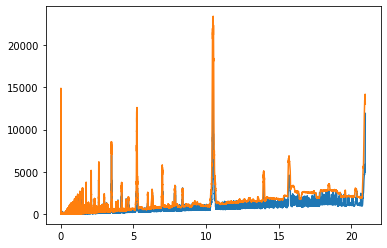

In [47]:
fig,ax = plt.subplots()
ax.plot(blsres['period'],blsres['power'])
ax.plot(blsres1['period'],blsres1['power'])
# ax.set_xscale('log')

763.2247644415672 10.476256370544434
5.0


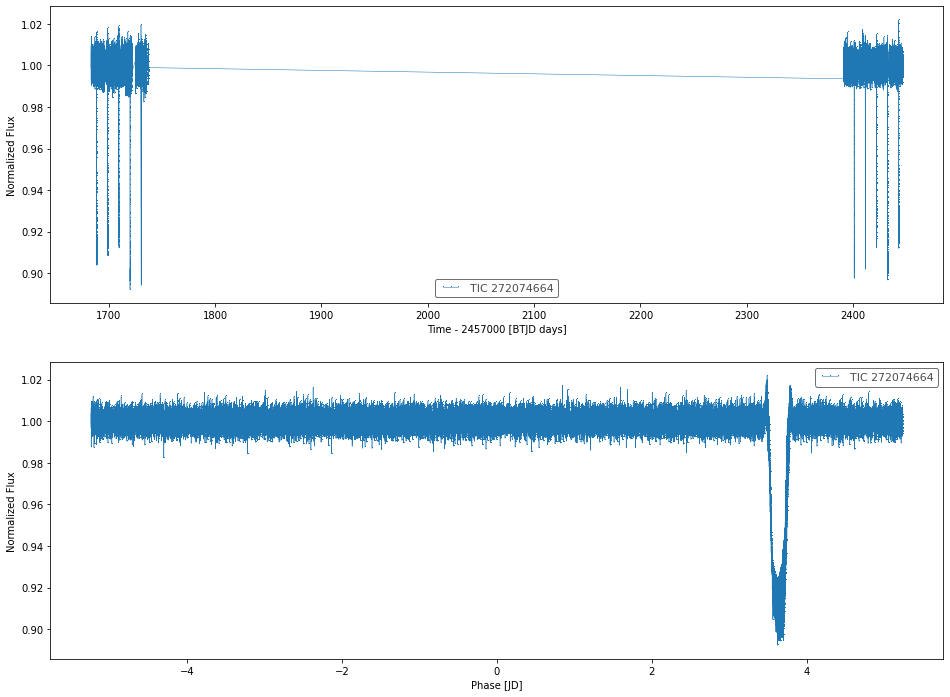

In [10]:
map_t0_bmjd = res['joker_param']['MAP_t0_bmjd']
t0_bmjd = astropy.time.Time(map_t0_bmjd, format='mjd', scale='tcb')

fig,ax = plt.subplots(nrows=2, figsize=(16,12))
res['all_lks'].plot(marker=',',ax=ax[0])
res['all_lks'].fold(period=res['joker_param']['MAP_P'],
                   epoch_time=t0_bmjd).plot(marker=',',ax=ax[1])

print(max(res['all_lks'].time)-min( res['all_lks'].time), res['joker_param']["MAP_P"])
for sect in res['group_inds']:
    obs_range = max(res['lk_coll'][sect].stitch().time.value) - min(res['lk_coll'][sect].stitch().time.value)
print(np.floor(obs_range/res['joker_param']['MAP_P'])) 

In [17]:
current_output_files = os.listdir("/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/")
# print(current_output_files)
highres_keeps = ['_highres_bls_params.pickle' in ii for ii in current_output_files]
print(np.array(current_output_files)[highres_keeps].shape)

(57,)


In [34]:
file = open("/Users/kjaehnig/CCA_work/GAT/tic_ids_of_systems_with_short_cadence_obs.txt",'r')
all_57_systems = file.read().split()
file.close()
# all_57_systems = [ii[:-1] for ii in all_57_systems]
# print(all_57_systems)
for ii in ['TIC_229536143']:
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{ii}_lightcurve_data.pickle",'rb')
    res = pk.load(file)
    file.close()
    
    blsres = run_bls_across_entire_observations(res)
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/{ii}_highres_bls_params.pickle",'wb')
    pk.dump(blsres, file)
    file.close()
    print("-"*50)

--------------------------------------------------
